# Code submission for ML Group Case Study - Telecom Churn
<b> Last Modified: </b>  Nov 2018

<b>Created by :</b> Poornimadevi Pandurangan, Yuga Deepa Chinnaswamy, Anupama Kumar and Mamta Venugopal

<b>Problem Statement:</b> In the telecom industry,customers have lot of choice of multiple service provider and they switch from one
                   operator to another. So, in the current market customer retention is more important than customer acquistion.
                   Retaining high profitable customers is number one business goal and then it necessary to predict who are 
                   customers with high risk to churn. Also, all the important indicators or predictors of churning need to be 
                   identified.

<b>Instructions:</b>      Kindly install the imbalance-learn library before running this jupyter notebook                    
                  
                  
                  pip install -U imbalanced-learn  



In [1]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# modelling
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# metrics
from sklearn.metrics import accuracy_score, precision_score, classification_report 
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, explained_variance_score

%matplotlib inline

# to suppress warnings
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# load data from csv
df = pd.read_csv("telecom_churn_data.csv")

In [3]:
# view few records
df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
#df.filter(like='total',axis=1).columns

# 1. Explore the data set

In [5]:
print("The dimensions of the dataset is {}".format(df.shape))

The dimensions of the dataset is (99999, 226)


In [6]:
# Explain the dtypes of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [7]:
# Since we are concerned about the high value customers. 
# Lets extract the high value customers and perform data analysis

# High Value Customers - Those who have recharged with an amount more than or equal to X, 
#    where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

# creating new column to indicate Total recharge Amount in Good Phase
df['total_rech_amt_good_phase'] = (df.total_rech_amt_6 + df.total_rech_amt_7)/2

print("70th percentile of total recharge amount in good phase is {}".format(np.quantile(df.total_rech_amt_good_phase,0.7)))

# Filter rows with 70th percentile and create new dataset
telecom = df[df.total_rech_amt_good_phase>=np.quantile(df.total_rech_amt_good_phase,0.7)]

# Shape of the new dataset
print("Shape of the new dataset with high value customers is {}".format(telecom.shape))

# deleting the original dataframe to clear some space
del df

70th percentile of total recharge amount in good phase is 368.5
Shape of the new dataset with high value customers is (30011, 227)


In [8]:
# The next step is to tag churners
# churn - Those who have not made any calls (either incoming or outgoing) AND 
#         have not used mobile internet even once in the churn phase
telecom['churn'] = np.where((telecom.total_ic_mou_9==0) & 
                            (telecom.total_og_mou_9==0) &
                            (telecom.vol_2g_mb_9==0) &
                            (telecom.vol_3g_mb_9==0),
                            1,0)

print("The number of churns in the dataset is {}".format(telecom.churn.value_counts()[1]))

print("The percentage of churns in the dataset is {:.2f}".format(telecom.churn.value_counts()[1]/len(telecom.churn)))

The number of churns in the dataset is 2593
The percentage of churns in the dataset is 0.09


In [9]:
# remove all the attributes related to '_9'

# find the attributes that have '_9'
cols_9 = telecom.filter(like='_9',axis=1).columns
print("No of Attributes related to 9th Month : {}".format(len(cols_9)))
print("Attributes related to 9th Month are: \n\n {}".format(cols_9))

# Drop all attributes related to '_9'
print("Shape before dropping: ",telecom.shape)
telecom = telecom.drop(cols_9,axis=1)
print("Shape after dropping: ",telecom.shape)



No of Attributes related to 9th Month : 54
Attributes related to 9th Month are: 

 Index(['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9',
       'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9',
       'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9',
       'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9',
       'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9',
       'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9',
       'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9',
       'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9',
       'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9',
       'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9',
       'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9',
       'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9',
       'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9',
  

In [10]:
# remove all the attributes related to 'sep_'

# find the attributes that have 'sep_'
cols_sep = telecom.filter(like='sep_',axis=1).columns
print("No of Attributes related to sep Month : {}".format(len(cols_sep)))
print("Attributes related to sep Month are: \n\n {}".format(cols_sep))

# Drop all attributes related to 'sep_'
print("Shape before dropping: ",telecom.shape)
telecom = telecom.drop(cols_sep,axis=1)
print("Shape after dropping: ",telecom.shape)



No of Attributes related to sep Month : 1
Attributes related to sep Month are: 

 Index(['sep_vbc_3g'], dtype='object')
Shape before dropping:  (30011, 174)
Shape after dropping:  (30011, 173)


# 2. Data Analysis

In [11]:
# check the distribution of values for numerical columns

telecom.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_rech_amt_good_phase,churn
count,3.001100e+04,30011.0,29897.0,29897.0,29897.0,30011.000000,30011.000000,30011.000000,29695.000000,29708.000000,...,30011.000000,11397.000000,11662.000000,11754.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000,30011.000000
mean,7.001223e+09,109.0,0.0,0.0,0.0,587.284404,589.135427,534.857433,299.184718,307.447285,...,0.140415,0.897605,0.889813,0.837332,1264.064776,129.439626,135.127102,121.360548,696.664356,0.086402
std,6.846405e+05,0.0,0.0,0.0,0.0,442.722413,462.897814,492.259586,462.202367,483.244786,...,0.974727,0.303181,0.313136,0.369078,975.263117,390.478591,408.024394,389.726031,488.782088,0.280961
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,368.500000,0.000000
25%,7.000641e+09,109.0,0.0,0.0,0.0,364.161000,365.004500,289.609500,42.960000,42.660000,...,0.000000,1.000000,1.000000,1.000000,480.000000,0.000000,0.000000,0.000000,450.000000,0.000000
50%,7.001232e+09,109.0,0.0,0.0,0.0,495.682000,493.561000,452.091000,128.330000,127.950000,...,0.000000,1.000000,1.000000,1.000000,914.000000,0.000000,0.000000,0.000000,568.500000,0.000000
75%,7.001814e+09,109.0,0.0,0.0,0.0,703.922000,700.788000,671.150000,357.120000,364.567500,...,0.000000,1.000000,1.000000,1.000000,1924.000000,1.600000,1.990000,0.000000,795.500000,0.000000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,41.000000,1.000000,1.000000,1.000000,4321.000000,12916.220000,9165.600000,11166.210000,37762.500000,1.000000


In [12]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30011 entries, 7 to 99997
Columns: 173 entries, mobile_number to churn
dtypes: float64(136), int64(28), object(9)
memory usage: 39.8+ MB


In [13]:
# from above description of the dataset, the following columns have only one value.
cols_std = pd.DataFrame(telecom.std(),columns=['std']).reset_index()
display(cols_std.loc[cols_std['std']==0,'index'])

# Removing these columns as they add to no spread in the data hence zero standard deviation
print("Shape before dropping: ",telecom.shape)
telecom.drop(cols_std.loc[cols_std['std']==0,'index'].values, axis=1, inplace=True)
print("Shape after dropping: ",telecom.shape)

1            circle_id
2       loc_og_t2o_mou
3       std_og_t2o_mou
4       loc_ic_t2o_mou
44    std_og_t2c_mou_6
45    std_og_t2c_mou_7
46    std_og_t2c_mou_8
83    std_ic_t2o_mou_6
84    std_ic_t2o_mou_7
85    std_ic_t2o_mou_8
Name: index, dtype: object

Shape before dropping:  (30011, 173)
Shape after dropping:  (30011, 163)


### Consider all columns related to dates

In [14]:
# Consider all columns related to dates

telecom.filter(like='date',axis=1).columns

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')

In [15]:
# convert all dates to appropriate datetime format

telecom["last_date_of_month_6"] = pd.to_datetime(telecom.last_date_of_month_6)
telecom["last_date_of_month_7"] = pd.to_datetime(telecom.last_date_of_month_7)
telecom["last_date_of_month_8"] = pd.to_datetime(telecom.last_date_of_month_8)

telecom["date_of_last_rech_6"] = pd.to_datetime(telecom.date_of_last_rech_6)
telecom["date_of_last_rech_7"] = pd.to_datetime(telecom.date_of_last_rech_7)
telecom["date_of_last_rech_8"] = pd.to_datetime(telecom.date_of_last_rech_8)

telecom["date_of_last_rech_data_6"] = pd.to_datetime(telecom.date_of_last_rech_data_6)
telecom["date_of_last_rech_data_7"] = pd.to_datetime(telecom.date_of_last_rech_data_7)
telecom["date_of_last_rech_data_8"] = pd.to_datetime(telecom.date_of_last_rech_data_8)

In [16]:
# Extract the day and the week information of the last recharge
telecom["day_of_last_rech_6"] = telecom.date_of_last_rech_6.dt.day
telecom["week_of_last_rech_6"] = (telecom.date_of_last_rech_6.dt.day // 7)+1 # week of the month

telecom["day_of_last_rech_7"] = telecom.date_of_last_rech_7.dt.day
telecom["week_of_last_rech_7"] = (telecom.date_of_last_rech_7.dt.day // 7) +1

telecom["day_of_last_rech_8"] = telecom.date_of_last_rech_8.dt.day
telecom["week_of_last_rech_8"] = (telecom.date_of_last_rech_8.dt.day // 7) + 1

In [17]:
# Extract the day and the week information of the last recharge
# Taking percetile with 4 as each month have 4 weeks  + less than 7 days
telecom["day_of_last_rech_data_6"] = telecom.date_of_last_rech_data_6.dt.day
telecom["week_of_last_rech_data_6"] = (telecom.date_of_last_rech_data_6.dt.day // 7) + 1

telecom["day_of_last_rech_data_7"] = telecom.date_of_last_rech_data_7.dt.day
telecom["week_of_last_rech_data_7"] = (telecom.date_of_last_rech_data_7.dt.day // 7) + 1

telecom["day_of_last_rech_data_8"] = telecom.date_of_last_rech_data_8.dt.day
telecom["week_of_last_rech_data_8"] = (telecom.date_of_last_rech_data_8.dt.day // 7) + 1

As we have extracted day and week information from each month last recharge date, we are dropping last recharge date.

In [18]:
# drop the date variables
telecom.drop(['last_date_of_month_6','last_date_of_month_7','last_date_of_month_8',
              'date_of_last_rech_6', 'date_of_last_rech_7','date_of_last_rech_8',
              'date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8'],axis=1, inplace=True)

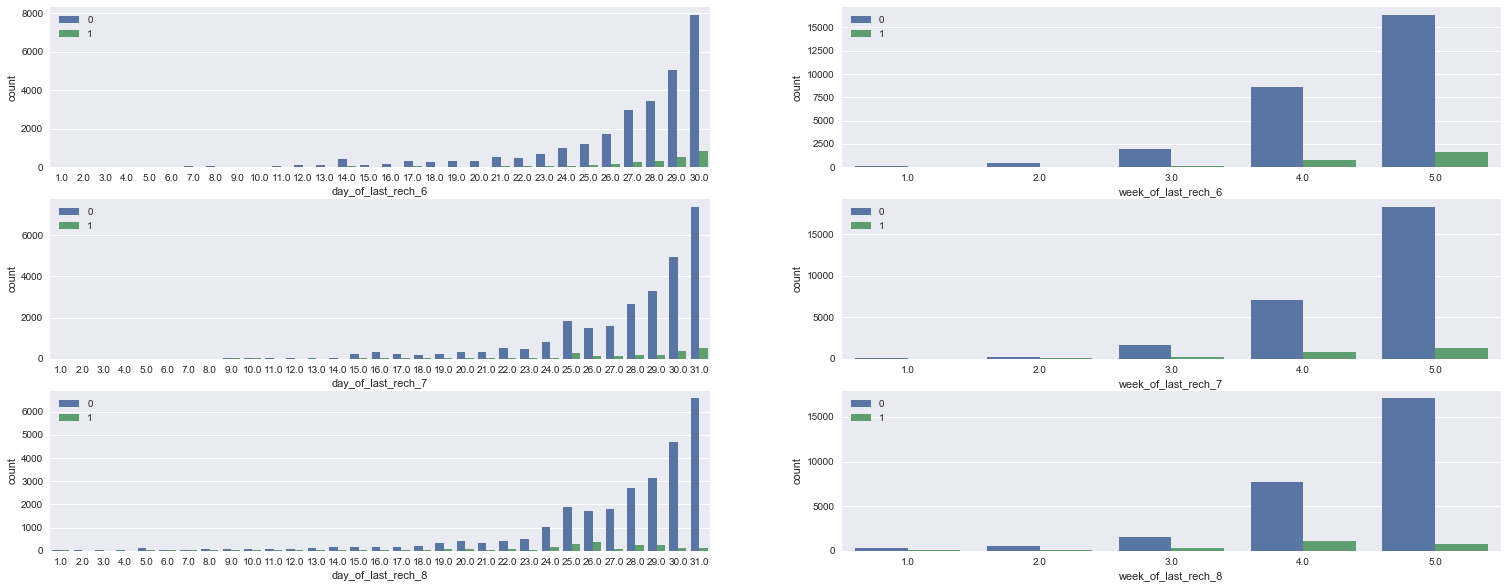

In [19]:
# plot the day and week of last recharge for good phase and action phase

plt.figure(figsize=(26,10))

plt.subplot(3,2,1)
sns.countplot(x='day_of_last_rech_6',hue='churn',data=telecom)
plt.legend(loc='upper left')

plt.subplot(3,2,2)
sns.countplot(x='week_of_last_rech_6',hue='churn',data=telecom)
plt.legend(loc='upper left')

plt.subplot(3,2,3)
sns.countplot(x='day_of_last_rech_7',hue='churn',data=telecom)
plt.legend(loc='upper left')

plt.subplot(3,2,4)
sns.countplot(x='week_of_last_rech_7',hue='churn',data=telecom)
plt.legend(loc='upper left')

plt.subplot(3,2,5)
sns.countplot(x='day_of_last_rech_8',hue='churn',data=telecom)
plt.legend(loc='upper left')

plt.subplot(3,2,6)
sns.countplot(x='week_of_last_rech_8',hue='churn',data=telecom)
plt.legend(loc='upper left')

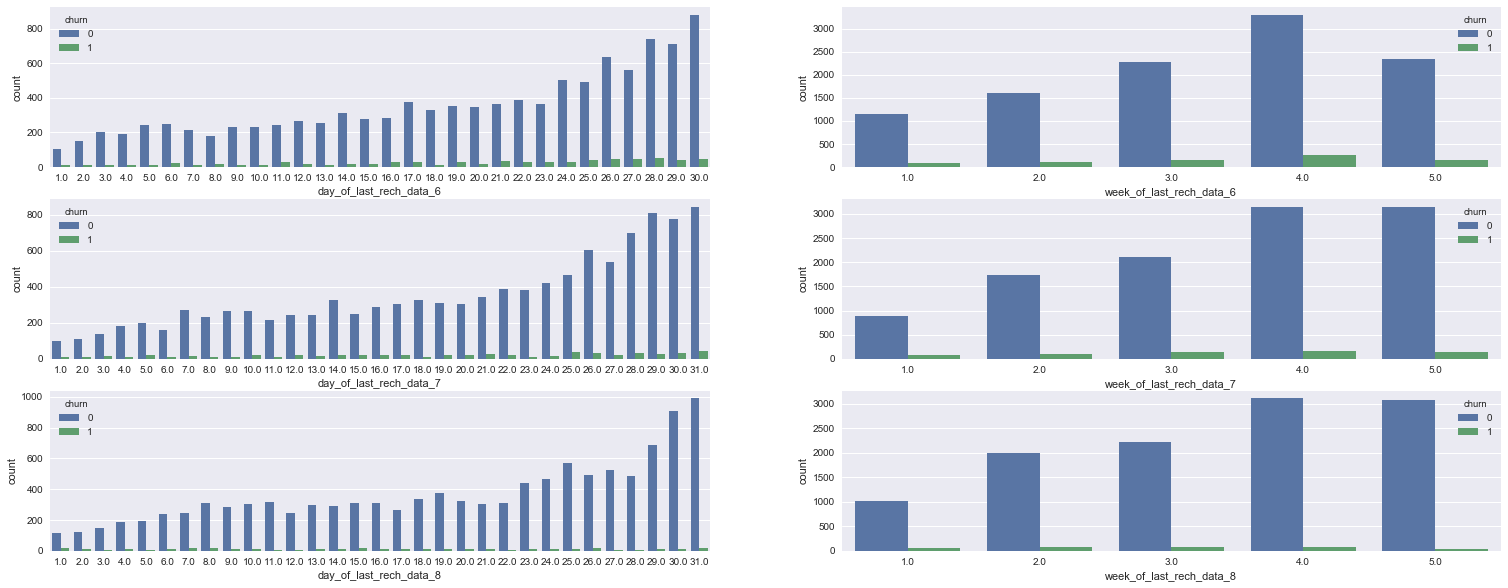

In [20]:
# plot the day and week of last recharge for good phase and action phase - for DATA

plt.figure(figsize=(26,10))

plt.subplot(3,2,1)
sns.countplot(x='day_of_last_rech_data_6',hue='churn',data=telecom)

plt.subplot(3,2,2)
sns.countplot(x='week_of_last_rech_data_6',hue='churn',data=telecom)

plt.subplot(3,2,3)
sns.countplot(x='day_of_last_rech_data_7',hue='churn',data=telecom)

plt.subplot(3,2,4)
sns.countplot(x='week_of_last_rech_data_7',hue='churn',data=telecom)

plt.subplot(3,2,5)
sns.countplot(x='day_of_last_rech_data_8',hue='churn',data=telecom)

plt.subplot(3,2,6)
sns.countplot(x='week_of_last_rech_data_8',hue='churn',data=telecom)

In [21]:
# check for missing values day and week of last rech columns
telecom[['day_of_last_rech_6','week_of_last_rech_6',
          'day_of_last_rech_7','week_of_last_rech_7',
         'day_of_last_rech_8','week_of_last_rech_8']].isnull().sum()

day_of_last_rech_6      62
week_of_last_rech_6     62
day_of_last_rech_7     114
week_of_last_rech_7    114
day_of_last_rech_8     594
week_of_last_rech_8    594
dtype: int64

In [22]:
# There could be many reasons why a user did not recharge. 

# Lets see the outgoing usage of those users during the same month
display(telecom[telecom.day_of_last_rech_6.isnull()].filter(like='_6',axis=1).filter(like='og',axis=1).describe())

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,og_others_6,total_og_mou_6
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,62.000000
mean,4.459688,69.245625,197.753750,2.387812,1.570000,269.391875,96.867813,128.382187,1.041250,226.293750,1.176875,2.751875,0.005000,257.870323
std,14.835579,122.339429,352.947374,5.212554,5.963227,468.898618,242.808764,298.405131,2.995953,527.559848,6.419016,7.116294,0.028284,660.602463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.265000,0.000000,0.000000,1.555000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
75%,0.442500,86.325000,262.830000,2.087500,0.000000,340.967500,9.597500,32.950000,0.000000,65.277500,0.000000,0.140000,0.000000,13.745000
max,79.790000,455.140000,1394.780000,23.310000,29.160000,1857.060000,1075.660000,1335.310000,14.390000,2106.060000,36.330000,29.160000,0.160000,3073.590000


In [23]:
# From the description table, there are many users whose outgoing usage is close to zero
# let us understand the other usages

print("% of users who did not recharge in all the months 6, 7, 8 are {:.0f}".format(
        telecom[telecom.day_of_last_rech_6.isnull() & 
                telecom.day_of_last_rech_7.isnull() & 
                telecom.day_of_last_rech_8.isnull()].shape[0] / telecom.shape[0]
    ))
print("\nNo of users with no voice and data usage in the 6th month:{} out of {} users who did not recharge. \nThe remaining {} are users who have not recharged but still using voice and data in 6th month".format(
    telecom[(telecom.day_of_last_rech_6.isnull()) &
        (telecom.total_ic_mou_6==0) &
        (telecom.total_og_mou_6==0) &
        (telecom.vol_2g_mb_6 ==0) &
        (telecom.vol_3g_mb_6==0)].shape[0],telecom[telecom.day_of_last_rech_6.isnull()].shape[0]
    ,(telecom[telecom.day_of_last_rech_6.isnull()].shape[0] - telecom[(telecom.day_of_last_rech_6.isnull()) &
        (telecom.total_ic_mou_6==0) &
        (telecom.total_og_mou_6==0) &
        (telecom.vol_2g_mb_6 ==0) &
        (telecom.vol_3g_mb_6==0)].shape[0])
    ))

print("\nNo of users with no voice and data usage in the 7th month:{} out of {} users who did not recharge. \nThe remaining {} are users who have not recharged but still using voice and data in 7th month".format(
    telecom[(telecom.day_of_last_rech_7.isnull()) &
        (telecom.total_ic_mou_7==0) &
        (telecom.total_og_mou_7==0) &
        (telecom.vol_2g_mb_7 ==0) &
        (telecom.vol_3g_mb_7==0)].shape[0],telecom[telecom.day_of_last_rech_7.isnull()].shape[0]
    ,(telecom[telecom.day_of_last_rech_7.isnull()].shape[0] - telecom[(telecom.day_of_last_rech_7.isnull()) &
        (telecom.total_ic_mou_7==0) &
        (telecom.total_og_mou_7==0) &
        (telecom.vol_2g_mb_7 ==0) &
        (telecom.vol_3g_mb_7==0)].shape[0])
))
print("\nNo of users with no voice and data usage in the 8th month:{} out of {} users who did not recharge. \nThe remaining {} are users who have not recharged but still using voice and data in 8th month".format(
    telecom[(telecom.day_of_last_rech_8.isnull()) &
        (telecom.total_ic_mou_8==0) &
        (telecom.total_og_mou_8==0) &
        (telecom.vol_2g_mb_8 ==0) &
        (telecom.vol_3g_mb_8==0)].shape[0], telecom[telecom.day_of_last_rech_8.isnull()].shape[0]
    ,(telecom[telecom.day_of_last_rech_8.isnull()].shape[0]-telecom[(telecom.day_of_last_rech_8.isnull()) &
        (telecom.total_ic_mou_8==0) &
        (telecom.total_og_mou_8==0) &
        (telecom.vol_2g_mb_8 ==0) &
        (telecom.vol_3g_mb_8==0)].shape[0])
))
print("")
print("Users who did not recharge in 6th month but have recharged in 7th and 8th month: {} out of {} users".format(
        telecom[telecom.day_of_last_rech_6.isnull() & 
                telecom.day_of_last_rech_7.notnull() & 
                telecom.day_of_last_rech_8.notnull()].shape[0],telecom[telecom.day_of_last_rech_6.isnull()].shape[0]
    ))

print("Users who did not recharge in 7th month but have recharged in 6th and 8th month: {} out of {} users".format(
        telecom[telecom.day_of_last_rech_6.notnull() & 
                telecom.day_of_last_rech_7.isnull() & 
                telecom.day_of_last_rech_8.notnull()].shape[0],telecom[telecom.day_of_last_rech_7.isnull()].shape[0]
    ))

print("Users who did not recharge in 8th month but have recharged in 6th and 7th month: {} out of {} users".format(
        telecom[telecom.day_of_last_rech_6.notnull() & 
                telecom.day_of_last_rech_7.notnull() & 
                telecom.day_of_last_rech_8.isnull()].shape[0],telecom[telecom.day_of_last_rech_8.isnull()].shape[0]
    ))
print("")
print("No of Churn Users who did not recharge in 8th month but have recharged in 6th and 7th month: {} out of {} users".format(
        telecom[telecom.day_of_last_rech_6.notnull() & 
                telecom.day_of_last_rech_7.notnull() & 
                telecom.day_of_last_rech_8.isnull() & 
               telecom.churn==1].shape[0],telecom[telecom.day_of_last_rech_8.isnull()].shape[0]
    ))

% of users who did not recharge in all the months 6, 7, 8 are 0

No of users with no voice and data usage in the 6th month:40 out of 62 users who did not recharge. 
The remaining 22 are users who have not recharged but still using voice and data in 6th month

No of users with no voice and data usage in the 7th month:52 out of 114 users who did not recharge. 
The remaining 62 are users who have not recharged but still using voice and data in 7th month

No of users with no voice and data usage in the 8th month:300 out of 594 users who did not recharge. 
The remaining 294 are users who have not recharged but still using voice and data in 8th month

Users who did not recharge in 6th month but have recharged in 7th and 8th month: 52 out of 62 users
Users who did not recharge in 7th month but have recharged in 6th and 8th month: 48 out of 114 users
Users who did not recharge in 8th month but have recharged in 6th and 7th month: 518 out of 594 users

No of Churn Users who did not recharge in 

In [24]:
# there is no trend in recharge date and churn values. 
# imputing null values with max - as the observation says most of the recharge happens during the last day / week
telecom['day_of_last_rech_6'] = telecom.day_of_last_rech_6.fillna(telecom.day_of_last_rech_6.max())
telecom['day_of_last_rech_7'] = telecom.day_of_last_rech_7.fillna(telecom.day_of_last_rech_7.max())
telecom['day_of_last_rech_8'] = telecom.day_of_last_rech_8.fillna(telecom.day_of_last_rech_8.max())
telecom['week_of_last_rech_6'] = telecom.week_of_last_rech_6.fillna(telecom.week_of_last_rech_6.max())
telecom['week_of_last_rech_7'] = telecom.week_of_last_rech_7.fillna(telecom.week_of_last_rech_7.max())
telecom['week_of_last_rech_8'] = telecom.week_of_last_rech_8.fillna(telecom.week_of_last_rech_8.max())

telecom[['day_of_last_rech_6','week_of_last_rech_6',
          'day_of_last_rech_7','week_of_last_rech_7',
         'day_of_last_rech_8','week_of_last_rech_8']].isnull().sum()

day_of_last_rech_6     0
week_of_last_rech_6    0
day_of_last_rech_7     0
week_of_last_rech_7    0
day_of_last_rech_8     0
week_of_last_rech_8    0
dtype: int64

In [25]:
# check for missing values day and week of last rech data columns
telecom[['day_of_last_rech_data_6','week_of_last_rech_data_6',
          'day_of_last_rech_data_7','week_of_last_rech_data_7',
         'day_of_last_rech_data_8','week_of_last_rech_data_8']].isnull().sum()

day_of_last_rech_data_6     18614
week_of_last_rech_data_6    18614
day_of_last_rech_data_7     18349
week_of_last_rech_data_7    18349
day_of_last_rech_data_8     18257
week_of_last_rech_data_8    18257
dtype: int64

In [26]:
# dropping the columns as they have more than 50%  missing values
telecom.drop(['day_of_last_rech_data_6','week_of_last_rech_data_6',
          'day_of_last_rech_data_7','week_of_last_rech_data_7',
         'day_of_last_rech_data_8','week_of_last_rech_data_8'], axis=1,inplace=True)

<b>Observations: </b>
    1. Most of the times recharge happens towards the last day of the month or last week of the month. But we do not see a different trend between churn and non-churn
    2. Comparing the last recharge date of action phase between churn and non-churn, there is no difference in the trend
    3. Similar trend observed for recharge of data package as mentioned above

### Consider all columns related to revenue

In [27]:
telecom.filter(like='arpu',axis=1).columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')

In [28]:
telecom.filter(like='arpu',axis=1).describe()

,arpu_6,arpu_7,arpu_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8
count,30011.000000,30011.000000,30011.000000,11397.000000,11662.000000,11754.000000,11397.000000,11662.000000,11754.000000
mean,587.284404,589.135427,534.857433,142.191067,143.817963,133.098754,132.278321,133.431682,122.137984
std,442.722413,462.897814,492.259586,255.296779,259.492088,240.334682,225.619174,230.794261,212.619574
min,-2258.709000,-2014.045000,-945.808000,-30.280000,-26.040000,-20.040000,-15.320000,-15.480000,-24.430000
25%,364.161000,365.004500,289.609500,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000
50%,495.682000,493.561000,452.091000,22.070000,21.910000,11.415000,40.200000,35.000000,21.495000
75%,703.922000,700.788000,671.150000,212.170000,212.170000,212.170000,212.170000,212.170000,212.170000
max,27731.088000,35145.834000,33543.624000,6362.280000,4980.900000,3716.900000,6433.760000,4809.360000,3467.170000


In [29]:
# filter rows that have arpu in negative
telecom[telecom.arpu_6<0].describe()

#ignoring the average revenue in negative as we have already filtered only high value customers.

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,jul_vbc_3g,jun_vbc_3g,total_rech_amt_good_phase,churn,day_of_last_rech_6,week_of_last_rech_6,day_of_last_rech_7,week_of_last_rech_7,day_of_last_rech_8,week_of_last_rech_8
count,3.400000e+01,34.000000,34.000000,34.000000,28.000000,34.000000,30.000000,28.000000,34.000000,30.000000,...,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,7.001224e+09,-204.381000,868.144176,719.759235,174.466786,585.054706,728.198667,501.318929,623.717059,855.955000,...,165.236471,0.555000,757.661765,0.235294,21.323529,3.647059,26.941176,4.441176,24.352941,4.147059
std,7.136897e+05,517.378249,725.654853,835.203773,405.769105,861.794279,962.192682,1144.567575,970.673424,1412.031901,...,816.308068,3.236178,485.217660,0.430562,6.900683,1.097721,5.145997,0.859569,8.427525,1.209366
min,7.000037e+09,-2258.709000,-92.766000,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,1.190000,...,0.000000,0.000000,378.000000,0.000000,7.000000,2.000000,10.000000,2.000000,5.000000,1.000000
25%,7.000645e+09,-118.212500,527.301000,303.910000,0.000000,17.340000,22.245000,9.035000,96.970000,139.485000,...,0.000000,0.000000,459.250000,0.000000,17.000000,3.000000,23.000000,4.000000,21.000000,3.250000
50%,7.001340e+09,-24.741500,742.253000,528.271000,4.055000,143.710000,203.590000,31.780000,170.695000,296.225000,...,0.000000,0.000000,552.500000,0.000000,21.000000,4.000000,29.000000,5.000000,28.000000,5.000000
75%,7.001684e+09,-5.000000,969.023250,869.996750,84.667500,832.885000,1403.617500,415.927500,639.540000,967.550000,...,0.000000,0.000000,921.000000,0.000000,28.750000,5.000000,31.000000,5.000000,31.000000,5.000000
max,7.002387e+09,-0.060000,3972.710000,4019.650000,1501.310000,3049.460000,3383.730000,4574.590000,4619.030000,5738.130000,...,4764.630000,18.870000,2510.500000,1.000000,30.000000,5.000000,31.000000,5.000000,31.000000,5.000000


In [30]:
# check for missing values
telecom[['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']].isnull().sum()

arpu_6           0
arpu_7           0
arpu_8           0
arpu_3g_6    18614
arpu_3g_7    18349
arpu_3g_8    18257
arpu_2g_6    18614
arpu_2g_7    18349
arpu_2g_8    18257
dtype: int64

In [31]:
# validate the arpu in 2g and 3g have usage volume in 2g and 3g

print('No of users who have ARPU for 2G = null in all the months are {}'.format(
    telecom[(telecom.arpu_2g_6.isnull()) & (telecom.arpu_2g_7.isnull()) & (telecom.arpu_2g_8.isnull())].shape[0]
))

print('No of users who have ARPU for 3G = null in all the months are {}'.format(
    telecom[(telecom.arpu_3g_6.isnull()) & (telecom.arpu_3g_7.isnull()) & (telecom.arpu_3g_8.isnull())].shape[0]
))

print('No of users who have ARPU for 2G = null and 3G = null in all the months are {}'.format(
    telecom[(telecom.arpu_2g_6.isnull()) & (telecom.arpu_2g_7.isnull()) & (telecom.arpu_2g_8.isnull()) &
            (telecom.arpu_3g_6.isnull()) & (telecom.arpu_3g_7.isnull()) & (telecom.arpu_3g_8.isnull())].shape[0]
))

print('No of users who have ARPU for data as null and usage volume also as null for all the months are {}'.format(
    telecom[(telecom.arpu_2g_6.isnull()) & (telecom.arpu_2g_7.isnull()) & (telecom.arpu_2g_8.isnull()) &
            (telecom.arpu_3g_6.isnull()) & (telecom.arpu_3g_7.isnull()) & (telecom.arpu_3g_8.isnull()) &
            (telecom.vol_2g_mb_6==0) & (telecom.vol_2g_mb_7==0) & (telecom.vol_2g_mb_8==0) &
            (telecom.vol_3g_mb_6==0) & (telecom.vol_3g_mb_7==0) & (telecom.vol_3g_mb_8==0)].shape[0]
))

No of users who have ARPU for 2G = null in all the months are 14335
No of users who have ARPU for 3G = null in all the months are 14335
No of users who have ARPU for 2G = null and 3G = null in all the months are 14335
No of users who have ARPU for data as null and usage volume also as null for all the months are 14335


In [32]:
# these users might be using only voice service and have not used data packages
telecom['voice_only'] = np.where((telecom.arpu_2g_6.isnull()) & (telecom.arpu_2g_7.isnull()) & (telecom.arpu_2g_8.isnull()) &
            (telecom.arpu_3g_6.isnull()) & (telecom.arpu_3g_7.isnull()) & (telecom.arpu_3g_8.isnull()) &
            (telecom.vol_2g_mb_6==0) & (telecom.vol_2g_mb_7==0) & (telecom.vol_2g_mb_8==0) &
            (telecom.vol_3g_mb_6==0) & (telecom.vol_3g_mb_7==0) & (telecom.vol_3g_mb_8==0),
                                 1,
                                 0)

In [33]:
# number of voice_only customers
display(telecom.voice_only.value_counts())

# summary table for voice only and churns
display(pd.crosstab(telecom.churn, telecom.voice_only, normalize=True))

0    15676
1    14335
Name: voice_only, dtype: int64

voice_only,0,1
churn,,
0,0.489054,0.424544
1,0.033288,0.053114


Voice only, 0 refers the user might be using both voice and data, or not using both.

In [34]:
# now imputing the missing values to 0 since null values in these columns mean there are usage of voice nor data in these columns
telecom[['arpu_6', 'arpu_7', 'arpu_8', 
         'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
         'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']] = telecom[['arpu_6', 'arpu_7', 'arpu_8', 
                                                       'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
                                                       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']].fillna(value=0)

In [35]:
# create new columns to indicate revenue in good phase(by finding the average of 6th and 7th month) and action phase(8th month) 

telecom['arpu_good_phase'] = round((telecom.arpu_6 + telecom.arpu_7)/2,2)
telecom['arpu_action_phase'] = telecom.arpu_8

telecom['arpu_increase_in_action'] = telecom.arpu_action_phase - telecom.arpu_good_phase

# drop columns arpu_6, arpu_7, arpu_8
telecom.drop(['arpu_6', 'arpu_7', 'arpu_8'],axis=1,inplace=True)

In [36]:
# create new columns to indicate revenue in 2G and 3G good phase(by finding the average of 6th and 7th month) and action phase(8th month) 
# create new columns in 2G and 3G good phase to find the increase in arpu for datapackages in action and good phase.
telecom['arpu_2g_good_phase'] = round((telecom.arpu_2g_6 + telecom.arpu_2g_7)/2,2)
telecom['arpu_2g_action_phase'] = telecom.arpu_2g_8

telecom['arpu_2g_increase_in_action'] = telecom.arpu_2g_action_phase - telecom.arpu_2g_good_phase

telecom['arpu_3g_good_phase'] = round((telecom.arpu_3g_6 + telecom.arpu_3g_7)/2,2)
telecom['arpu_3g_action_phase'] = telecom.arpu_3g_8

telecom['arpu_3g_increase_in_action'] = telecom.arpu_3g_action_phase - telecom.arpu_3g_good_phase

# drop columns arpu_2g_6, arpu_2g_7, arpu_2g_8, arpu_3g_6, arpu_3g_7, arpu_3g_8
telecom.drop(['arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8','arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8'],axis=1,inplace=True)

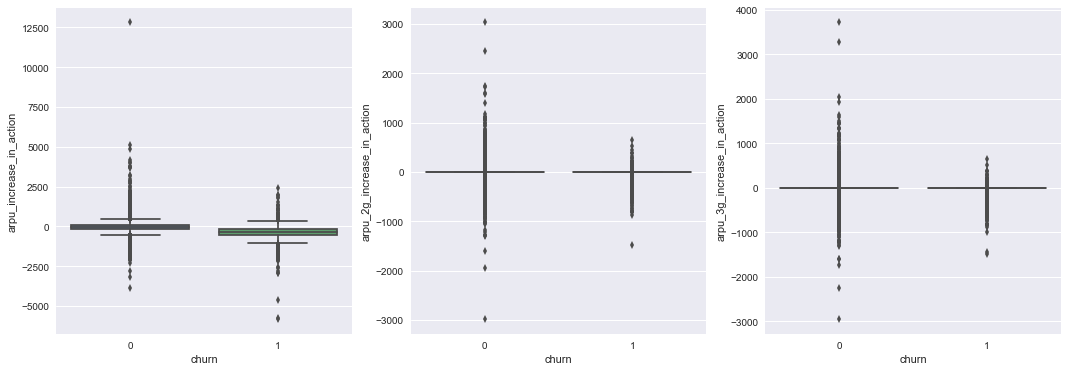

In [37]:
# plot the distributions of difference of revenues between action and good phase
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.boxplot(x='churn',y='arpu_increase_in_action',data=telecom)

plt.subplot(1,3,2)
sns.boxplot(x='churn',y='arpu_2g_increase_in_action',data=telecom)

plt.subplot(1,3,3)
sns.boxplot(x='churn',y='arpu_3g_increase_in_action',data=telecom)

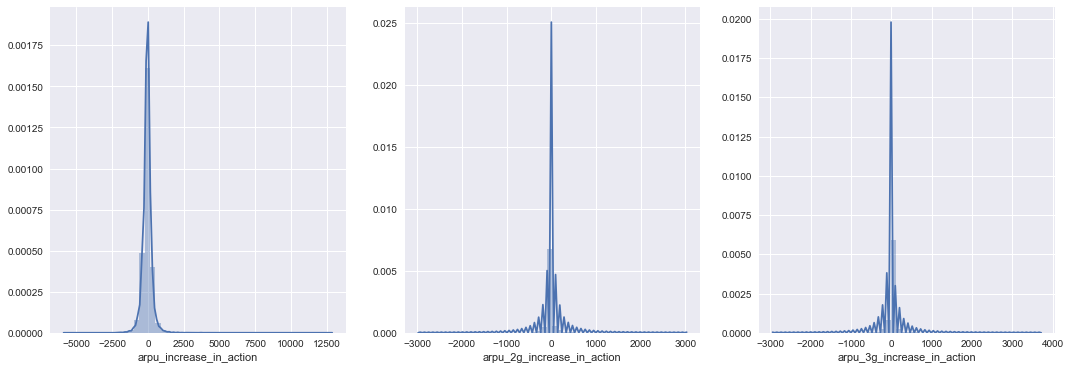

In [38]:
# plot the distributions of difference of revenues in action phase for 2G,3G and overall
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.distplot(telecom.arpu_increase_in_action)

plt.subplot(1,3,2)
sns.distplot(telecom.arpu_2g_increase_in_action)

plt.subplot(1,3,3)
sns.distplot(telecom.arpu_3g_increase_in_action)

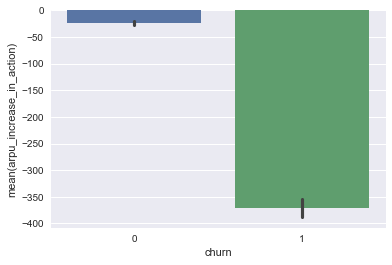

In [39]:
# check if there is a difference in ARPU for non-churns Vs Churns
sns.barplot(x='churn',y='arpu_increase_in_action',data=telecom)

<b>Observation: </b> Churners are generating less revenue during the action phase. So for churners, average revenue increase in action phase is negative in above plot.

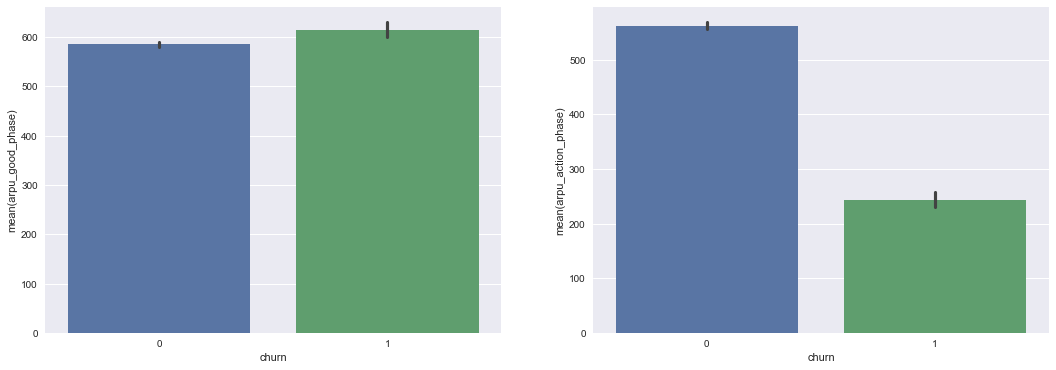

In [40]:
# plot the average revenue during good phase and action phase
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.barplot(x='churn',y='arpu_good_phase',data=telecom)

plt.subplot(1,2,2)
sns.barplot(x='churn',y='arpu_action_phase',data=telecom)

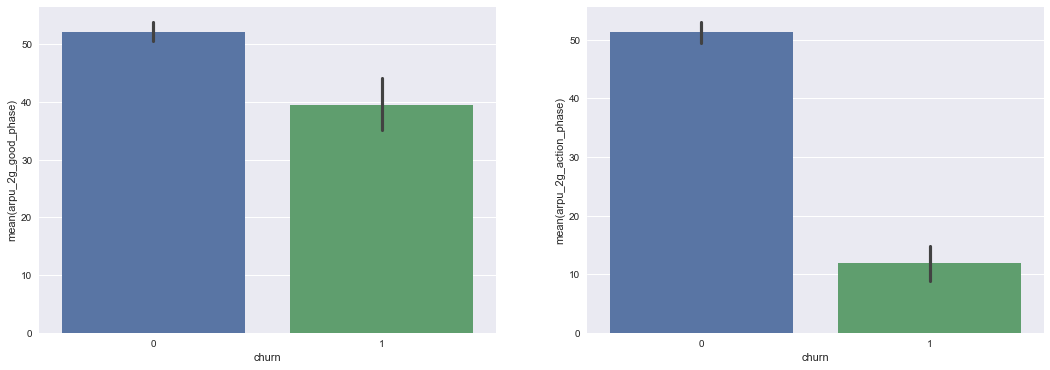

In [41]:
# plot the average revenue in 2G during good phase and action phase
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.barplot(x='churn',y='arpu_2g_good_phase',data=telecom)

plt.subplot(1,2,2)
sns.barplot(x='churn',y='arpu_2g_action_phase',data=telecom)

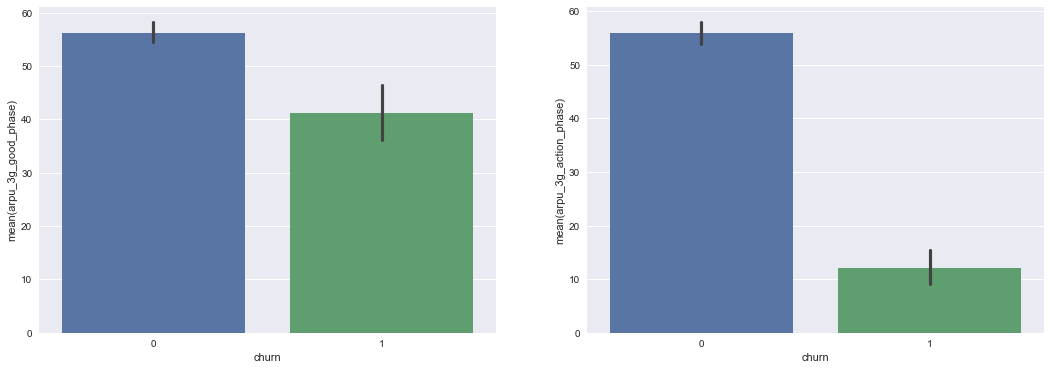

In [42]:
# plot the average revenue in 3g during good phase and action phase
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.barplot(x='churn',y='arpu_3g_good_phase',data=telecom)

plt.subplot(1,2,2)
sns.barplot(x='churn',y='arpu_3g_action_phase',data=telecom)

<b>Observations: </b>
    1. Mean of Average revenue per user shows significant decrease in action phase compared to good phase.
    2. Average revenue per user in action phase for churners show significant decrease (difference is in negative).

### Consider all columns related to recharge amount and number of times recharged

In [43]:
telecom[['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8']].describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8
count,30011.000000,30011.000000,30011.000000
mean,697.365833,695.962880,613.638799
std,539.325984,562.143146,601.821630
min,0.000000,0.000000,0.000000
25%,432.000000,426.500000,309.000000
50%,584.000000,581.000000,520.000000
75%,837.000000,835.000000,790.000000
max,35190.000000,40335.000000,45320.000000


In [44]:
# create new columns for good phase and action phase

telecom['total_rech_amt_good_phase'] = (telecom.total_rech_amt_6 + telecom.total_rech_amt_7) / 2
telecom['total_rech_amt_action_phase'] = telecom.total_rech_amt_8

# column to indicate the difference in action phase compared to good phase
telecom['total_rech_amt_increase_in_action_phase'] = telecom['total_rech_amt_action_phase'] - telecom['total_rech_amt_good_phase']

# drop the original variables
telecom.drop(['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8'],axis=1,inplace=True)


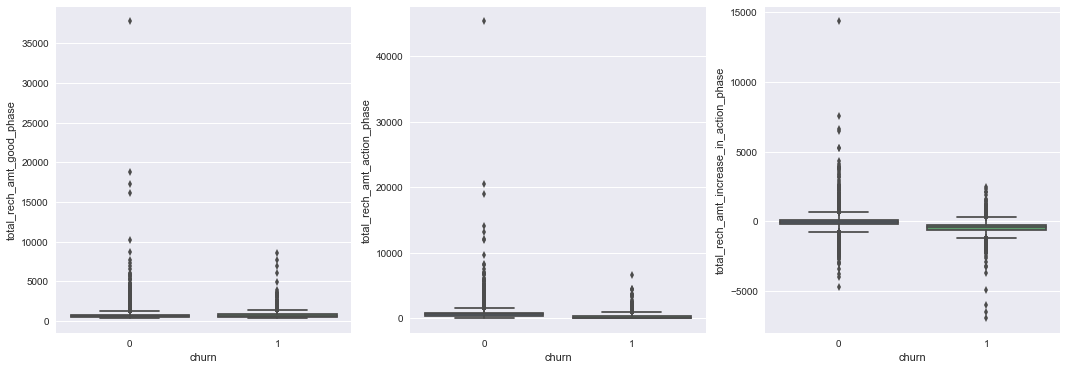

In [45]:
# plot the total recharge amount wrt to churn
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.boxplot(x='churn',y='total_rech_amt_good_phase',data=telecom)

plt.subplot(1,3,2)
sns.boxplot(x='churn',y='total_rech_amt_action_phase',data=telecom)

plt.subplot(1,3,3)
sns.boxplot(x='churn',y='total_rech_amt_increase_in_action_phase',data=telecom)

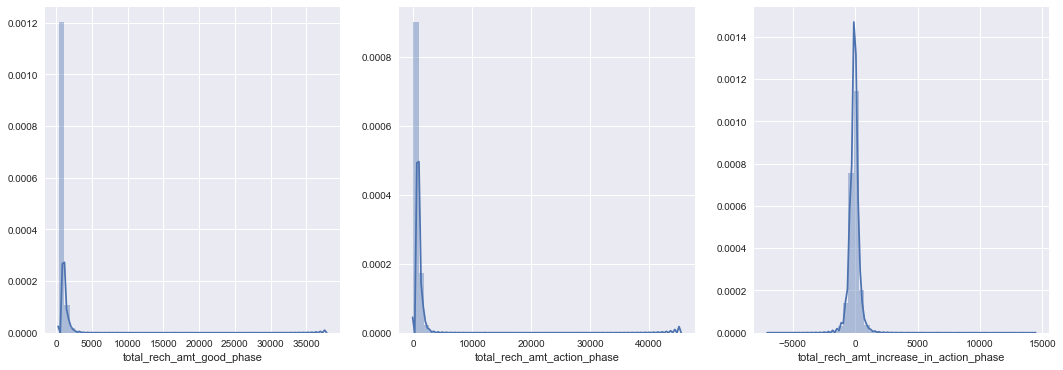

In [46]:
# plot the total recharge amount distribution
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.distplot(telecom.total_rech_amt_good_phase)

plt.subplot(1,3,2)
sns.distplot(telecom.total_rech_amt_action_phase)

plt.subplot(1,3,3)
sns.distplot(telecom.total_rech_amt_increase_in_action_phase)

In [47]:
telecom[['total_rech_amt_good_phase','total_rech_amt_action_phase']].describe(percentiles=[.25,.5,.75,.9,.99])

,total_rech_amt_good_phase,total_rech_amt_action_phase
count,30011.000000,30011.000000
mean,696.664356,613.638799
std,488.782088,601.821630
min,368.500000,0.000000
25%,450.000000,309.000000
50%,568.500000,520.000000
75%,795.500000,790.000000
90%,1118.000000,1155.000000
99%,2216.300000,2341.900000
max,37762.500000,45320.000000


In [48]:
telecom[(telecom.total_rech_amt_good_phase>=9000) &
                               (telecom.total_rech_amt_action_phase>=9000)].churn

33019    0
38610    0
51314    0
67717    0
Name: churn, dtype: int64

In [49]:
# there are clear outliers in total_rech_amt in both good phase and action phase

# let us study the outliers
print("Outliers that have total_rech_amt_good_phase >= 9000 is {} rows".format(
    telecom[telecom.total_rech_amt_good_phase>=9000].shape[0]))

print("Outliers that have total_rech_amt_action_phase >= 9000 is {} rows".format(
    telecom[telecom.total_rech_amt_action_phase>=9000].shape[0]))

# check the distribution of churns in the outliers
print("Number of outliers from both good phase and action phase: ",telecom[(telecom.total_rech_amt_good_phase>=9000) &
                               (telecom.total_rech_amt_action_phase>=9000)].churn.value_counts())

# check if there are any churns
print("Churn value for outliers having recharge amout >=9000 in both phase:")
print(telecom[(telecom.total_rech_amt_good_phase>=9000) &
        (telecom.total_rech_amt_action_phase>=9000)][['churn']])

# check the distribution if we remove the total_rech_amt_good_phase >=9000 data
telecom[(telecom.total_rech_amt_good_phase<9000) &
        (telecom.total_rech_amt_action_phase<9000)][['total_rech_amt_good_phase',
                                                     'total_rech_amt_action_phase',
                                                     'total_rech_amt_increase_in_action_phase']].describe(percentiles=[.25,.5,.75,.9,.99])

Outliers that have total_rech_amt_good_phase >= 9000 is 5 rows
Outliers that have total_rech_amt_action_phase >= 9000 is 8 rows
Number of outliers from both good phase and action phase:  0    4
Name: churn, dtype: int64
Churn value for outliers having recharge amout >=9000 in both phase:
       churn
33019      0
38610      0
51314      0
67717      0


,total_rech_amt_good_phase,total_rech_amt_action_phase,total_rech_amt_increase_in_action_phase
count,30002.000000,30002.000000,30002.000000
mean,692.647623,608.753150,-83.894474
std,396.617991,497.693078,409.816416
min,368.500000,0.000000,-6950.000000
25%,450.000000,308.000000,-272.875000
50%,568.500000,520.000000,-71.000000
75%,795.500000,790.000000,105.000000
90%,1117.000000,1154.000000,318.500000
99%,2202.000000,2327.930000,1023.985000
max,8735.000000,8200.000000,6640.000000


<b>Observation:</b>
Outliers with recharge amount >=9000 in both good and action phase have not churned. So it is safe to delete the rows.

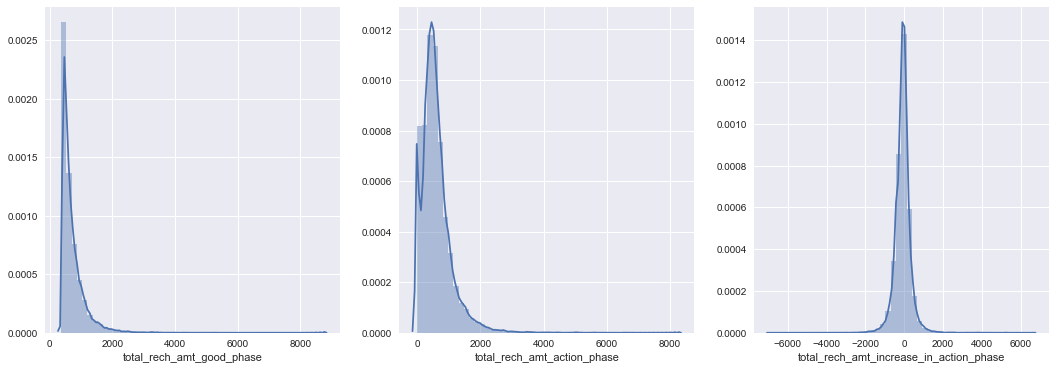

In [50]:
# plot the distribution without the outliers

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.distplot(telecom[(telecom.total_rech_amt_good_phase<9000) &
                     (telecom.total_rech_amt_action_phase<9000)].total_rech_amt_good_phase)

plt.subplot(1,3,2)
sns.distplot(telecom[(telecom.total_rech_amt_good_phase<9000) &
                     (telecom.total_rech_amt_action_phase<9000)].total_rech_amt_action_phase)

plt.subplot(1,3,3)
sns.distplot(telecom[(telecom.total_rech_amt_good_phase<9000) &
                     (telecom.total_rech_amt_action_phase<9000)].total_rech_amt_increase_in_action_phase)


In [51]:
# if we remove these outliers there is no loss of information as no 'churn' data is lost
# hence we decide to remove these rows
print("Shape before dropping", telecom.shape)
telecom.drop(telecom[(telecom.total_rech_amt_good_phase>=9000) & (telecom.total_rech_amt_action_phase>=9000)].index,
                    axis=0, inplace=True)

print("Shape after dropping", telecom.shape)

Shape before dropping (30011, 160)
Shape after dropping (30007, 160)


In [52]:
# checking for missing values
telecom[['total_rech_amt_good_phase','total_rech_amt_action_phase']].isnull().sum()

total_rech_amt_good_phase      0
total_rech_amt_action_phase    0
dtype: int64

In [53]:
telecom[['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']].describe()

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
count,30007.000000,30007.000000,30007.000000
mean,171.184657,175.342887,162.551138
std,173.036899,179.169464,170.088281
min,0.000000,0.000000,0.000000
25%,110.000000,110.000000,67.000000
50%,120.000000,128.000000,130.000000
75%,200.000000,200.000000,198.000000
max,4010.000000,4010.000000,4449.000000


In [54]:
# create new columns for good phase and action phase

telecom['max_rech_amt_good_phase'] = (telecom.max_rech_amt_6 + telecom.max_rech_amt_7) / 2
telecom['max_rech_amt_action_phase'] = telecom.max_rech_amt_8

telecom['max_rech_amt_increase_in_action_phase'] = telecom.max_rech_amt_action_phase - telecom.max_rech_amt_good_phase

# drop the original variables
telecom.drop(['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8'],axis=1,inplace=True)

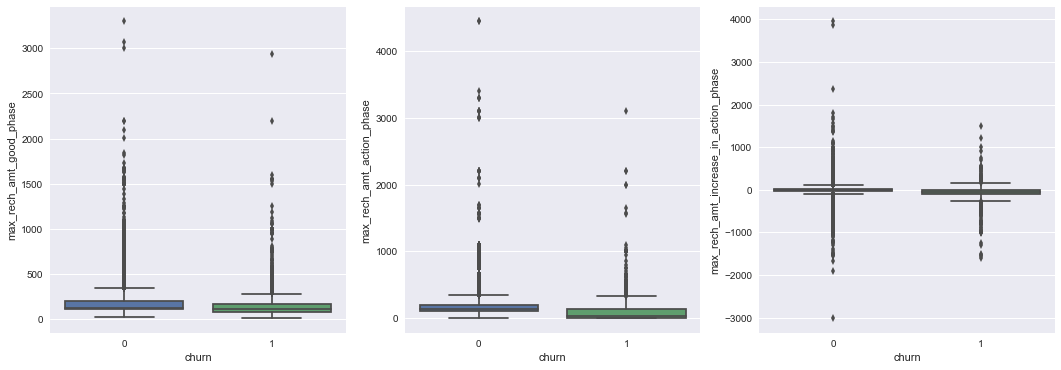

In [55]:
# plot the max recharge amount wrt to churn
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.boxplot(x='churn',y='max_rech_amt_good_phase',data=telecom)

plt.subplot(1,3,2)
sns.boxplot(x='churn',y='max_rech_amt_action_phase',data=telecom)

plt.subplot(1,3,3)
sns.boxplot(x='churn',y='max_rech_amt_increase_in_action_phase',data=telecom)

In [56]:
telecom[['max_rech_amt_good_phase','max_rech_amt_action_phase','max_rech_amt_increase_in_action_phase']].describe()

,max_rech_amt_good_phase,max_rech_amt_action_phase,max_rech_amt_increase_in_action_phase
count,30007.000000,30007.000000,30007.000000
mean,173.263772,162.551138,-10.712634
std,151.350898,170.088281,137.070612
min,9.000000,0.000000,-3010.000000
25%,110.000000,67.000000,-33.000000
50%,124.000000,130.000000,0.000000
75%,200.000000,198.000000,25.000000
max,3299.000000,4449.000000,3949.000000


In [57]:
telecom[['max_rech_amt_good_phase','max_rech_amt_action_phase','max_rech_amt_increase_in_action_phase']].isnull().sum()

max_rech_amt_good_phase                  0
max_rech_amt_action_phase                0
max_rech_amt_increase_in_action_phase    0
dtype: int64

In [58]:
# create new columns for good phase and action phase

telecom['total_rech_data_good_phase'] = (telecom.total_rech_data_6 + telecom.total_rech_data_7) / 2
telecom['total_rech_data_action_phase'] = telecom.total_rech_data_8

telecom['total_rech_data_increase_in_action'] = telecom.total_rech_data_action_phase - telecom.total_rech_data_good_phase

telecom['max_rech_data_good_phase'] = (telecom.max_rech_data_6 + telecom.max_rech_data_7) / 2
telecom['max_rech_data_action_phase'] = telecom.max_rech_data_8

telecom['max_rech_data_increase_in_action'] = telecom.max_rech_data_action_phase - telecom.max_rech_data_good_phase

telecom['av_rech_amt_data_good_phase'] = (telecom.av_rech_amt_data_6 + telecom.av_rech_amt_data_7) / 2
telecom['av_rech_amt_data_action_phase'] = telecom.av_rech_amt_data_8

# drop the original variables
telecom.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8'],axis=1,inplace=True)
telecom.drop(['max_rech_data_6','max_rech_data_7','max_rech_data_8'],axis=1,inplace=True)
telecom.drop(['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8'],axis=1,inplace=True)

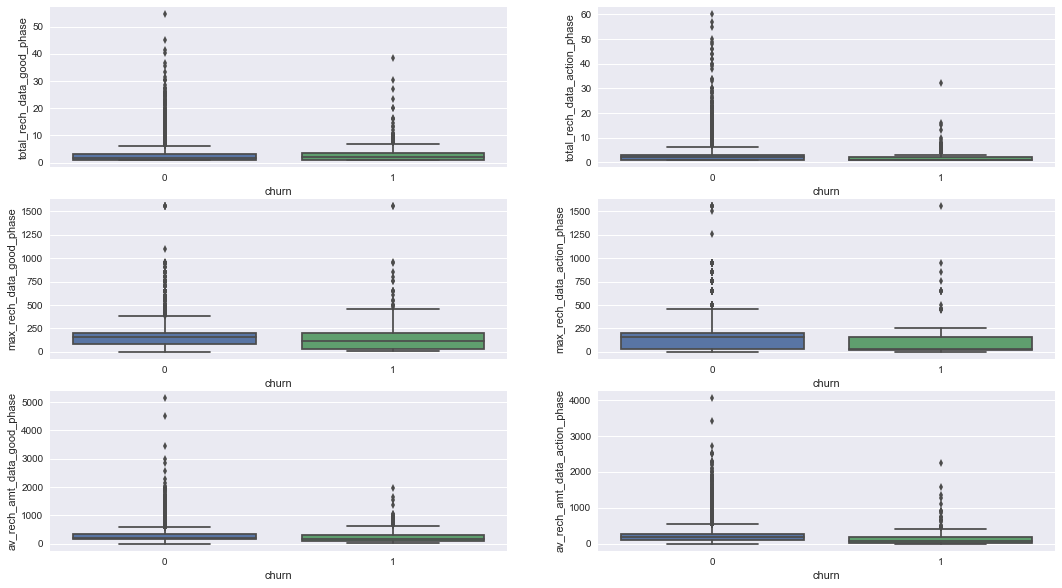

In [59]:
# plot the max recharge amount wrt to churn
plt.figure(figsize=(18,10))
plt.subplot(3,2,1)
sns.boxplot(x='churn',y='total_rech_data_good_phase',data=telecom)

plt.subplot(3,2,2)
sns.boxplot(x='churn',y='total_rech_data_action_phase',data=telecom)

plt.subplot(3,2,3)
sns.boxplot(x='churn',y='max_rech_data_good_phase',data=telecom)

plt.subplot(3,2,4)
sns.boxplot(x='churn',y='max_rech_data_action_phase',data=telecom)

plt.subplot(3,2,5)
sns.boxplot(x='churn',y='av_rech_amt_data_good_phase',data=telecom)

plt.subplot(3,2,6)
sns.boxplot(x='churn',y='av_rech_amt_data_action_phase',data=telecom)

In [60]:
telecom[['total_rech_data_good_phase','total_rech_data_action_phase','total_rech_data_increase_in_action',
         'max_rech_data_good_phase', 'max_rech_data_action_phase','max_rech_data_increase_in_action',
        'av_rech_amt_data_good_phase','av_rech_amt_data_action_phase']].isnull().sum()

total_rech_data_good_phase            20785
total_rech_data_action_phase          18254
total_rech_data_increase_in_action    22334
max_rech_data_good_phase              20785
max_rech_data_action_phase            18254
max_rech_data_increase_in_action      22334
av_rech_amt_data_good_phase           20785
av_rech_amt_data_action_phase         18254
dtype: int64

In [61]:
# check if missing values are only for users who are voice only
telecom[telecom.voice_only==0][['total_rech_data_good_phase','total_rech_data_action_phase',
                                'total_rech_data_increase_in_action','max_rech_data_good_phase', 
                                'max_rech_data_action_phase','max_rech_data_increase_in_action',
                                'av_rech_amt_data_good_phase','av_rech_amt_data_action_phase']].isnull().sum()

total_rech_data_good_phase            6453
total_rech_data_action_phase          3922
total_rech_data_increase_in_action    8002
max_rech_data_good_phase              6453
max_rech_data_action_phase            3922
max_rech_data_increase_in_action      8002
av_rech_amt_data_good_phase           6453
av_rech_amt_data_action_phase         3922
dtype: int64

In [62]:
# most of the values are missing for these columns. dropping these columns
telecom.drop(['total_rech_data_good_phase','total_rech_data_action_phase',
                                'total_rech_data_increase_in_action','max_rech_data_good_phase', 
                                'max_rech_data_action_phase','max_rech_data_increase_in_action',
                                'av_rech_amt_data_good_phase','av_rech_amt_data_action_phase'],axis=1,inplace=True)

In [63]:
# create new columns for good phase and action phase

telecom['last_day_rch_amt_good_phase'] = (telecom.last_day_rch_amt_6 + telecom.last_day_rch_amt_7) / 2
telecom['last_day_rch_amt_action_phase'] = telecom.last_day_rch_amt_8

# drop the original variables
telecom.drop(['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8'],axis=1,inplace=True)

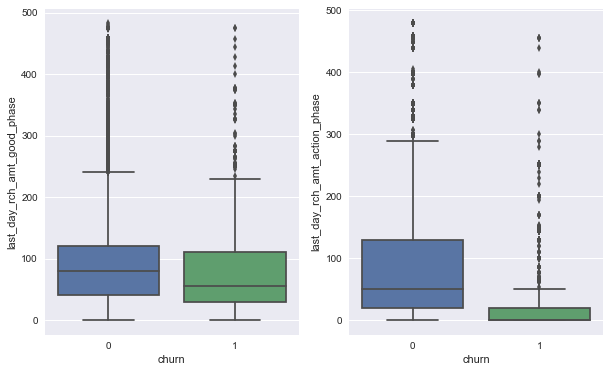

In [64]:
# plot the max recharge amount wrt to churn
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.boxplot(x='churn',y='last_day_rch_amt_good_phase',data=telecom[telecom.last_day_rch_amt_good_phase<500])

plt.subplot(1,2,2)
sns.boxplot(x='churn',y='last_day_rch_amt_action_phase',data=telecom[telecom.last_day_rch_amt_action_phase<500])

In [65]:
# check for missing values
telecom[['last_day_rch_amt_good_phase','last_day_rch_amt_action_phase']].isnull().sum()

last_day_rch_amt_good_phase      0
last_day_rch_amt_action_phase    0
dtype: int64

In [66]:
# create new columns for good phase and action phase

telecom['total_rech_num_good_phase'] = (telecom.total_rech_num_6 + telecom.total_rech_num_7) / 2
telecom['total_rech_num_action_phase'] = telecom.total_rech_num_8

telecom['count_rech_2g_good_phase'] = (telecom.count_rech_2g_6 + telecom.count_rech_2g_7) / 2
telecom['count_rech_2g_action_phase'] = telecom.count_rech_2g_8

telecom['count_rech_3g_good_phase'] = (telecom.count_rech_3g_6 + telecom.count_rech_3g_7) / 2
telecom['count_rech_3g_action_phase'] = telecom.count_rech_3g_8

# drop the original variables
telecom.drop(['total_rech_num_6','total_rech_num_7','total_rech_num_8'],axis=1,inplace=True)
telecom.drop(['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8'],axis=1,inplace=True)
telecom.drop(['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'],axis=1,inplace=True)

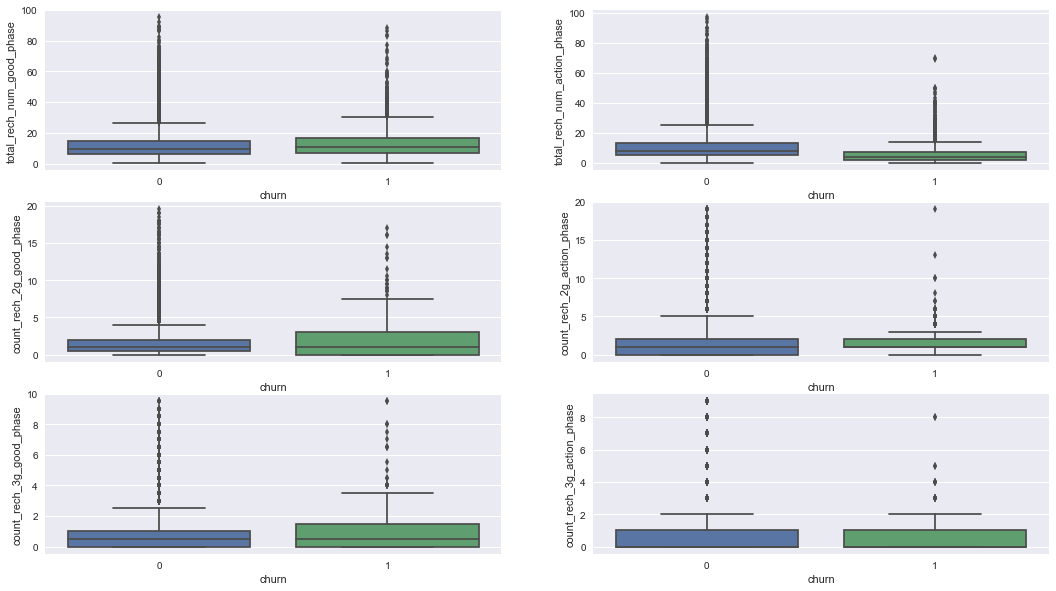

In [67]:
# plot the max recharge amount wrt to churn
plt.figure(figsize=(18,10))
plt.subplot(3,2,1)
sns.boxplot(x='churn',y='total_rech_num_good_phase',data=telecom[telecom.total_rech_num_good_phase<100])

plt.subplot(3,2,2)
sns.boxplot(x='churn',y='total_rech_num_action_phase',data=telecom[telecom.total_rech_num_action_phase<100])

plt.subplot(3,2,3)
sns.boxplot(x='churn',y='count_rech_2g_good_phase',data=telecom[telecom.count_rech_2g_good_phase<20])

plt.subplot(3,2,4)
sns.boxplot(x='churn',y='count_rech_2g_action_phase',data=telecom[telecom.count_rech_2g_action_phase<20])

plt.subplot(3,2,5)
sns.boxplot(x='churn',y='count_rech_3g_good_phase',data=telecom[telecom.count_rech_3g_good_phase<10])

plt.subplot(3,2,6)
sns.boxplot(x='churn',y='count_rech_3g_action_phase',data=telecom[telecom.count_rech_3g_action_phase<10])

In [68]:
# check for missing values
telecom[['total_rech_num_good_phase','total_rech_num_action_phase',
         'count_rech_2g_good_phase','count_rech_2g_action_phase',
         'count_rech_3g_good_phase','count_rech_3g_action_phase']].isnull().sum()

total_rech_num_good_phase          0
total_rech_num_action_phase        0
count_rech_2g_good_phase       20785
count_rech_2g_action_phase     18254
count_rech_3g_good_phase       20785
count_rech_3g_action_phase     18254
dtype: int64

In [69]:
# most of the data in the columns related to 2g and 3g are missing. Dropping those columns
telecom.drop(['count_rech_2g_good_phase','count_rech_2g_action_phase',
              'count_rech_3g_good_phase','count_rech_3g_action_phase'],axis=1,inplace=True)

<b>Observations: </b>
    1. The last day recharge amount in action phase is significantly low (on an average) compared to the recharge amount in good phase
    2. The total number of times recharged in action phase for churners is less than the total number of times recharged in good phase. 

### Consider all columns related to usage volume

In [70]:
# check the distribution of values in usage volume
telecom.filter(like='vol',axis=1).describe()

,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8
count,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000,30007.000000
mean,78.869477,78.181802,69.217494,258.426714,278.130807,269.872711
std,277.462068,280.349088,268.511167,866.248090,855.733347,859.346404
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14.470000,14.960000,9.620000,0.000000,2.120000,0.000000
max,10285.900000,7873.550000,11117.610000,45735.400000,28144.120000,30036.060000


In [71]:
# create new columns for good phase and action phase

telecom['vol_2g_mb_good_phase'] = (telecom.vol_2g_mb_6 + telecom.vol_2g_mb_7) / 2
telecom['vol_2g_mb_action_phase'] = telecom.vol_2g_mb_8

telecom['vol_3g_mb_good_phase'] = (telecom.vol_3g_mb_6 + telecom.vol_3g_mb_7) / 2
telecom['vol_3g_mb_action_phase'] = telecom.vol_3g_mb_8

# drop the variables volume per month
telecom.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8'],axis=1,inplace=True)
telecom.drop(['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8'],axis=1,inplace=True)

In [72]:
# check the distribution
telecom[['vol_2g_mb_good_phase','vol_2g_mb_action_phase','vol_3g_mb_good_phase','vol_3g_mb_action_phase']].describe()

,vol_2g_mb_good_phase,vol_2g_mb_action_phase,vol_3g_mb_good_phase,vol_3g_mb_action_phase
count,30007.000000,30007.000000,30007.000000,30007.000000
mean,78.525640,69.217494,268.278761,269.872711
std,254.216513,268.511167,795.009411,859.346404
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,29.335000,9.620000,99.845000,0.000000
max,7939.075000,11117.610000,36667.845000,30036.060000


In [73]:
# check for missing values 
telecom[['vol_2g_mb_good_phase','vol_2g_mb_action_phase','vol_3g_mb_good_phase','vol_3g_mb_action_phase']].isnull().sum()

vol_2g_mb_good_phase      0
vol_2g_mb_action_phase    0
vol_3g_mb_good_phase      0
vol_3g_mb_action_phase    0
dtype: int64

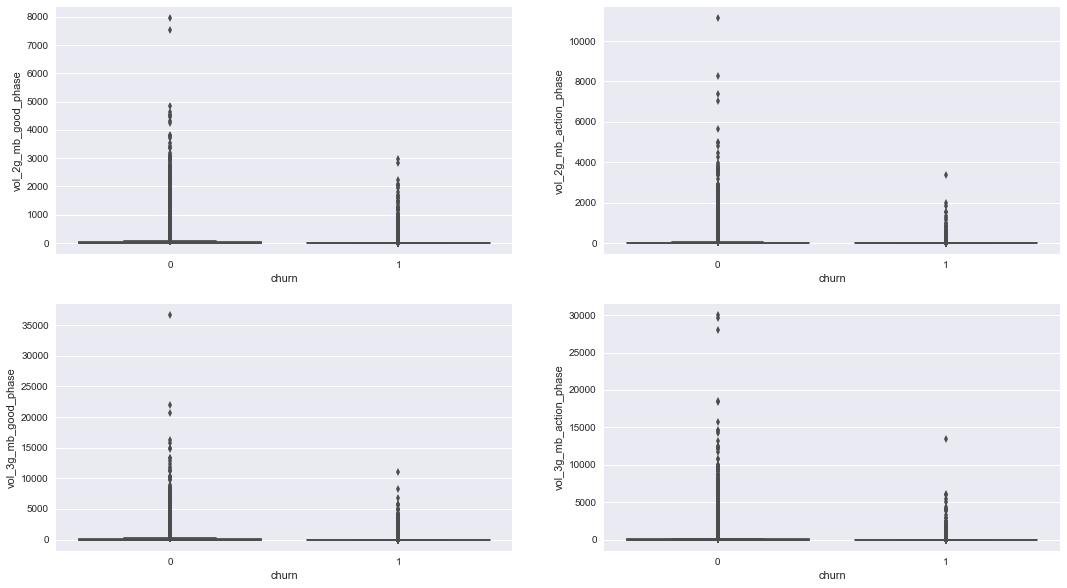

In [74]:
# plot the distributions wrt to churn
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
sns.boxplot(x='churn',y='vol_2g_mb_good_phase',data=telecom)

plt.subplot(2,2,2)
sns.boxplot(x='churn',y='vol_2g_mb_action_phase',data=telecom)

plt.subplot(2,2,3)
sns.boxplot(x='churn',y='vol_3g_mb_good_phase',data=telecom)

plt.subplot(2,2,4)
sns.boxplot(x='churn',y='vol_3g_mb_action_phase',data=telecom)

<b> Observations: </b>
    1. 50 percent of the usage volume for 2g and 3g is close to zero.
    2. There is no significant difference between the churn and non-churn wrt to usage volume

### Consider all columns related to incoming calls

In [75]:
telecom.filter(like='ic',axis=1).columns

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6',
       'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6',
       'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_mou_6', 'loc_ic_mou_7',
       'loc_ic_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
       'std_ic_t2f_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8',
       'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'spl_ic_mou_6',
       'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7',
       'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8',
       'voice_only'],
      dtype='object')

In [76]:
# check the columns for total_ic_mou
telecom[['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8']].describe()

,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
count,30007.000000,30007.000000,30007.000000
mean,307.524580,314.893833,295.437621
std,361.174009,369.667788,360.355648
min,0.000000,0.000000,0.000000
25%,90.000000,98.835000,78.930000
50%,205.240000,211.230000,193.440000
75%,393.680000,396.820000,380.410000
max,6798.640000,7279.080000,5990.710000


In [77]:
# check for missing values
telecom[['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8']].isnull().sum()

total_ic_mou_6    0
total_ic_mou_7    0
total_ic_mou_8    0
dtype: int64

In [78]:
# create new columns for good phase and action phase
telecom['total_ic_mou_good_phase'] = (telecom.total_ic_mou_6 + telecom.total_ic_mou_7) / 2
telecom['total_ic_mou_action_phase'] = telecom.total_ic_mou_8

telecom['total_ic_mou_increase_in_action'] = telecom.total_ic_mou_action_phase - telecom.total_ic_mou_good_phase

# drop the original variables
telecom.drop(['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8'],axis=1, inplace=True)

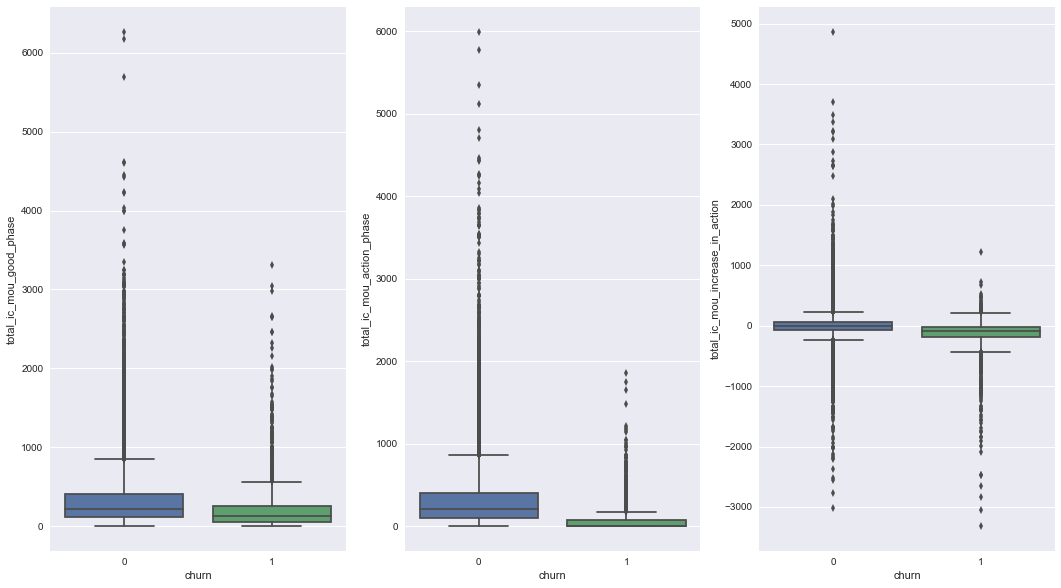

In [79]:
# plot the distribution of values
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
sns.boxplot(x='churn', y='total_ic_mou_good_phase', data=telecom)

plt.subplot(1,3,2)
sns.boxplot(x='churn', y='total_ic_mou_action_phase', data=telecom)

plt.subplot(1,3,3)
sns.boxplot(x='churn', y='total_ic_mou_increase_in_action', data=telecom)

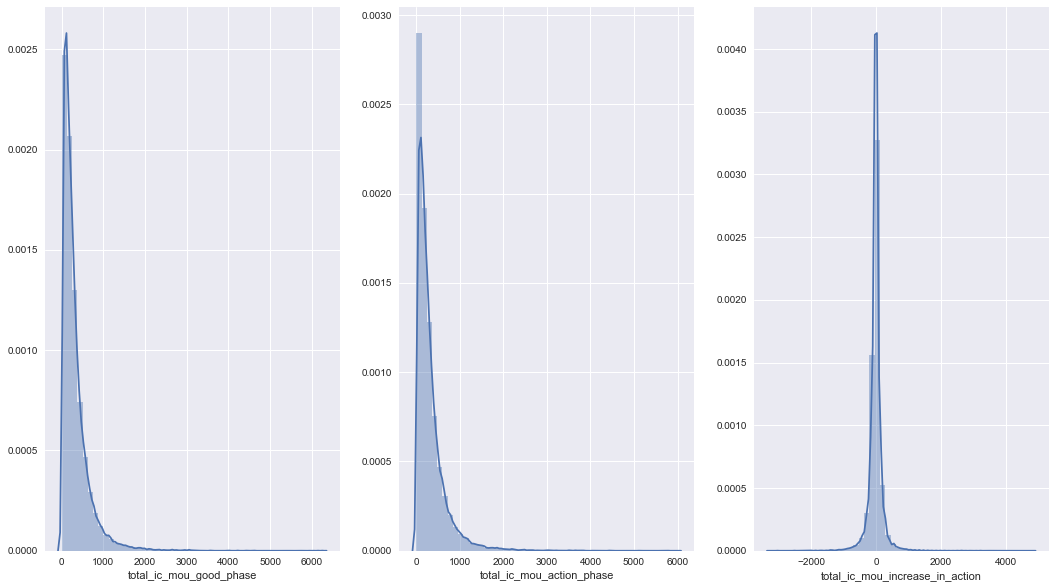

In [80]:
# plot the distributions
plt.figure(figsize=(18,10))
plt.subplot(1,3,1)
sns.distplot(telecom.total_ic_mou_good_phase)

plt.subplot(1,3,2)
sns.distplot(telecom.total_ic_mou_action_phase)

plt.subplot(1,3,3)
sns.distplot(telecom.total_ic_mou_increase_in_action)

<Figure size 1296x720 with 0 Axes>

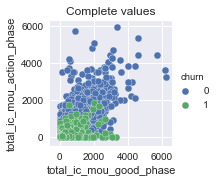

Text(0.5,1,'After Removing high values')

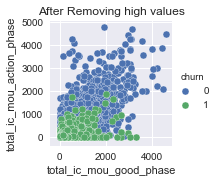

In [81]:
# check for outliers
plt.figure(figsize=(18,10))
sns.pairplot(data=telecom,hue='churn',x_vars=['total_ic_mou_good_phase'],y_vars=['total_ic_mou_action_phase'])
plt.title("Complete values")
plt.show()

# plot the distribution after removing total_ic_mou_good_phase > 5000 and total_ic_mou_action_phase > 5000
sns.pairplot(data=telecom[(telecom.total_ic_mou_good_phase<=5000) & 
                          (telecom.total_ic_mou_action_phase<=5000)],
             hue='churn',
             x_vars=['total_ic_mou_good_phase'],y_vars=['total_ic_mou_action_phase'])
plt.title("After Removing high values")

From above plot, it is clear that outliers on incoming minutes of usage are non churners. So it is safe to delete these rows. 

In [82]:
# drop rows with total_ic_mou_good_phase > 5000 and total_ic_mou_action_phase > 5000
print("Shape before dropping", telecom.shape)
telecom.drop(telecom[(telecom.total_ic_mou_good_phase>5000) | (telecom.total_ic_mou_action_phase>5000)].index,
                    axis=0, inplace=True)

print("Shape after dropping", telecom.shape)

Shape before dropping (30007, 141)
Shape after dropping (30000, 141)


In [83]:
# check for missing values
telecom[['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8',
         'std_ic_mou_6','std_ic_mou_7','std_ic_mou_8',
         'roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8',
         'spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8',
         'isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8',
         'ic_others_6','ic_others_7','ic_others_8'
        ]].isnull().sum()

loc_ic_mou_6     316
loc_ic_mou_7     303
loc_ic_mou_8     938
std_ic_mou_6     316
std_ic_mou_7     303
std_ic_mou_8     938
roam_ic_mou_6    316
roam_ic_mou_7    303
roam_ic_mou_8    938
spl_ic_mou_6     316
spl_ic_mou_7     303
spl_ic_mou_8     938
isd_ic_mou_6     316
isd_ic_mou_7     303
isd_ic_mou_8     938
ic_others_6      316
ic_others_7      303
ic_others_8      938
dtype: int64

In [84]:
# fill na with zero before taking average, as na represents there are no incoming voice calls.
telecom[['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8',
         'std_ic_mou_6','std_ic_mou_7','std_ic_mou_8',
         'roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8',
         'spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8',
         'isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8',
         'ic_others_6','ic_others_7','ic_others_8']] = telecom[['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8',
                                                                 'std_ic_mou_6','std_ic_mou_7','std_ic_mou_8',
                                                                'roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8',
                                                                'spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8',
                                                                'isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8',
                                                                'ic_others_6','ic_others_7','ic_others_8']].fillna(value=0)

In [85]:
telecom[['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8',
         'std_ic_mou_6','std_ic_mou_7','std_ic_mou_8',
         'roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8',
         'spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8',
         'isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8',
         'ic_others_6','ic_others_7','ic_others_8'
        ]].isnull().sum()

loc_ic_mou_6     0
loc_ic_mou_7     0
loc_ic_mou_8     0
std_ic_mou_6     0
std_ic_mou_7     0
std_ic_mou_8     0
roam_ic_mou_6    0
roam_ic_mou_7    0
roam_ic_mou_8    0
spl_ic_mou_6     0
spl_ic_mou_7     0
spl_ic_mou_8     0
isd_ic_mou_6     0
isd_ic_mou_7     0
isd_ic_mou_8     0
ic_others_6      0
ic_others_7      0
ic_others_8      0
dtype: int64

In [86]:
# create new columns for good phase [average of 6th and 7th month] and action phase [8th month]
telecom['loc_ic_mou_good_phase'] = (telecom.loc_ic_mou_6 + telecom.loc_ic_mou_7) / 2
telecom['loc_ic_mou_action_phase'] = telecom.loc_ic_mou_8

telecom['std_ic_mou_good_phase'] = (telecom.std_ic_mou_6 + telecom.std_ic_mou_7) / 2
telecom['std_ic_mou_action_phase'] = telecom.std_ic_mou_8

telecom['roam_ic_mou_good_phase'] = (telecom.roam_ic_mou_6 + telecom.roam_ic_mou_7) / 2
telecom['roam_ic_mou_action_phase'] = telecom.roam_ic_mou_8

telecom['spl_ic_mou_good_phase'] = (telecom.spl_ic_mou_6 + telecom.spl_ic_mou_7) / 2
telecom['spl_ic_mou_action_phase'] = telecom.spl_ic_mou_8

telecom['isd_ic_mou_good_phase'] = (telecom.isd_ic_mou_6 + telecom.isd_ic_mou_7) / 2
telecom['isd_ic_mou_action_phase'] = telecom.isd_ic_mou_8

telecom['ic_others_good_phase'] = (telecom.ic_others_6 + telecom.ic_others_7) / 2
telecom['ic_others_action_phase'] = telecom.ic_others_8

# drop the original variables
telecom.drop(['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8'],axis=1, inplace=True)
telecom.drop(['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8'],axis=1, inplace=True)
telecom.drop(['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8'],axis=1, inplace=True)
telecom.drop(['spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8'],axis=1, inplace=True)
telecom.drop(['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8'],axis=1, inplace=True)
telecom.drop(['ic_others_6','ic_others_7','ic_others_8'],axis=1, inplace=True)

In [87]:
# check the distributions
telecom[['loc_ic_mou_good_phase','loc_ic_mou_action_phase',
         'std_ic_mou_good_phase','std_ic_mou_action_phase',
         'roam_ic_mou_good_phase','roam_ic_mou_action_phase',
         'spl_ic_mou_good_phase','spl_ic_mou_action_phase',
         'isd_ic_mou_good_phase','isd_ic_mou_action_phase',
         'ic_others_good_phase','ic_others_action_phase'
        ]].describe()

,loc_ic_mou_good_phase,loc_ic_mou_action_phase,std_ic_mou_good_phase,std_ic_mou_action_phase,roam_ic_mou_good_phase,roam_ic_mou_action_phase,spl_ic_mou_good_phase,spl_ic_mou_action_phase,isd_ic_mou_good_phase,isd_ic_mou_action_phase,ic_others_good_phase,ic_others_action_phase
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,245.476149,233.851595,51.714943,47.584838,15.469414,13.257206,0.042408,0.027663,11.738882,11.678055,1.333041,1.237964
std,296.059051,303.472041,125.834898,130.923471,67.379594,74.562957,0.152477,0.116590,67.142775,74.869035,13.399188,12.892177
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,65.943750,50.020000,4.810000,1.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,156.355000,142.840000,18.265000,12.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,315.837500,302.080000,50.017500,43.410000,3.056250,0.000000,0.000000,0.000000,0.791250,0.000000,0.250000,0.060000
max,4561.460000,4652.790000,3691.480000,3777.940000,3060.600000,4169.810000,16.610000,6.230000,3811.385000,4100.380000,1420.040000,1209.860000


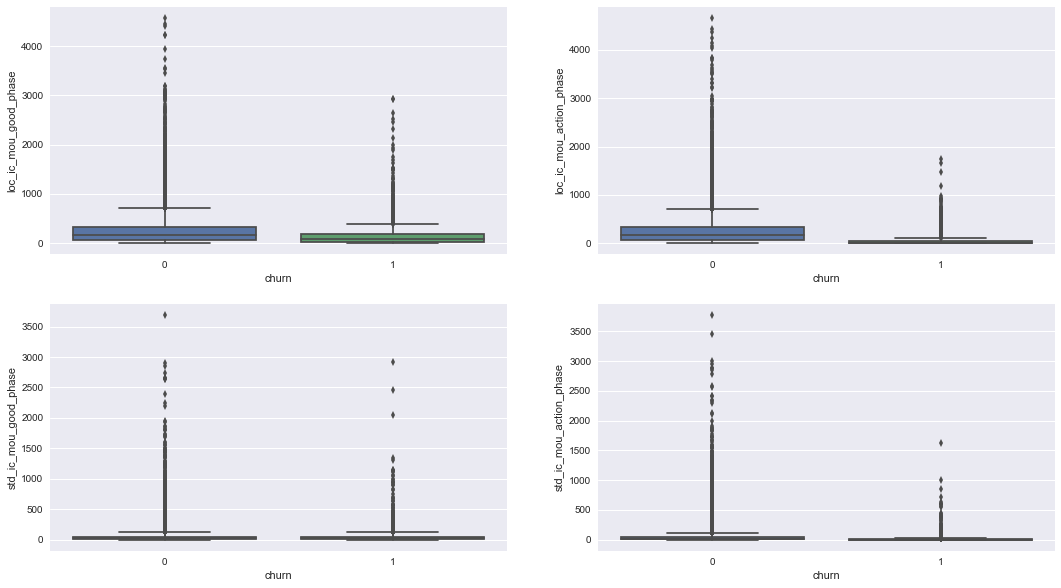

In [88]:
# plot the distribution of values
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
sns.boxplot(x='churn', y='loc_ic_mou_good_phase', data=telecom)

plt.subplot(2,2,2)
sns.boxplot(x='churn', y='loc_ic_mou_action_phase', data=telecom)

plt.subplot(2,2,3)
sns.boxplot(x='churn', y='std_ic_mou_good_phase', data=telecom)

plt.subplot(2,2,4)
sns.boxplot(x='churn', y='std_ic_mou_action_phase', data=telecom)

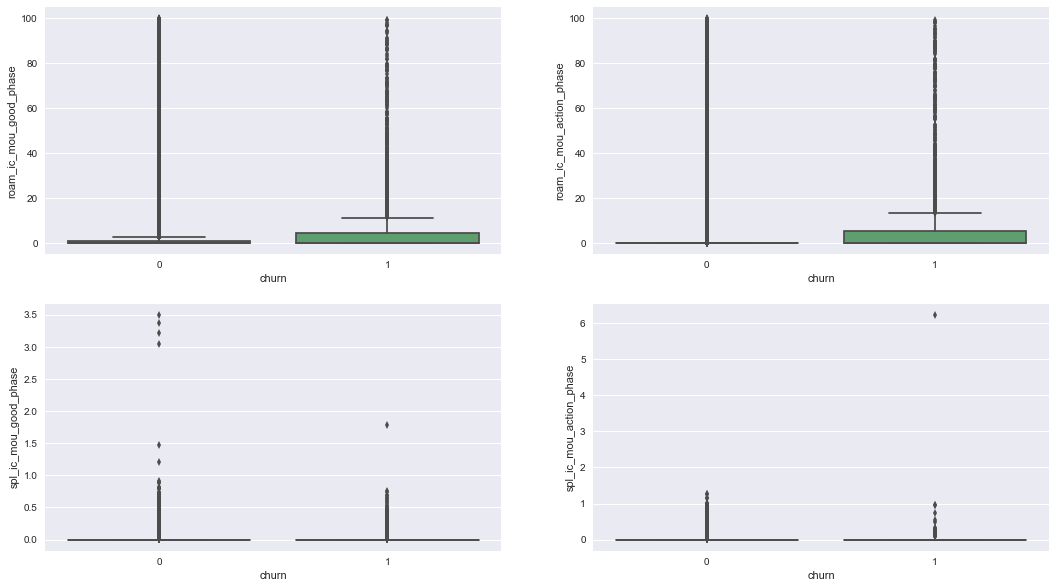

In [89]:
# plot the distribution of values
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
sns.boxplot(x='churn', y='roam_ic_mou_good_phase', data=telecom[telecom.roam_ic_mou_good_phase<100])

plt.subplot(2,2,2)
sns.boxplot(x='churn', y='roam_ic_mou_action_phase', data=telecom[telecom.roam_ic_mou_action_phase<100])

plt.subplot(2,2,3)
sns.boxplot(x='churn', y='spl_ic_mou_good_phase', data=telecom[telecom.spl_ic_mou_good_phase<10])

plt.subplot(2,2,4)
sns.boxplot(x='churn', y='spl_ic_mou_action_phase', data=telecom[telecom.spl_ic_mou_good_phase<10])

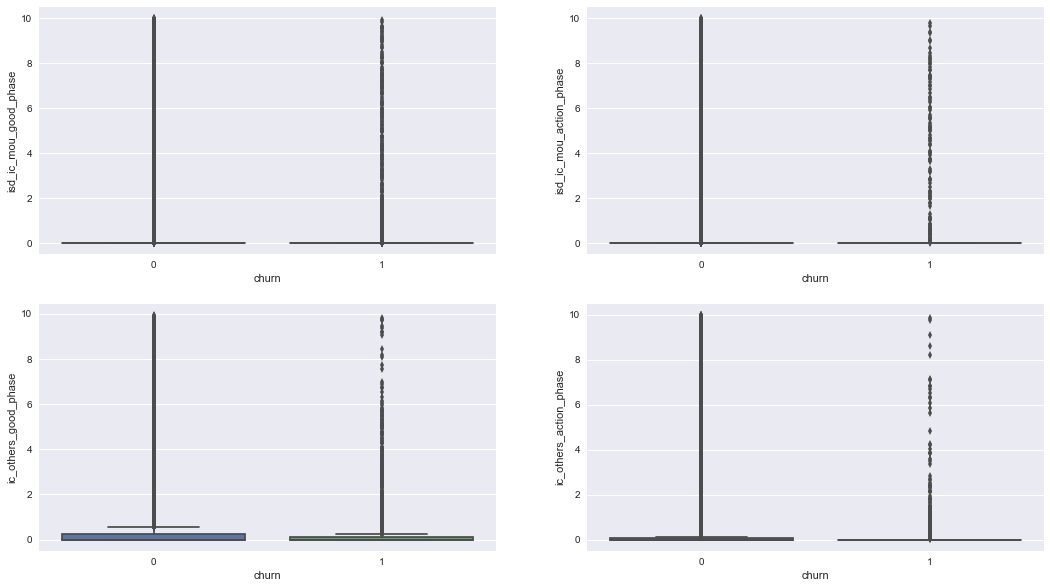

In [90]:
# plot the distribution of values
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
sns.boxplot(x='churn', y='isd_ic_mou_good_phase', data=telecom[telecom.isd_ic_mou_good_phase<10])

plt.subplot(2,2,2)
sns.boxplot(x='churn', y='isd_ic_mou_action_phase', data=telecom[telecom.isd_ic_mou_action_phase<10])

plt.subplot(2,2,3)
sns.boxplot(x='churn', y='ic_others_good_phase', data=telecom[telecom.ic_others_good_phase<10])

plt.subplot(2,2,4)
sns.boxplot(x='churn', y='ic_others_action_phase', data=telecom[telecom.ic_others_action_phase<10])

In [91]:
#Checking for missing values 
telecom[['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8',
         'loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8',
         'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8'
        ]].isnull().sum()

loc_ic_t2t_mou_6    316
loc_ic_t2t_mou_7    303
loc_ic_t2t_mou_8    938
loc_ic_t2m_mou_6    316
loc_ic_t2m_mou_7    303
loc_ic_t2m_mou_8    938
loc_ic_t2f_mou_6    316
loc_ic_t2f_mou_7    303
loc_ic_t2f_mou_8    938
dtype: int64

In [92]:
#treating null values with zero before taking average
telecom[['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7',
         'loc_ic_t2t_mou_8','loc_ic_t2m_mou_6',
         'loc_ic_t2m_mou_7','loc_ic_t2m_mou_8',
         'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7',
         'loc_ic_t2f_mou_8']] = telecom[['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7',
                                         'loc_ic_t2t_mou_8','loc_ic_t2m_mou_6',
                                         'loc_ic_t2m_mou_7','loc_ic_t2m_mou_8',
                                         'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7',
                                         'loc_ic_t2f_mou_8']].fillna(value=0)

In [93]:
#Checking for missing values 
telecom[['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8',
         'loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8',
         'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8'
        ]].isnull().sum()

loc_ic_t2t_mou_6    0
loc_ic_t2t_mou_7    0
loc_ic_t2t_mou_8    0
loc_ic_t2m_mou_6    0
loc_ic_t2m_mou_7    0
loc_ic_t2m_mou_8    0
loc_ic_t2f_mou_6    0
loc_ic_t2f_mou_7    0
loc_ic_t2f_mou_8    0
dtype: int64

In [94]:
# create new columns for good phase, action phase
telecom['loc_ic_t2t_mou_good_phase'] = (telecom.loc_ic_t2t_mou_6 + telecom.loc_ic_t2t_mou_7) / 2
telecom['loc_ic_t2t_mou_action_phase'] = telecom.loc_ic_t2t_mou_8

telecom['loc_ic_t2m_mou_good_phase'] = (telecom.loc_ic_t2m_mou_6 + telecom.loc_ic_t2m_mou_7) / 2
telecom['loc_ic_t2m_mou_action_phase'] = telecom.loc_ic_t2m_mou_8

telecom['loc_ic_t2f_mou_good_phase'] = (telecom.loc_ic_t2f_mou_6 + telecom.loc_ic_t2f_mou_7) / 2
telecom['loc_ic_t2f_mou_action_phase'] = telecom.loc_ic_t2f_mou_8

#drop the original variables
telecom.drop(['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8',
              'loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8',
              'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8'],axis=1,inplace=True)

In [95]:
# check the distributions of new columns
telecom[['loc_ic_t2t_mou_good_phase','loc_ic_t2t_mou_action_phase',
         'loc_ic_t2m_mou_good_phase','loc_ic_t2m_mou_action_phase',
         'loc_ic_t2f_mou_good_phase','loc_ic_t2f_mou_action_phase'
        ]].describe()

,loc_ic_t2t_mou_good_phase,loc_ic_t2t_mou_action_phase,loc_ic_t2m_mou_good_phase,loc_ic_t2m_mou_action_phase,loc_ic_t2f_mou_good_phase,loc_ic_t2f_mou_action_phase
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,69.338921,65.858368,160.074831,153.274080,16.052476,14.709565
std,150.431081,154.987160,207.402224,212.621523,44.594310,43.721472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.133750,6.810000,40.043750,29.680000,0.205000,0.000000
50%,31.670000,26.840000,98.412500,89.820000,2.815000,1.850000
75%,74.556250,70.330000,202.447500,196.960000,13.463750,11.602500
max,4015.490000,4003.210000,4432.685000,4643.490000,1358.435000,1588.530000


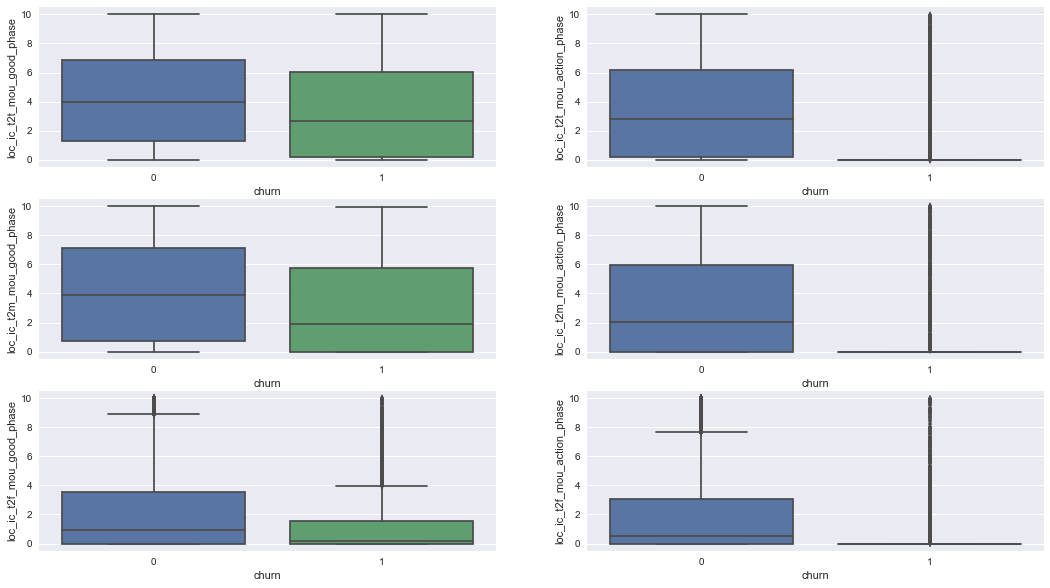

In [96]:
# plot the distribution of values
plt.figure(figsize=(18,10))
plt.subplot(3,2,1)
sns.boxplot(x='churn', y='loc_ic_t2t_mou_good_phase', data=telecom[telecom.loc_ic_t2t_mou_good_phase<10])

plt.subplot(3,2,2)
sns.boxplot(x='churn', y='loc_ic_t2t_mou_action_phase', data=telecom[telecom.loc_ic_t2t_mou_action_phase<10])

plt.subplot(3,2,3)
sns.boxplot(x='churn', y='loc_ic_t2m_mou_good_phase', data=telecom[telecom.loc_ic_t2m_mou_good_phase<10])

plt.subplot(3,2,4)
sns.boxplot(x='churn', y='loc_ic_t2m_mou_action_phase', data=telecom[telecom.loc_ic_t2m_mou_action_phase<10])

plt.subplot(3,2,5)
sns.boxplot(x='churn', y='loc_ic_t2f_mou_good_phase', data=telecom[telecom.loc_ic_t2f_mou_good_phase<10])

plt.subplot(3,2,6)
sns.boxplot(x='churn', y='loc_ic_t2f_mou_action_phase', data=telecom[telecom.loc_ic_t2f_mou_action_phase<10])

In [97]:
#Checking for missing values 
telecom[['std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8',
         'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8',
         'std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8'
        ]].isnull().sum()

std_ic_t2t_mou_6    316
std_ic_t2t_mou_7    303
std_ic_t2t_mou_8    938
std_ic_t2m_mou_6    316
std_ic_t2m_mou_7    303
std_ic_t2m_mou_8    938
std_ic_t2f_mou_6    316
std_ic_t2f_mou_7    303
std_ic_t2f_mou_8    938
dtype: int64

In [98]:
#treating null values with zero before taking average since all null values represent there have not used voice service (=0)
telecom['std_ic_t2t_mou_6']=telecom.std_ic_t2t_mou_6.fillna(0)
telecom['std_ic_t2t_mou_7']=telecom.std_ic_t2t_mou_7.fillna(0)
telecom['std_ic_t2t_mou_8']=telecom.std_ic_t2t_mou_8.fillna(0)
telecom['std_ic_t2m_mou_6']=telecom.std_ic_t2m_mou_6.fillna(0)
telecom['std_ic_t2m_mou_7']=telecom.std_ic_t2m_mou_7.fillna(0)
telecom['std_ic_t2m_mou_8']=telecom.std_ic_t2m_mou_8.fillna(0)
telecom['std_ic_t2f_mou_6']=telecom.std_ic_t2f_mou_6.fillna(0)
telecom['std_ic_t2f_mou_7']=telecom.std_ic_t2f_mou_7.fillna(0)
telecom['std_ic_t2f_mou_8']=telecom.std_ic_t2f_mou_8.fillna(0)


In [99]:
telecom[['std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8',
         'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8',
         'std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8'
        ]].isnull().sum()

std_ic_t2t_mou_6    0
std_ic_t2t_mou_7    0
std_ic_t2t_mou_8    0
std_ic_t2m_mou_6    0
std_ic_t2m_mou_7    0
std_ic_t2m_mou_8    0
std_ic_t2f_mou_6    0
std_ic_t2f_mou_7    0
std_ic_t2f_mou_8    0
dtype: int64

In [100]:
# create new columns for good phase [average of 6th and 7th month], action phase [8th month]
telecom['std_ic_t2t_mou_good_phase'] = (telecom.std_ic_t2t_mou_6 + telecom.std_ic_t2t_mou_7) / 2
telecom['std_ic_t2t_mou_action_phase'] = telecom.std_ic_t2t_mou_8

telecom['std_ic_t2m_mou_good_phase'] = (telecom.std_ic_t2m_mou_6 + telecom.std_ic_t2m_mou_7) / 2
telecom['std_ic_t2m_mou_action_phase'] = telecom.std_ic_t2m_mou_8

telecom['std_ic_t2f_mou_good_phase'] = (telecom.std_ic_t2f_mou_6 + telecom.std_ic_t2f_mou_7) / 2
telecom['std_ic_t2f_mou_action_phase'] = telecom.std_ic_t2f_mou_8

#drop the original variables
telecom.drop(['std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8',
              'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8',
              'std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8'],axis=1,inplace=True)

In [101]:
# check for distributions of values
telecom[['std_ic_t2t_mou_good_phase','std_ic_t2t_mou_action_phase',
         'std_ic_t2m_mou_good_phase','std_ic_t2m_mou_action_phase',
         'std_ic_t2f_mou_good_phase','std_ic_t2f_mou_action_phase'
        ]].describe()

,std_ic_t2t_mou_good_phase,std_ic_t2t_mou_action_phase,std_ic_t2m_mou_good_phase,std_ic_t2m_mou_action_phase,std_ic_t2f_mou_good_phase,std_ic_t2f_mou_action_phase
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,16.244579,14.869455,32.531968,30.030744,2.934389,2.680899
std,65.510447,67.866944,92.647601,96.054455,18.807455,20.272917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.663750,0.000000,0.000000,0.000000
50%,2.340000,0.560000,9.200000,5.710000,0.000000,0.000000
75%,11.805000,8.850000,29.851250,25.315000,0.740000,0.130000
max,3636.840000,3423.390000,2690.420000,2948.740000,1185.045000,1394.890000


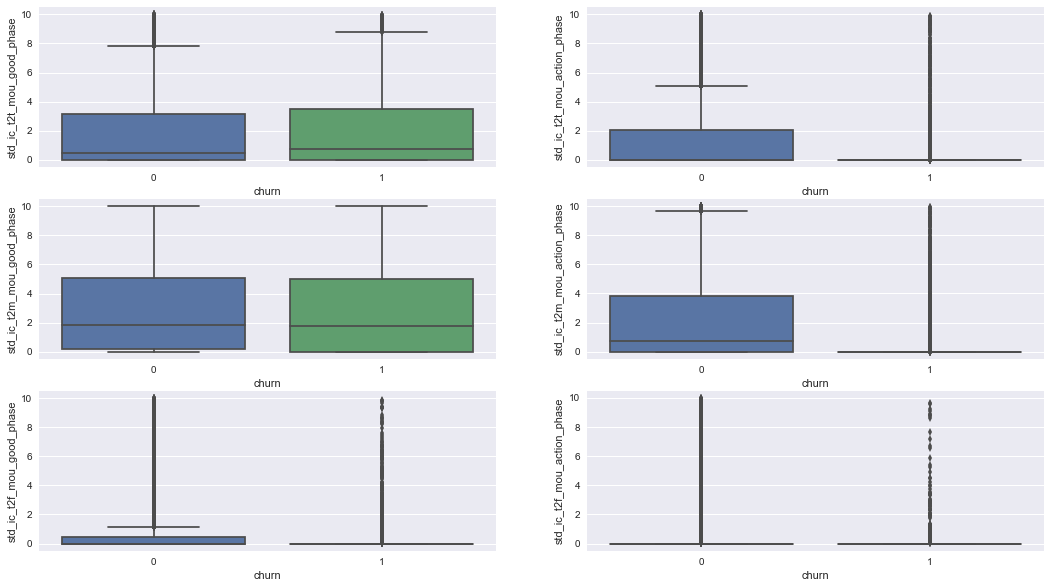

In [102]:
# plot the distribution of values
plt.figure(figsize=(18,10))
plt.subplot(3,2,1)
sns.boxplot(x='churn', y='std_ic_t2t_mou_good_phase', data=telecom[telecom.std_ic_t2t_mou_good_phase<10])

plt.subplot(3,2,2)
sns.boxplot(x='churn', y='std_ic_t2t_mou_action_phase', data=telecom[telecom.std_ic_t2t_mou_action_phase<10])

plt.subplot(3,2,3)
sns.boxplot(x='churn', y='std_ic_t2m_mou_good_phase', data=telecom[telecom.std_ic_t2m_mou_good_phase<10])

plt.subplot(3,2,4)
sns.boxplot(x='churn', y='std_ic_t2m_mou_action_phase', data=telecom[telecom.std_ic_t2m_mou_action_phase<10])

plt.subplot(3,2,5)
sns.boxplot(x='churn', y='std_ic_t2f_mou_good_phase', data=telecom[telecom.std_ic_t2f_mou_good_phase<10])

plt.subplot(3,2,6)
sns.boxplot(x='churn', y='std_ic_t2f_mou_action_phase', data=telecom[telecom.std_ic_t2f_mou_action_phase<10])

<b> Observations: </b>
    1. More incoming calls within the same network or other mobile network in the good phase than the action phase.
    2. Incoming calls has a significant decrease in action phase for churns
    3. Roaming incoming calls has as significant increase in action phase for churns

### Consider all columns related to outgoing calls

In [103]:
telecom.filter(like='og',axis=1).columns

Index(['roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6', 'loc_og_mou_7',
       'loc_og_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7', 'std_og_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8'],
      dtype='object')

In [104]:
# check the columns for total_og_mou
telecom[['total_og_mou_6','total_og_mou_7','total_og_mou_8']].describe()

,total_og_mou_6,total_og_mou_7,total_og_mou_8
count,30000.000000,30000.000000,30000.000000
mean,686.261339,708.706187,623.384220
std,659.328924,684.050293,685.148938
min,0.000000,0.000000,0.000000
25%,266.175000,275.052500,188.647500
50%,510.120000,525.415000,435.220000
75%,898.860000,930.940000,832.630000
max,10674.030000,11365.310000,14043.060000


In [105]:
# check for outliers
telecom[['total_og_mou_6','total_og_mou_7','total_og_mou_8']].describe(percentiles=[.25,.5,.75,.90,.99])

,total_og_mou_6,total_og_mou_7,total_og_mou_8
count,30000.000000,30000.000000,30000.000000
mean,686.261339,708.706187,623.384220
std,659.328924,684.050293,685.148938
min,0.000000,0.000000,0.000000
25%,266.175000,275.052500,188.647500
50%,510.120000,525.415000,435.220000
75%,898.860000,930.940000,832.630000
90%,1457.738000,1493.831000,1391.605000
99%,3213.331300,3281.000700,3247.663000
max,10674.030000,11365.310000,14043.060000


,total_og_mou_6,total_og_mou_7,total_og_mou_8,churn
2505,10674.03,2615.14,11046.74,0
55040,8488.36,5938.46,0.00,1


,total_og_mou_6,total_og_mou_7,total_og_mou_8,churn
2505,10674.03,2615.14,11046.74,0


Text(0.5,1,'After removing high values')

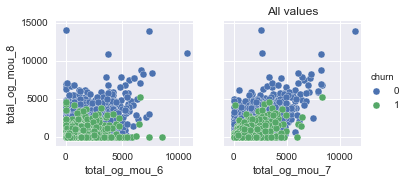

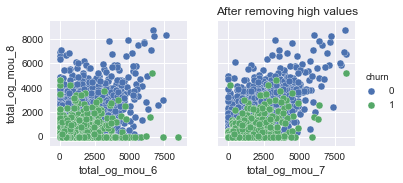

In [106]:
# understand the high values in total_og_mou
display(telecom[telecom.total_og_mou_6>8000][['total_og_mou_6','total_og_mou_7','total_og_mou_8','churn']])
display(telecom[telecom.total_og_mou_6>10000][['total_og_mou_6','total_og_mou_7','total_og_mou_8','churn']])

# there is one value greater than 10000 which is non-churn. 
# plot the distribution

sns.pairplot(data=telecom, hue='churn', x_vars=['total_og_mou_6','total_og_mou_7'], y_vars=['total_og_mou_8'])
plt.title("All values")

# plot the distribution after removing high values
sns.pairplot(data=telecom[(telecom.total_og_mou_6<=10000) & (telecom.total_og_mou_7<=10000) & (telecom.total_og_mou_8<=10000)],
             hue='churn', x_vars=['total_og_mou_6','total_og_mou_7'], y_vars=['total_og_mou_8'])
plt.title("After removing high values")

<b>From above plot, it is clear that all outliers on outgoing minutes of usage are non churners. So it is safe to delete them. </b>

In [107]:
# drop the high values in total_og_mou
print("Shape before dropping",telecom.shape)
telecom.drop(telecom[(telecom.total_og_mou_6>10000) | 
                     (telecom.total_og_mou_7>10000) | 
                     (telecom.total_og_mou_8>10000)].index, axis=0, inplace=True)
print("Shape after dropping",telecom.shape)

Shape before dropping (30000, 129)
Shape after dropping (29996, 129)


In [108]:
# check for missing values
telecom[['total_og_mou_6','total_og_mou_7','total_og_mou_8']].isnull().sum()

total_og_mou_6    0
total_og_mou_7    0
total_og_mou_8    0
dtype: int64

In [109]:
# create new columns for good phase and action phase
telecom['total_og_mou_good_phase'] = (telecom.total_og_mou_6 + telecom.total_og_mou_7) / 2
telecom['total_og_mou_action_phase'] = telecom.total_og_mou_8

telecom['total_og_mou_decrease_in_action'] = telecom.total_og_mou_good_phase - telecom.total_og_mou_action_phase

# drop the original variables
telecom.drop(['total_og_mou_6','total_og_mou_7','total_og_mou_8'],axis=1, inplace=True)

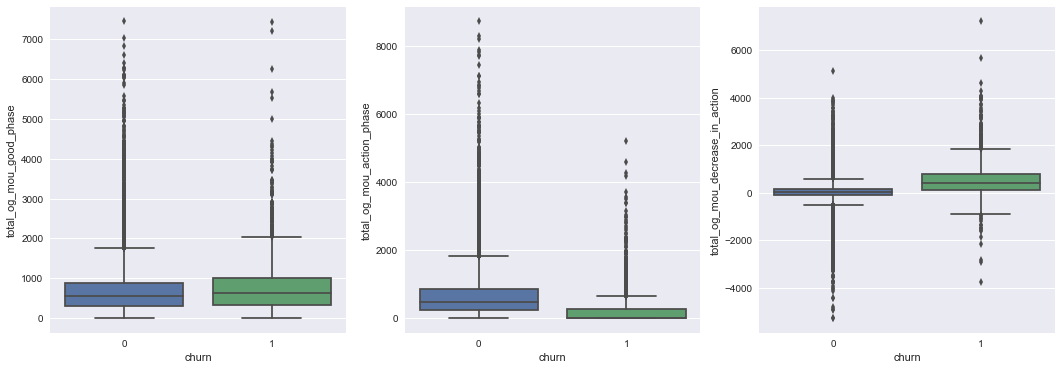

In [110]:
# plot the distribution of values
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.boxplot(x='churn', y='total_og_mou_good_phase', data=telecom)

plt.subplot(1,3,2)
sns.boxplot(x='churn', y='total_og_mou_action_phase', data=telecom)

plt.subplot(1,3,3)
sns.boxplot(x='churn', y='total_og_mou_decrease_in_action', data=telecom)

In [111]:
#checking missing values
telecom[['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8',
         'std_og_mou_6','std_og_mou_7','std_og_mou_8',
         'roam_og_mou_6','roam_og_mou_7','roam_og_mou_8',
         'spl_og_mou_6','spl_og_mou_7','spl_og_mou_8',
         'isd_og_mou_6','isd_og_mou_7','isd_og_mou_8'
        ]].isnull().sum()

loc_og_mou_6     316
loc_og_mou_7     303
loc_og_mou_8     938
std_og_mou_6     316
std_og_mou_7     303
std_og_mou_8     938
roam_og_mou_6    316
roam_og_mou_7    303
roam_og_mou_8    938
spl_og_mou_6     316
spl_og_mou_7     303
spl_og_mou_8     938
isd_og_mou_6     316
isd_og_mou_7     303
isd_og_mou_8     938
dtype: int64

In [112]:
#Treating na with 0 before taking average, as na represents no usage ofoutgoing calls 
telecom['loc_og_mou_6']=telecom.loc_og_mou_6.fillna(0)
telecom['loc_og_mou_7']=telecom.loc_og_mou_7.fillna(0)
telecom['loc_og_mou_8']=telecom.loc_og_mou_8.fillna(0)
telecom['std_og_mou_6']=telecom.std_og_mou_6.fillna(0)
telecom['std_og_mou_7']=telecom.std_og_mou_7.fillna(0)
telecom['std_og_mou_8']=telecom.std_og_mou_8.fillna(0)
telecom['roam_og_mou_6']=telecom.roam_og_mou_6.fillna(0)
telecom['roam_og_mou_7']=telecom.roam_og_mou_7.fillna(0)
telecom['roam_og_mou_8']=telecom.roam_og_mou_8.fillna(0)
telecom['spl_og_mou_6']=telecom.spl_og_mou_6.fillna(0)
telecom['spl_og_mou_7']=telecom.spl_og_mou_7.fillna(0)
telecom['spl_og_mou_8']=telecom.spl_og_mou_8.fillna(0)
telecom['isd_og_mou_6']=telecom.isd_og_mou_6.fillna(0)
telecom['isd_og_mou_7']=telecom.isd_og_mou_7.fillna(0)
telecom['isd_og_mou_8']=telecom.isd_og_mou_8.fillna(0)
telecom['og_others_6']=telecom.og_others_6.fillna(0)
telecom['og_others_7']=telecom.og_others_7.fillna(0)
telecom['og_others_8']=telecom.og_others_8.fillna(0)



In [113]:
# create new columns for good phase and action phase 
telecom['loc_og_mou_good_phase'] = (telecom.loc_og_mou_6 + telecom.loc_og_mou_7) / 2
telecom['loc_og_mou_action_phase'] = telecom.loc_og_mou_8
telecom['loc_og_mou_decrease_in_action'] = telecom.loc_og_mou_good_phase - telecom.loc_og_mou_action_phase

telecom['std_og_mou_good_phase'] = (telecom.std_og_mou_6 + telecom.std_og_mou_7) / 2
telecom['std_og_mou_action_phase'] = telecom.std_og_mou_8
telecom['std_og_mou_decrease_in_action'] = telecom.std_og_mou_good_phase - telecom.std_og_mou_action_phase

telecom['roam_og_mou_good_phase'] = (telecom.roam_og_mou_6 + telecom.roam_og_mou_7) / 2
telecom['roam_og_mou_action_phase'] = telecom.roam_og_mou_8
telecom['roam_og_mou_decrease_in_action'] = telecom.roam_og_mou_good_phase - telecom.roam_og_mou_action_phase

telecom['spl_og_mou_good_phase'] = (telecom.spl_og_mou_6 + telecom.spl_og_mou_7) / 2
telecom['spl_og_mou_action_phase'] = telecom.spl_og_mou_8
telecom['spl_og_mou_decrease_in_action'] = telecom.spl_og_mou_good_phase - telecom.spl_og_mou_action_phase

telecom['isd_og_mou_good_phase'] = (telecom.isd_og_mou_6 + telecom.isd_og_mou_7) / 2
telecom['isd_og_mou_action_phase'] = telecom.isd_og_mou_8
telecom['isd_og_mou_decrease_in_action'] = telecom.isd_og_mou_good_phase - telecom.isd_og_mou_action_phase

telecom['og_others_good_phase'] = (telecom.og_others_6 + telecom.og_others_7) / 2
telecom['og_others_action_phase'] = telecom.og_others_8
telecom['og_others_decrease_in_action'] = telecom.og_others_good_phase - telecom.og_others_action_phase

# drop the original variables
telecom.drop(['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8'],axis=1, inplace=True)
telecom.drop(['std_og_mou_6','std_og_mou_7','std_og_mou_8'],axis=1, inplace=True)
telecom.drop(['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8'],axis=1, inplace=True)
telecom.drop(['spl_og_mou_6','spl_og_mou_7','spl_og_mou_8'],axis=1, inplace=True)
telecom.drop(['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8'],axis=1, inplace=True)
telecom.drop(['og_others_6','og_others_7','og_others_8'],axis=1, inplace=True)

In [114]:
# check the distributions
telecom[['loc_og_mou_good_phase','loc_og_mou_action_phase','loc_og_mou_decrease_in_action',
         'std_og_mou_good_phase','std_og_mou_action_phase','std_og_mou_decrease_in_action',
         'roam_og_mou_good_phase','roam_og_mou_action_phase','roam_og_mou_decrease_in_action',
         'spl_og_mou_good_phase','spl_og_mou_action_phase','spl_og_mou_decrease_in_action',
         'isd_og_mou_good_phase','isd_og_mou_action_phase','isd_og_mou_decrease_in_action',
         'og_others_good_phase','og_others_action_phase','og_others_decrease_in_action'
        ]].describe()

,loc_og_mou_good_phase,loc_og_mou_action_phase,loc_og_mou_decrease_in_action,std_og_mou_good_phase,std_og_mou_action_phase,std_og_mou_decrease_in_action,roam_og_mou_good_phase,roam_og_mou_action_phase,roam_og_mou_decrease_in_action,spl_og_mou_good_phase,spl_og_mou_action_phase,spl_og_mou_decrease_in_action,isd_og_mou_good_phase,isd_og_mou_action_phase,isd_og_mou_decrease_in_action,og_others_good_phase,og_others_action_phase,og_others_decrease_in_action
count,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000
mean,283.204019,260.592888,22.611131,404.685379,352.594856,52.090523,25.680570,21.472953,4.207617,6.660060,6.881298,-0.221238,1.872657,1.669948,0.202709,0.369983,0.059161,0.310822
std,354.581910,356.701533,218.000612,572.618749,606.326408,438.488322,94.752765,106.267798,96.345648,18.265274,22.892002,19.938230,20.302664,20.459653,14.251809,1.845695,3.321150,2.894370
min,0.000000,0.000000,-4616.810000,0.000000,0.000000,-6697.385000,0.000000,0.000000,-3057.150000,0.000000,0.000000,-1112.655000,0.000000,0.000000,-544.780000,0.000000,0.000000,-366.590000
25%,61.563750,38.280000,-34.767500,9.525000,1.780000,-19.261250,0.000000,0.000000,0.000000,0.000000,0.000000,-1.426250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,175.572500,148.285000,9.195000,165.105000,72.840000,2.150000,0.000000,0.000000,0.000000,1.730000,0.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,375.140000,348.295000,72.736250,620.263750,480.522500,92.278750,7.275000,0.000000,0.255000,7.030000,6.360000,2.665000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5999.010000,7661.290000,3867.830000,7323.595000,8593.640000,7127.425000,2410.835000,5337.040000,2410.835000,1144.500000,1390.880000,1081.910000,1041.295000,930.960000,619.650000,185.065000,394.930000,99.570000


In [115]:
#checking missing values 
telecom[['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8',
         'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8',
         'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8',
         'loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8'
        ]].isnull().sum()

loc_og_t2t_mou_6    316
loc_og_t2t_mou_7    303
loc_og_t2t_mou_8    938
loc_og_t2m_mou_6    316
loc_og_t2m_mou_7    303
loc_og_t2m_mou_8    938
loc_og_t2f_mou_6    316
loc_og_t2f_mou_7    303
loc_og_t2f_mou_8    938
loc_og_t2c_mou_6    316
loc_og_t2c_mou_7    303
loc_og_t2c_mou_8    938
dtype: int64

In [116]:
telecom['loc_og_t2t_mou_6'] = telecom.loc_og_t2t_mou_6.fillna(0)
telecom['loc_og_t2t_mou_7'] = telecom.loc_og_t2t_mou_7.fillna(0)
telecom['loc_og_t2t_mou_8'] = telecom.loc_og_t2t_mou_8.fillna(0)
telecom['loc_og_t2m_mou_6'] = telecom.loc_og_t2m_mou_6.fillna(0)
telecom['loc_og_t2m_mou_7'] = telecom.loc_og_t2m_mou_7.fillna(0)
telecom['loc_og_t2m_mou_8'] = telecom.loc_og_t2m_mou_8.fillna(0)
telecom['loc_og_t2f_mou_6'] = telecom.loc_og_t2f_mou_6.fillna(0)
telecom['loc_og_t2f_mou_7'] = telecom.loc_og_t2f_mou_7.fillna(0)
telecom['loc_og_t2f_mou_8'] = telecom.loc_og_t2f_mou_8.fillna(0)
telecom['loc_og_t2f_mou_6'] = telecom.loc_og_t2f_mou_6.fillna(0)
telecom['loc_og_t2f_mou_7'] = telecom.loc_og_t2f_mou_7.fillna(0)
telecom['loc_og_t2f_mou_8'] = telecom.loc_og_t2f_mou_8.fillna(0)
telecom['loc_og_t2c_mou_6'] = telecom.loc_og_t2c_mou_6.fillna(0)
telecom['loc_og_t2c_mou_7'] = telecom.loc_og_t2c_mou_7.fillna(0)
telecom['loc_og_t2c_mou_8'] = telecom.loc_og_t2c_mou_8.fillna(0)

In [117]:
# create new columns for good phase, action phase 
telecom['loc_og_t2t_mou_good_phase'] = (telecom.loc_og_t2t_mou_6 + telecom.loc_og_t2t_mou_7) / 2
telecom['loc_og_t2t_mou_action_phase'] = telecom.loc_og_t2t_mou_8
telecom['loc_og_t2t_mou_decrease_in_action'] = telecom.loc_og_t2t_mou_good_phase - telecom.loc_og_t2t_mou_action_phase

telecom['loc_og_t2m_mou_good_phase'] = (telecom.loc_og_t2m_mou_6 + telecom.loc_og_t2m_mou_7) / 2
telecom['loc_og_t2m_mou_action_phase'] = telecom.loc_og_t2m_mou_8
telecom['loc_og_t2m_mou_decrease_in_action'] = telecom.loc_og_t2m_mou_good_phase - telecom.loc_og_t2m_mou_action_phase

telecom['loc_og_t2f_mou_good_phase'] = (telecom.loc_og_t2f_mou_6 + telecom.loc_og_t2f_mou_7) / 2
telecom['loc_og_t2f_mou_action_phase'] = telecom.loc_og_t2f_mou_8
telecom['loc_og_t2f_mou_decrease_in_action'] = telecom.loc_og_t2f_mou_good_phase - telecom.loc_og_t2f_mou_action_phase

telecom['loc_og_t2c_mou_good_phase'] = (telecom.loc_og_t2c_mou_6 + telecom.loc_og_t2c_mou_7) / 2
telecom['loc_og_t2c_mou_action_phase'] = telecom.loc_og_t2c_mou_8
telecom['loc_og_t2c_mou_decrease_in_action'] = telecom.loc_og_t2c_mou_good_phase - telecom.loc_og_t2c_mou_action_phase


#drop the original variables
telecom.drop(['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8',
              'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8',
              'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8',
              'loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8',
             ],axis=1,inplace=True)
              

In [118]:
# check the distributions of new columns
telecom[['loc_og_t2t_mou_good_phase','loc_og_t2t_mou_action_phase','loc_og_t2t_mou_decrease_in_action',
         'loc_og_t2m_mou_good_phase','loc_og_t2m_mou_action_phase','loc_og_t2m_mou_decrease_in_action',
         'loc_og_t2f_mou_good_phase','loc_og_t2f_mou_action_phase','loc_og_t2f_mou_decrease_in_action',
         'loc_og_t2c_mou_good_phase','loc_og_t2c_mou_action_phase','loc_og_t2c_mou_decrease_in_action'
        ]].describe()

,loc_og_t2t_mou_good_phase,loc_og_t2t_mou_action_phase,loc_og_t2t_mou_decrease_in_action,loc_og_t2m_mou_good_phase,loc_og_t2m_mou_action_phase,loc_og_t2m_mou_decrease_in_action,loc_og_t2f_mou_good_phase,loc_og_t2f_mou_action_phase,loc_og_t2f_mou_decrease_in_action,loc_og_t2c_mou_good_phase,loc_og_t2c_mou_action_phase,loc_og_t2c_mou_decrease_in_action
count,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000
mean,94.904171,86.481197,8.422973,181.250023,167.605873,13.644150,7.040937,6.497386,0.543551,1.714296,1.712297,0.001999
std,225.972689,219.561519,136.206820,230.580964,234.897160,152.076733,21.504987,20.224613,14.491293,6.704321,7.398476,7.240556
min,0.000000,0.000000,-4683.965000,0.000000,0.000000,-3158.700000,0.000000,0.000000,-452.720000,0.000000,0.000000,-193.355000
25%,11.340000,5.787500,-10.311250,36.945000,22.430000,-24.931250,0.000000,0.000000,-0.370000,0.000000,0.000000,0.000000
50%,35.420000,28.640000,2.265000,107.265000,89.860000,5.905000,0.855000,0.160000,0.000000,0.000000,0.000000,0.000000
75%,92.952500,84.665000,20.661250,242.270000,223.507500,47.783750,5.625000,4.680000,1.440000,1.040000,0.050000,0.305000
max,5941.565000,7010.740000,3875.375000,4150.165000,4961.330000,2863.535000,1331.230000,928.490000,1319.850000,420.575000,351.830000,384.385000


<Figure size 1440x720 with 0 Axes>

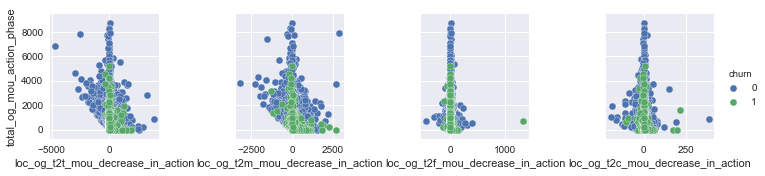

In [119]:
# plot the distribution of values
plt.figure(figsize=(20,10))
sns.pairplot(data=telecom,hue='churn',x_vars=['loc_og_t2t_mou_decrease_in_action',
                                              'loc_og_t2m_mou_decrease_in_action',
                                              'loc_og_t2f_mou_decrease_in_action',
                                              'loc_og_t2c_mou_decrease_in_action'],
                                     y_vars=['total_og_mou_action_phase'])

In [120]:
# check for missing values 
telecom[['std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8',
         'std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8',
         'std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8'
        ]].isnull().sum()

std_og_t2t_mou_6    316
std_og_t2t_mou_7    303
std_og_t2t_mou_8    938
std_og_t2m_mou_6    316
std_og_t2m_mou_7    303
std_og_t2m_mou_8    938
std_og_t2f_mou_6    316
std_og_t2f_mou_7    303
std_og_t2f_mou_8    938
dtype: int64

In [121]:
# filling na with 0, as na represents no usage of std outgoing calls.
telecom['std_og_t2t_mou_6'] = telecom.std_og_t2t_mou_6.fillna(0)
telecom['std_og_t2t_mou_7'] = telecom.std_og_t2t_mou_7.fillna(0)
telecom['std_og_t2t_mou_8'] = telecom.std_og_t2t_mou_8.fillna(0)
telecom['std_og_t2m_mou_6'] = telecom.std_og_t2m_mou_6.fillna(0)
telecom['std_og_t2m_mou_7'] = telecom.std_og_t2m_mou_7.fillna(0)
telecom['std_og_t2m_mou_8'] = telecom.std_og_t2m_mou_8.fillna(0)
telecom['std_og_t2f_mou_6'] = telecom.std_og_t2f_mou_6.fillna(0)
telecom['std_og_t2f_mou_7'] = telecom.std_og_t2f_mou_7.fillna(0)
telecom['std_og_t2f_mou_8'] = telecom.std_og_t2f_mou_8.fillna(0)

In [122]:
# create new columns for good phase, action phase
telecom['std_og_t2t_mou_good_phase'] = (telecom.std_og_t2t_mou_6 + telecom.std_og_t2t_mou_7) / 2
telecom['std_og_t2t_mou_action_phase'] = telecom.std_og_t2t_mou_8
telecom['std_og_t2t_mou_decrease_in_action'] = telecom.std_og_t2t_mou_good_phase - telecom.std_og_t2t_mou_action_phase

telecom['std_og_t2m_mou_good_phase'] = (telecom.std_og_t2m_mou_6 + telecom.std_og_t2m_mou_7) / 2
telecom['std_og_t2m_mou_action_phase'] = telecom.std_og_t2m_mou_8
telecom['std_og_t2m_mou_decrease_in_action'] = telecom.std_og_t2m_mou_good_phase - telecom.std_og_t2m_mou_action_phase

telecom['std_og_t2f_mou_good_phase'] = (telecom.std_og_t2f_mou_6 + telecom.std_og_t2f_mou_7) / 2
telecom['std_og_t2f_mou_action_phase'] = telecom.std_og_t2f_mou_8
telecom['std_og_t2f_mou_decrease_in_action'] = telecom.std_og_t2f_mou_good_phase - telecom.std_og_t2f_mou_action_phase

#drop the original variables
telecom.drop(['std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8',
              'std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8',
              'std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8'],axis=1,inplace=True)

In [123]:
# check for distributions of values
telecom[['std_og_t2t_mou_good_phase','std_og_t2t_mou_action_phase','std_og_t2t_mou_decrease_in_action',
         'std_og_t2m_mou_good_phase','std_og_t2m_mou_action_phase','std_og_t2m_mou_decrease_in_action',
         'std_og_t2f_mou_good_phase','std_og_t2f_mou_action_phase','std_og_t2f_mou_decrease_in_action'
        ]].describe()

,std_og_t2t_mou_good_phase,std_og_t2t_mou_action_phase,std_og_t2t_mou_decrease_in_action,std_og_t2m_mou_good_phase,std_og_t2m_mou_action_phase,std_og_t2m_mou_decrease_in_action,std_og_t2f_mou_good_phase,std_og_t2f_mou_action_phase,std_og_t2f_mou_decrease_in_action
count,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000,29996.000000
mean,194.770923,172.190426,22.580497,207.886952,178.610002,29.276950,2.023175,1.790528,0.232647
std,388.594456,410.046773,286.290064,392.442016,401.885906,302.891677,11.888347,11.703236,8.188440
min,0.000000,0.000000,-4806.465000,0.000000,0.000000,-6706.785000,0.000000,0.000000,-339.250000
25%,0.000000,0.000000,-3.300000,3.753750,0.000000,-9.341250,0.000000,0.000000,0.000000
50%,18.897500,5.930000,0.000000,46.957500,23.640000,1.070000,0.000000,0.000000,0.000000
75%,211.586250,132.795000,24.481250,237.045000,164.640000,41.423750,0.000000,0.000000,0.000000
max,7308.050000,8014.430000,5391.210000,7037.535000,7508.930000,7037.535000,382.920000,516.910000,314.280000


<Figure size 1440x720 with 0 Axes>

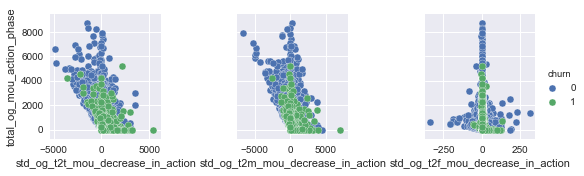

In [124]:
# plot the distribution of values
plt.figure(figsize=(20,10))
sns.pairplot(data=telecom,hue='churn',x_vars=['std_og_t2t_mou_decrease_in_action',
                                              'std_og_t2m_mou_decrease_in_action',
                                              'std_og_t2f_mou_decrease_in_action'],
                                     y_vars=['total_og_mou_action_phase'])

<b> Observations: </b>
    1. Less local outgoing calls in action phase as compared to the good phase
    2. Roaming outgoing calls has as significant increase in action phase for churns

In [125]:
telecom[telecom.filter(like='ic',axis=1).columns].isnull().sum()

voice_only                         0
total_ic_mou_good_phase            0
total_ic_mou_action_phase          0
total_ic_mou_increase_in_action    0
loc_ic_mou_good_phase              0
loc_ic_mou_action_phase            0
std_ic_mou_good_phase              0
std_ic_mou_action_phase            0
roam_ic_mou_good_phase             0
roam_ic_mou_action_phase           0
spl_ic_mou_good_phase              0
spl_ic_mou_action_phase            0
isd_ic_mou_good_phase              0
isd_ic_mou_action_phase            0
ic_others_good_phase               0
ic_others_action_phase             0
loc_ic_t2t_mou_good_phase          0
loc_ic_t2t_mou_action_phase        0
loc_ic_t2m_mou_good_phase          0
loc_ic_t2m_mou_action_phase        0
loc_ic_t2f_mou_good_phase          0
loc_ic_t2f_mou_action_phase        0
std_ic_t2t_mou_good_phase          0
std_ic_t2t_mou_action_phase        0
std_ic_t2m_mou_good_phase          0
std_ic_t2m_mou_action_phase        0
std_ic_t2f_mou_good_phase          0
s

In [126]:
telecom[telecom.filter(like='og',axis=1).columns].isnull().sum()

total_og_mou_good_phase              0
total_og_mou_action_phase            0
total_og_mou_decrease_in_action      0
loc_og_mou_good_phase                0
loc_og_mou_action_phase              0
loc_og_mou_decrease_in_action        0
std_og_mou_good_phase                0
std_og_mou_action_phase              0
std_og_mou_decrease_in_action        0
roam_og_mou_good_phase               0
roam_og_mou_action_phase             0
roam_og_mou_decrease_in_action       0
spl_og_mou_good_phase                0
spl_og_mou_action_phase              0
spl_og_mou_decrease_in_action        0
isd_og_mou_good_phase                0
isd_og_mou_action_phase              0
isd_og_mou_decrease_in_action        0
og_others_good_phase                 0
og_others_action_phase               0
og_others_decrease_in_action         0
loc_og_t2t_mou_good_phase            0
loc_og_t2t_mou_action_phase          0
loc_og_t2t_mou_decrease_in_action    0
loc_og_t2m_mou_good_phase            0
loc_og_t2m_mou_action_pha

### Consider all columns related operator network

In [127]:
# check for distributions of values
telecom[['onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8']].describe()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8
count,29680.000000,29693.000000,29058.000000,29680.000000,29693.000000,29058.000000
mean,298.851363,307.095402,275.556473,421.641251,427.441367,385.782226
std,460.419606,481.112730,464.044720,467.489783,482.285358,465.753435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.980000,42.690000,32.215000,141.375000,139.580000,107.645000
50%,128.335000,127.940000,106.270000,285.945000,285.430000,251.285000
75%,357.082500,364.490000,309.975000,527.152500,536.510000,493.377500
max,7376.710000,8157.780000,8022.980000,8362.360000,8316.360000,7857.780000


In [128]:
# check for missing values
telecom[['onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8']].isnull().sum()

onnet_mou_6     316
onnet_mou_7     303
onnet_mou_8     938
offnet_mou_6    316
offnet_mou_7    303
offnet_mou_8    938
dtype: int64

In [129]:
# create new columns for good phase and action phase and filling missing values with zero, as na represents no usage of onnet calls
telecom['onnet_mou_good_phase'] = (telecom.onnet_mou_6.fillna(0) + telecom.onnet_mou_7.fillna(0)) / 2
telecom['onnet_mou_action_phase'] = telecom['onnet_mou_8'].fillna(0)
telecom['onnet_mou_increase_in_action'] = telecom.onnet_mou_action_phase - telecom.onnet_mou_good_phase

# drop the original variables
telecom.drop(['onnet_mou_6','onnet_mou_7','onnet_mou_8'],axis=1, inplace=True)

In [130]:
# create new columns for good phase and action phase and filling missing values with zero, as na represents no usage of offnet calls
telecom['offnet_mou_good_phase'] = (telecom.offnet_mou_6.fillna(0) + telecom.offnet_mou_7.fillna(0)) / 2
telecom['offnet_mou_action_phase'] = telecom['offnet_mou_8'].fillna(0)

telecom['offnet_mou_increase_in_action'] = telecom.offnet_mou_action_phase - telecom.offnet_mou_good_phase

# drop the original variables
telecom.drop(['offnet_mou_6','offnet_mou_7','offnet_mou_8'],axis=1, inplace=True)

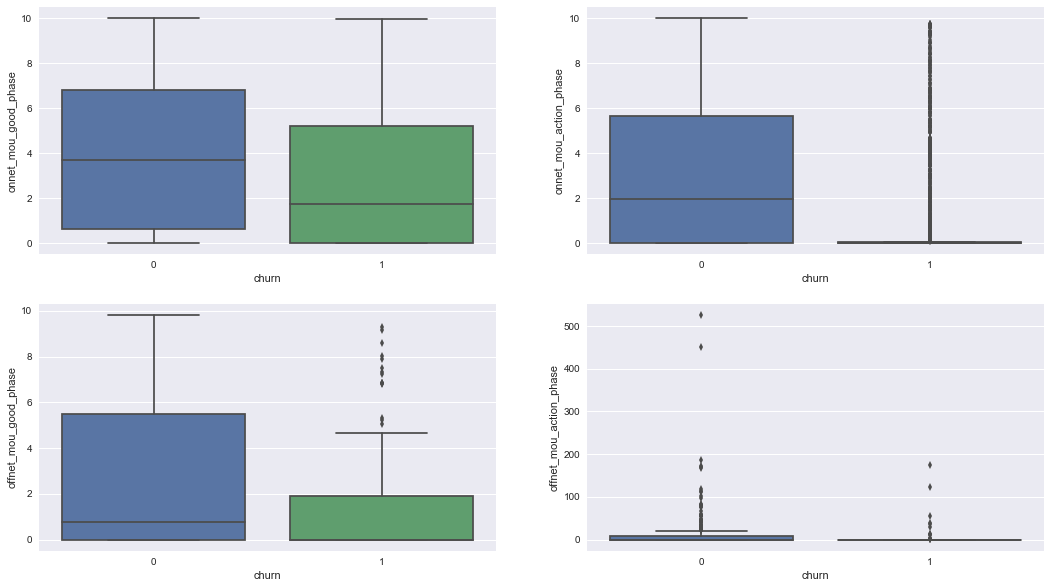

In [131]:
# plot the distribution of values
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
sns.boxplot(x='churn', y='onnet_mou_good_phase', data=telecom[telecom.onnet_mou_good_phase<10])

plt.subplot(2,2,2)
sns.boxplot(x='churn', y='onnet_mou_action_phase', data=telecom[telecom.onnet_mou_action_phase<10])

plt.subplot(2,2,3)
sns.boxplot(x='churn', y='offnet_mou_good_phase', data=telecom[telecom.offnet_mou_good_phase<10])

plt.subplot(2,2,4)
sns.boxplot(x='churn', y='offnet_mou_action_phase', data=telecom[telecom.offnet_mou_good_phase<10])

### Consider all columns related to data packages

In [132]:
# check the columns for total_og_mou
telecom[['night_pck_user_6','night_pck_user_7','night_pck_user_8']].describe()

,night_pck_user_6,night_pck_user_7,night_pck_user_8
count,11392.000000,11660.000000,11749.000000
mean,0.027300,0.025386,0.023747
std,0.162963,0.157301,0.152265
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


In [133]:
# check for missing values
telecom[['night_pck_user_6','night_pck_user_7','night_pck_user_8']].isnull().sum()

night_pck_user_6    18604
night_pck_user_7    18336
night_pck_user_8    18247
dtype: int64

In [134]:
# create new columns for good phase and action phase. Variable good phase is created based on the assumption that customers
# who have not opted for night packs are treated as '0' while customers who have opted for it have been treated as '1'
telecom['night_pck_user_good_phase'] = np.where((telecom.night_pck_user_6==1) | (telecom.night_pck_user_7==1), 1, 0)
telecom['night_pck_user_action_phase'] = np.where((telecom.night_pck_user_8==1),1,0)
telecom['difference_night_pck']= telecom['night_pck_user_good_phase'] - telecom['night_pck_user_action_phase']

# drop the original variables
telecom.drop(['night_pck_user_6','night_pck_user_7','night_pck_user_8'],axis=1, inplace=True)

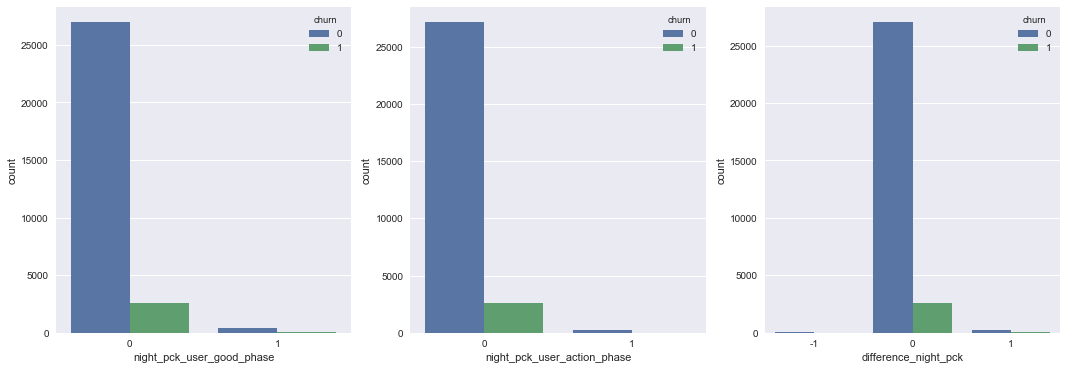

In [135]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.countplot(x='night_pck_user_good_phase',hue='churn',data=telecom)
plt.subplot(1,3,2)
sns.countplot(x='night_pck_user_action_phase',hue='churn',data=telecom)
plt.subplot(1,3,3)
sns.countplot(x='difference_night_pck',hue='churn',data=telecom)

In [136]:
# check the columns for total_og_mou
telecom[['monthly_2g_6','monthly_2g_7','monthly_2g_8']].describe()

,monthly_2g_6,monthly_2g_7,monthly_2g_8
count,29996.000000,29996.000000,29996.000000
mean,0.124917,0.131418,0.114082
std,0.374595,0.387759,0.357316
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,4.000000,5.000000,5.000000


In [137]:
# check for missing values
telecom[['monthly_2g_6','monthly_2g_7','monthly_2g_8']].isnull().sum()

monthly_2g_6    0
monthly_2g_7    0
monthly_2g_8    0
dtype: int64

In [138]:
# create new columns for good phase and action phase
telecom['monthly_2g_good_phase'] = (telecom.monthly_2g_6 + telecom.monthly_2g_7) / 2
telecom['monthly_2g_good_phase']=telecom['monthly_2g_good_phase'].apply(lambda x:round(x,0)).astype(int)
telecom['monthly_2g_action_phase'] = telecom['monthly_2g_8']

# drop the original variables
telecom.drop(['monthly_2g_6','monthly_2g_7','monthly_2g_8'],axis=1, inplace=True)

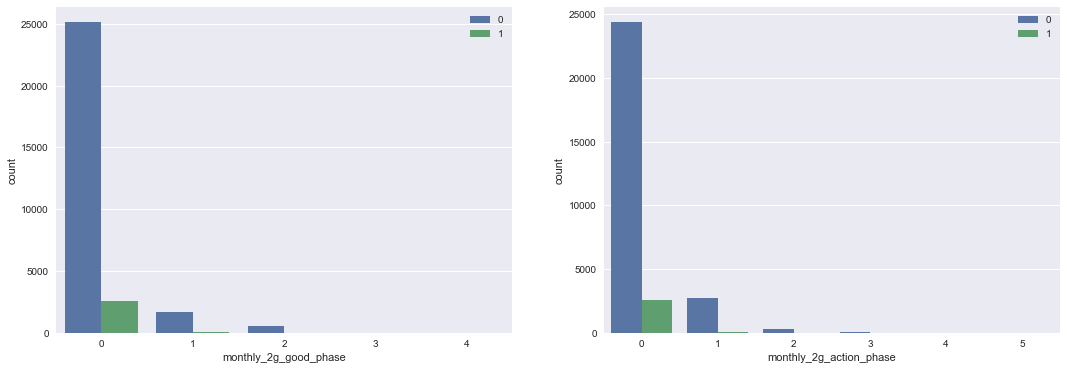

In [139]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.countplot(x='monthly_2g_good_phase',hue='churn',data=telecom)
plt.legend(loc='upper right', frameon=False)
plt.subplot(1,2,2)
sns.countplot(x='monthly_2g_action_phase',hue='churn',data=telecom)
plt.legend(loc='upper right', frameon=False)

In [140]:
# check the columns for total_og_mou
display(telecom[['monthly_3g_6','monthly_3g_7','monthly_3g_8']].describe())

# check for missing values
display(telecom[['monthly_3g_6','monthly_3g_7','monthly_3g_8']].isnull().sum())

# create new columns for good phase and action phase
telecom['monthly_3g_good_phase'] = (telecom.monthly_3g_6 + telecom.monthly_3g_7) / 2
telecom['monthly_3g_good_phase']=telecom['monthly_3g_good_phase'].apply(lambda x:round(x,0)).astype(int)
telecom['monthly_3g_action_phase'] = telecom['monthly_3g_8']

# drop the original variables
telecom.drop(['monthly_3g_6','monthly_3g_7','monthly_3g_8'],axis=1, inplace=True)

,monthly_3g_6,monthly_3g_7,monthly_3g_8
count,29996.000000,29996.000000,29996.000000
mean,0.173957,0.185225,0.173256
std,0.574397,0.620559,0.583046
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,14.000000,16.000000,16.000000


monthly_3g_6    0
monthly_3g_7    0
monthly_3g_8    0
dtype: int64

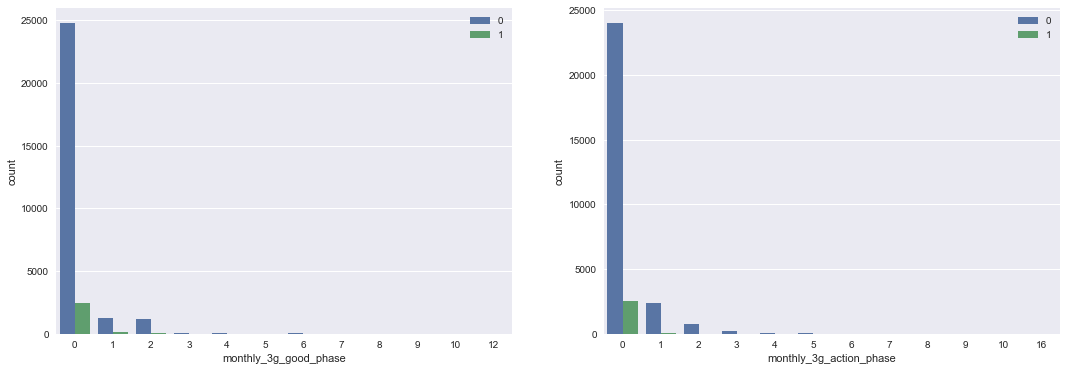

In [141]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.countplot(x='monthly_3g_good_phase',hue='churn',data=telecom)
plt.legend(loc='upper right', frameon=False)
plt.subplot(1,2,2)
sns.countplot(x='monthly_3g_action_phase',hue='churn',data=telecom)
plt.legend(loc='upper right', frameon=False)

In [142]:
# check the columns for total_og_mou
display(telecom[['sachet_2g_6','sachet_2g_7','sachet_2g_8']].describe())

# check for missing values
display(telecom[['sachet_2g_6','sachet_2g_7','sachet_2g_8']].isnull().sum())

# create new columns for good phase and action phase
telecom['sachet_2g_good_phase'] = (telecom.sachet_2g_6 + telecom.sachet_2g_7) / 2
telecom['sachet_2g_good_phase']=telecom['sachet_2g_good_phase'].apply(lambda x:round(x,0)).astype(int)
telecom['sachet_2g_action_phase'] = telecom['sachet_2g_8']

# drop the original variables
telecom.drop(['sachet_2g_6','sachet_2g_7','sachet_2g_8'],axis=1, inplace=True)

,sachet_2g_6,sachet_2g_7,sachet_2g_8
count,29996.000000,29996.000000,29996.000000
mean,0.500200,0.587145,0.607481
std,1.699328,1.900274,1.843886
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,39.000000,48.000000,44.000000


sachet_2g_6    0
sachet_2g_7    0
sachet_2g_8    0
dtype: int64

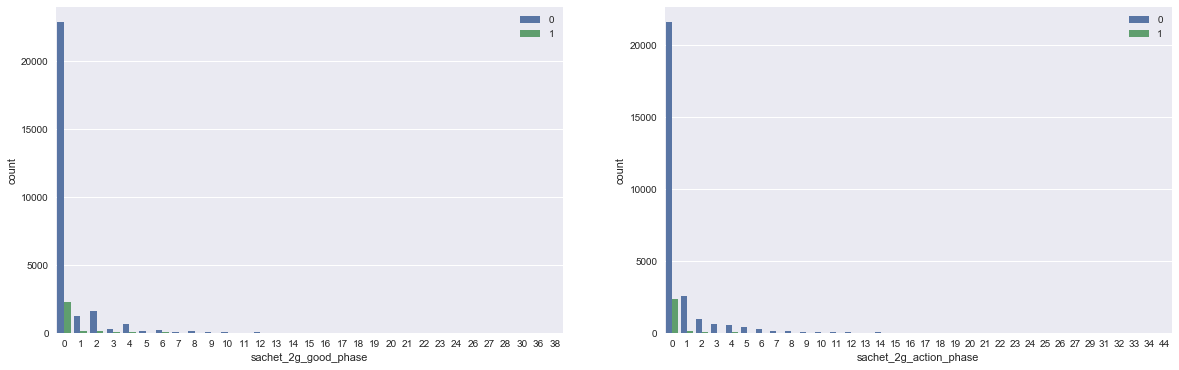

In [143]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.countplot(x='sachet_2g_good_phase',hue='churn',data=telecom)
plt.legend(loc='upper right', frameon=False)
plt.subplot(1,2,2)
sns.countplot(x='sachet_2g_action_phase',hue='churn',data=telecom)
plt.legend(loc='upper right', frameon=False)

In [144]:
# check the columns for total_og_mou
display(telecom[['sachet_3g_6','sachet_3g_7','sachet_3g_8']].describe())

# check for missing values
display(telecom[['sachet_3g_6','sachet_3g_7','sachet_3g_8']].isnull().sum())

# create new columns for good phase [average of 6th and 7th month] and action phase [8th month]
telecom['sachet_3g_good_phase'] = (telecom.sachet_3g_6 + telecom.sachet_3g_7) / 2
telecom['sachet_3g_good_phase']=telecom['sachet_3g_good_phase'].apply(lambda x:round(x,0)).astype(int)
telecom['sachet_3g_action_phase'] = telecom['sachet_3g_8']

# drop the original variables
telecom.drop(['sachet_3g_6','sachet_3g_7','sachet_3g_8'],axis=1, inplace=True)

,sachet_3g_6,sachet_3g_7,sachet_3g_8
count,29996.000000,29996.000000,29996.000000
mean,0.137985,0.150287,0.140485
std,0.875742,0.969522,0.974966
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,29.000000,35.000000,41.000000


sachet_3g_6    0
sachet_3g_7    0
sachet_3g_8    0
dtype: int64

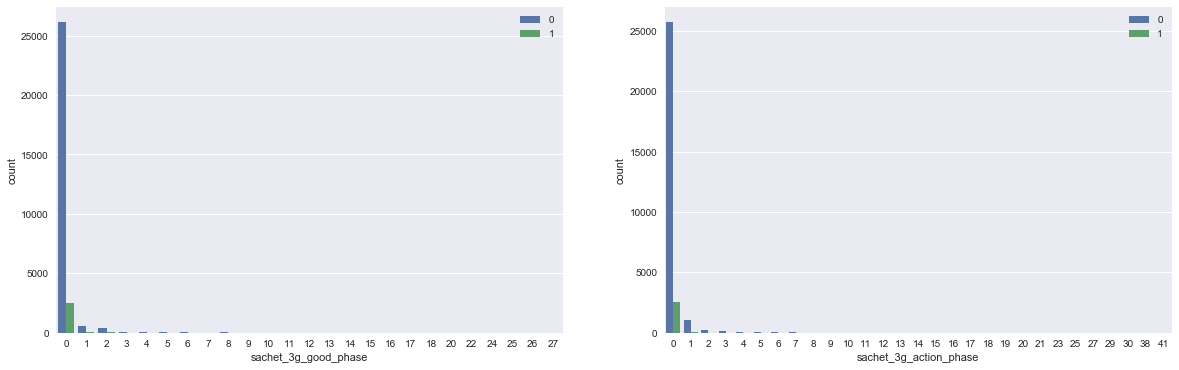

In [145]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.countplot(x='sachet_3g_good_phase',hue='churn',data=telecom)
plt.legend(loc='upper right', frameon=False)
plt.subplot(1,2,2)
sns.countplot(x='sachet_3g_action_phase',hue='churn',data=telecom)
plt.legend(loc='upper right', frameon=False)

In [146]:
# create new columns for good phase and action phase
telecom['fb_user_good_phase'] = np.where((telecom.fb_user_6==1) | (telecom.fb_user_7==1), 1, 0)
telecom['fb_user_action_phase'] = np.where((telecom.fb_user_8==1),1,0)

# drop the original variables
telecom.drop(['fb_user_6','fb_user_7','fb_user_8'],axis=1, inplace=True)

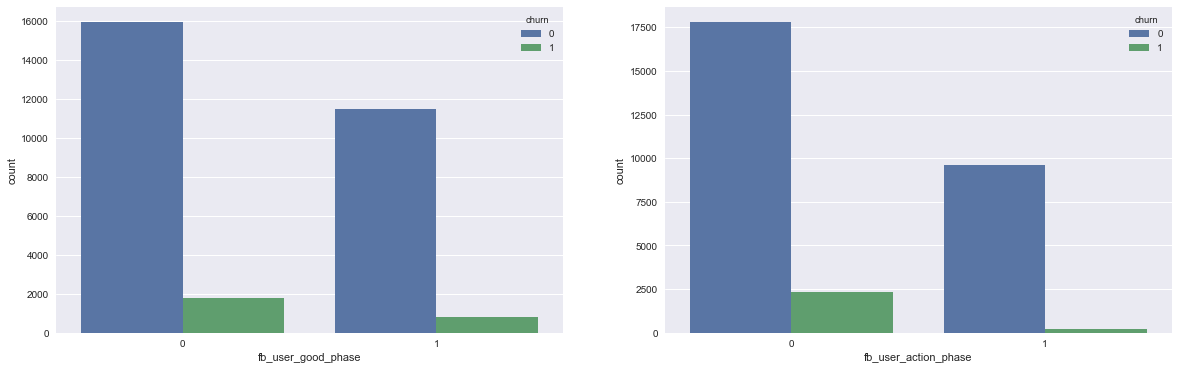

In [147]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.countplot(x='fb_user_good_phase',hue='churn',data=telecom)
plt.subplot(1,2,2)
sns.countplot(x='fb_user_action_phase',hue='churn',data=telecom)

In [148]:
# check the columns for volume based cost
display(telecom[['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']].describe())

# check for missing values
display(telecom[['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']].isnull().sum())

# create new columns for good phase and action phase
telecom['vbc_good_phase'] = (telecom.jun_vbc_3g + telecom.jul_vbc_3g) / 2
#telecom['vbc_good_phase']=telecom['vbc_good_phase'].apply(lambda x:round(x,0)).astype(int)
telecom['vbc_action_phase'] = telecom['aug_vbc_3g']

# drop the original variables
telecom.drop(['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g'],axis=1, inplace=True)

,jun_vbc_3g,jul_vbc_3g,aug_vbc_3g
count,29996.000000,29996.000000,29996.000000
mean,121.421042,135.185899,129.476770
std,389.814074,408.115329,390.545408
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,2.042500,1.650000
max,11166.210000,9165.600000,12916.220000


jun_vbc_3g    0
jul_vbc_3g    0
aug_vbc_3g    0
dtype: int64

No handles with labels found to put in legend.
No handles with labels found to put in legend.


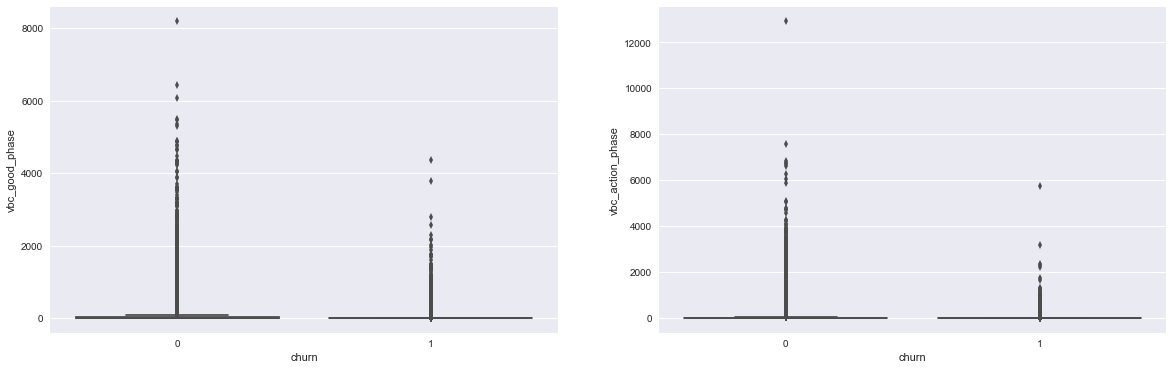

In [149]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.boxplot(x='churn',y='vbc_good_phase',data=telecom)
plt.legend(loc='upper right', frameon=False)
plt.subplot(1,2,2)
sns.boxplot(x='churn',y='vbc_action_phase',data=telecom)
plt.legend(loc='upper right', frameon=False)

### Consider remaining columns

In [150]:
telecom['aon'].describe()

count    29996.000000
mean      1264.274337
std        975.362496
min        180.000000
25%        480.000000
50%        914.000000
75%       1926.000000
max       4321.000000
Name: aon, dtype: float64

In [151]:
# check for missing values
telecom['aon'].isnull().sum()

0

No handles with labels found to put in legend.


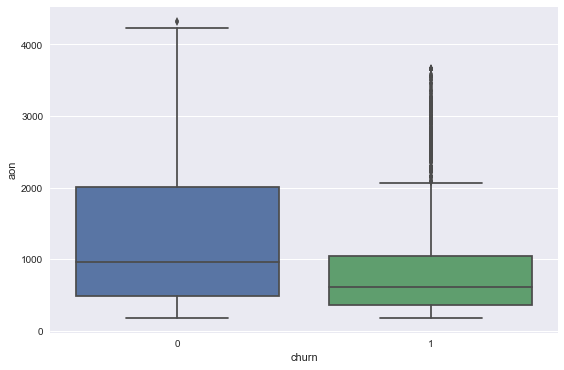

In [152]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.boxplot(x='churn',y='aon',data=telecom)
plt.legend(loc='upper right', frameon=False)

<b> Observations :</b>
    1. There is an increase in consumption of '2G & 3G monthly packs only' in action phase compared to good phase
    2. Number of 2G & 3G sachet packs have decreased in the action phase
    3. There is a decrease in fb pack for churners in the action phase.

In [153]:
telecom[telecom.total_rech_amt_good_phase>10000].filter(like='amt',axis=1)

,total_rech_amt_good_phase,total_rech_amt_action_phase,total_rech_amt_increase_in_action_phase,max_rech_amt_good_phase,max_rech_amt_action_phase,max_rech_amt_increase_in_action_phase,last_day_rch_amt_good_phase,last_day_rch_amt_action_phase
98208,10265.0,6855,-3410.0,275.0,300,25.0,200.0,150


In [154]:
telecom[telecom.total_rech_amt_good_phase>10000].filter(like='mou',axis=1)

,total_ic_mou_good_phase,total_ic_mou_action_phase,total_ic_mou_increase_in_action,loc_ic_mou_good_phase,loc_ic_mou_action_phase,std_ic_mou_good_phase,std_ic_mou_action_phase,roam_ic_mou_good_phase,roam_ic_mou_action_phase,spl_ic_mou_good_phase,...,std_og_t2m_mou_decrease_in_action,std_og_t2f_mou_good_phase,std_og_t2f_mou_action_phase,std_og_t2f_mou_decrease_in_action,onnet_mou_good_phase,onnet_mou_action_phase,onnet_mou_increase_in_action,offnet_mou_good_phase,offnet_mou_action_phase,offnet_mou_increase_in_action
98208,747.785,835.91,88.125,135.88,137.24,2.355,0.0,0.0,0.0,0.0,...,0.705,0.0,0.0,0.0,127.55,146.56,19.01,1095.77,737.66,-358.11


<b>Since the offnet calls is high, the recharge amount is also high. Therefore we decide to keep the extreme values. Outliers are not removed wherever possible without loosing natural outlier information</b>

In [155]:
print("After Data Analysis, the shape of the dataset is: ",telecom.shape)

After Data Analysis, the shape of the dataset is:  (29996, 123)


In [156]:
telecom.isnull().sum().values.any() 

False

# 3. Framing the dataset

In [157]:
# splitting the dataset as X and y
X = telecom.drop(['mobile_number','churn'],axis=1)
y = telecom['churn']

In [158]:
X.shape, y.shape

((29996, 121), (29996,))

In [159]:
# check the churn values in y before the split
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
print("\nShape after split",X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# check the churn values in y after the split
print("\nChurns in y_train are {} which is {:.2f}% of train dataset".format(y_train.value_counts().tolist()[1],
                                                                     y_train.value_counts().tolist()[1]/len(y_train)))
print("\nChurns in y_test are {} which is {:.2f}% of test dataset".format(y_test.value_counts().tolist()[1],
                                                                     y_test.value_counts().tolist()[1]/len(y_test)))


0    27403
1     2593
Name: churn, dtype: int64

Shape after split (20997, 121) (8999, 121) (20997,) (8999,)

Churns in y_train are 1819 which is 0.09% of train dataset

Churns in y_test are 774 which is 0.09% of test dataset


In [160]:
# we want the churns rate to be same in test as in train.
# so we use train_test_split with stratify

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)
print("\nShape after split",X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# check the churn values in y after the split
print("\nChurns in y_train are {} which is {:.2f}% of train dataset".format(y_train.value_counts().tolist()[1],
                                                                     y_train.value_counts().tolist()[1]/len(y_train)))
print("\nChurns in y_test are {} which is {:.2f}% of test dataset".format(y_test.value_counts().tolist()[1],
                                                                     y_test.value_counts().tolist()[1]/len(y_test)))



Shape after split (20997, 121) (8999, 121) (20997,) (8999,)

Churns in y_train are 1815 which is 0.09% of train dataset

Churns in y_test are 778 which is 0.09% of test dataset


In [161]:
# scaling all continous variables
scale = StandardScaler()

X_train_scale = scale.fit_transform(X_train)
X_train_scale.shape,X_train.shape

((20997, 121), (20997, 121))

In [162]:
type(X_train_scale)

numpy.ndarray

In [163]:
X_train_scale

array([[-0.54493893, -0.00492483,  0.50910763, ..., -0.69924083,
        -0.34570008, -0.32503621],
       [-1.10195859,  0.44084194,  0.74523002, ..., -0.69924083,
        -0.34570008, -0.32503621],
       [ 1.68109182,  0.22916498, -0.19925954, ..., -0.69924083,
        -0.34570008, -0.32503621],
       ...,
       [-1.0159482 , -0.50049794,  0.74523002, ..., -0.69924083,
        -0.34570008, -0.32503621],
       [-1.0128764 , -0.36851113,  0.50910763, ...,  1.43012244,
         2.12994597,  1.16290483],
       [-0.93403354, -0.70968458,  0.74523002, ..., -0.69924083,
        -0.34570008, -0.32503621]])

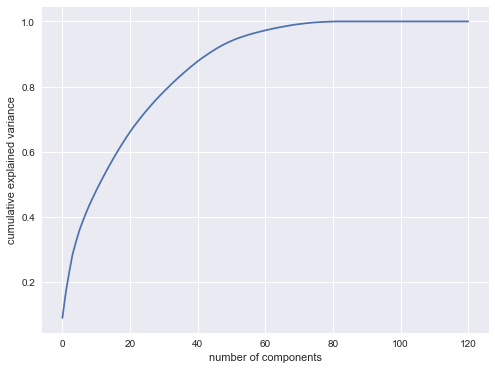

In [164]:
pca = PCA(svd_solver='randomized')
pca.fit_transform(X_train_scale)

fig = plt.figure(figsize = (8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [165]:
# From the above graph 80 components give the complete variance
# but we 
pca = PCA(0.7) # with 90% variance cutoff
pca

PCA(copy=True, iterated_power='auto', n_components=0.7, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [166]:
X_train_pca = pca.fit_transform(X_train_scale)
X_train_pca.shape

(20997, 24)

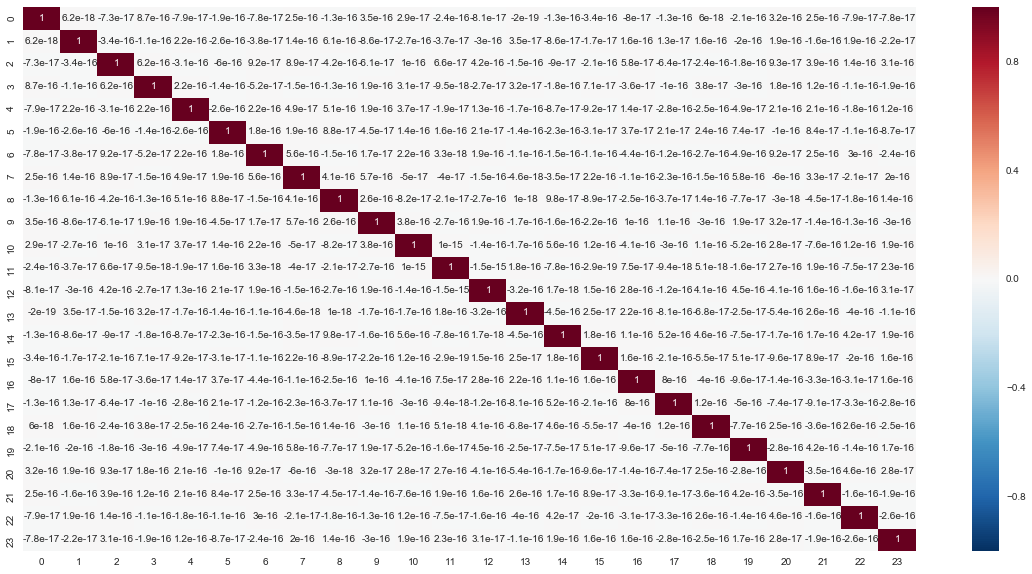

In [167]:
# plot the heat map
plt.figure(figsize = (20,10))
sns.heatmap(np.corrcoef(X_train_pca.transpose()),annot = True)

# 4. Modelling

## 4.1 Logistic Regression Model - to identify important predictor attributes

In [168]:
print("The shape of the dataset now is: ",telecom.shape)

The shape of the dataset now is:  (29996, 123)


We have 123 variables and need to reduce the number of variables using RFE technique to 15.

In [169]:
# define a function for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [170]:
# Normalizing the X_train before GLM
X_train_s = (X_train - X_train.mean())/X_train.std()

In [171]:
# building logistic regression model with all variables
logit_1 = sm.GLM(y_train,(sm.add_constant(X_train_s)), family = sm.families.Binomial())
display(logit_1.fit().summary())

# vif_cal(X_train,y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20997
Model:                            GLM   Df Residuals:                    20898
Model Family:                Binomial   Df Model:                           98
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 17 Nov 2018   Deviance:                          nan
Time:                        21:49:25   Pearson chi2:                 7.92e+18
No. Iterations:                   100   Covariance Type:             nonrobust
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                   -8.285e+14   4.63e+05  -1.79e+09      0.000   -8.29e+14   -8.29e+14
aon                                     -5.248e+13   5.17e+05  -1.02e+08      0.000   -5.25e+13   -5.25e+13
total_rech_amt_good_phase               -4.693e+13    1.7e+06  -2.75e+07      0.000   -4.69e+13   -4.69e+13
day_of_last_rech_6                       1.053e+13   1.25e+06   8.42e+06      0.000    1.05e+13    1.05e+13
week_of_last_rech_6                     -6.496e+12   1.25e+06   -5.2e+06      0.000    -6.5e+12    -6.5e+12
day_of_last_rech_7                      -9.013e+13   1.41e+06  -6.39e+07      0.000   -9.01e+13   -9.01e+13
week_of_last_rech_7                      3.401e+13   1.39e+06   2.45e+07      0.000     3.4e+13     3.4e+13
day_of_last_rech_8                      -1.276e+13   1.58e+06   -8.1e+06      0.000   -1.28e+13   -1.28e+13
week_of_last_rech_8                     -7.614e+13   1.56e+06  -4.89e+07      0.000   -7.61e+13   -7.61e+13
voice_only                               -3.54e+13    8.3e+05  -4.27e+07      0.000   -3.54e+13   -3.54e+13
arpu_good_phase                          1.397e+14   1.64e+06   8.51e+07      0.000     1.4e+14     1.4e+14
arpu_action_phase                        4.229e+13    1.3e+06   3.26e+07      0.000    4.23e+13    4.23e+13
arpu_increase_in_action                 -9.187e+13   8.31e+05  -1.11e+08      0.000   -9.19e+13   -9.19e+13
arpu_2g_good_phase                       4.371e+13    1.2e+06   3.65e+07      0.000    4.37e+13    4.37e+13
arpu_2g_action_phase                     1.885e+13   1.11e+06    1.7e+07      0.000    1.88e+13    1.88e+13
arpu_2g_increase_in_action              -3.243e+13   8.47e+05  -3.83e+07      0.000   -3.24e+13   -3.24e+13
arpu_3g_good_phase                      -6.553e+13   1.15e+06   -5.7e+07      0.000   -6.55e+13   -6.55e+13
arpu_3g_action_phase                    -3.535e+13   1.02e+06  -3.46e+07      0.000   -3.54e+13   -3.54e+13
arpu_3g_increase_in_action               3.703e+13   7.81e+05   4.74e+07      0.000     3.7e+13     3.7e+13
total_rech_amt_action_phase              2.482e+12   1.31e+06    1.9e+06      0.000    2.48e+12    2.48e+12
total_rech_amt_increase_in_action_phase  4.947e+13   8.86e+05   5.59e+07      0.000    4.95e+13    4.95e+13
max_rech_amt_good_phase                   1.72e+13   5.28e+05   3.26e+07      0.000    1.72e+13    1.72e+13
max_rech_amt_action_phase               -2.742e+13   4.69e+05  -5.84e+07      0.000   -2.74e+13   -2.74e+13
max_rech_amt_increase_in_action_phase   -5.282e+13   4.91e+05  -1.08e+08      0.000   -5.28e+13   -5.28e+13
last_day_rch_amt_good_phase             -3.461e+13    6.7e+05  -5.16e+07      0.000   -3.46e+13   -3.46e+13
last_day_rch_amt_action_phase           -1.668e+14   6.84e+05  -2.44e+08      0.000   -1.67e+14   -1.67e+14
total_rech_num_good_phase     

The below list of 123 variables are having p value < 0.05. 

In [172]:
vif = vif_cal(X_train_s,y_train)

In [173]:
# selecting the columns having less vif values
vif[vif.Vif<12].Var.values

array(['day_of_last_rech_8', 'week_of_last_rech_8', 'day_of_last_rech_7',
       'week_of_last_rech_7', 'vol_3g_mb_good_phase',
       'day_of_last_rech_6', 'week_of_last_rech_6',
       'vol_3g_mb_action_phase', 'monthly_3g_action_phase',
       'monthly_3g_good_phase', 'total_rech_num_action_phase',
       'fb_user_good_phase', 'total_rech_num_good_phase',
       'vbc_good_phase', 'voice_only', 'vbc_action_phase',
       'fb_user_action_phase', 'roam_ic_mou_good_phase',
       'sachet_2g_action_phase', 'sachet_3g_action_phase',
       'roam_ic_mou_action_phase', 'sachet_3g_good_phase',
       'vol_2g_mb_good_phase', 'sachet_2g_good_phase',
       'monthly_2g_action_phase', 'last_day_rch_amt_action_phase',
       'vol_2g_mb_action_phase', 'last_day_rch_amt_good_phase',
       'monthly_2g_good_phase', 'aon'], dtype=object)

In [174]:
# select the variables which has p value < 0.05
cols = ['day_of_last_rech_8', 'week_of_last_rech_8', 'day_of_last_rech_7',
       'week_of_last_rech_7', 'day_of_last_rech_6', 'week_of_last_rech_6',
       'vol_3g_mb_good_phase', 'monthly_3g_action_phase',
       'vol_3g_mb_action_phase', 'monthly_3g_good_phase',
       'total_rech_num_action_phase', 'fb_user_good_phase',
       'total_rech_num_good_phase', 'voice_only', 'fb_user_action_phase',
       'vbc_good_phase', 'vbc_action_phase', 'roam_ic_mou_good_phase',
       'sachet_3g_action_phase', 'sachet_2g_action_phase',
       'last_day_rch_amt_action_phase', 'vol_2g_mb_good_phase',
       'roam_ic_mou_action_phase', 'sachet_2g_good_phase',
       'sachet_3g_good_phase', 'vol_2g_mb_action_phase',
       'last_day_rch_amt_good_phase', 'monthly_2g_action_phase',
       'monthly_2g_good_phase', 'aon']

In [175]:
# building logistic regression model with selected variables
logit_2 = sm.GLM(y_train,(sm.add_constant(X_train[cols])), family = sm.families.Binomial())
display(logit_2.fit().summary())

vif_cal(X_train[cols],y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20997
Model:                            GLM   Df Residuals:                    20966
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4586.1
Date:                Sat, 17 Nov 2018   Deviance:                       9172.1
Time:                        21:51:15   Pearson chi2:                 3.66e+11
No. Iterations:                     8   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.4797      0.294      5.025      0.000       0.903       2.057
day_of_last_rech_8                0.0074      0.017      0.433      0.665      -0.026       0.041
week_of_last_rech_8              -0.4164      0.111     -3.757      0.000      -0.634      -0.199
day_of_last_rech_7               -0.0379      0.018     -2.132      0.033      -0.073      -0.003
week_of_last_rech_7               0.0268      0.114      0.235      0.815      -0.197       0.251
day_of_last_rech_6               -0.0083      0.018     -0.467      0.641      -0.043       0.027
week_of_last_rech_6               0.0943      0.105      0.897      0.370      -0.112       0.301
vol_3g_mb_good_phase           -1.62e-05   9.22e-05     -0.176      0.861      -0.000       0.000
monthly_3g_action_phase          -0.3536      0.189     -1.868      0.062      -0.725       0.017
vol_3g_mb_action_phase         3.951e-05      0.000      0.340      0.734      -0.000       0.000
monthly_3g_good_phase             0.0362      0.105      0.345      0.730      -0.170       0.242
total_rech_num_action_phase      -0.1337      0.007    -20.140      0.000      -0.147      -0.121
fb_user_good_phase                0.1658      0.121      1.371      0.170      -0.071       0.403
total_rech_num_good_phase         0.0566      0.004     12.706      0.000       0.048       0.065
voice_only                        0.0916      0.108      0.848      0.396      -0.120       0.303
fb_user_action_phase             -0.8523      0.147     -5.780      0.000      -1.141      -0.563
vbc_good_phase                    0.0004      0.000      2.481      0.013    8.27e-05       0.001
vbc_action_phase                 -0.0010      0.000     -4.127      0.000      -0.002      -0.001
roam_ic_mou_good_phase            0.0015      0.000      3.837      0.000       0.001       0.002
sachet_3g_action_phase           -0.0751      0.096     -0.779      0.436      -0.264       0.114
sachet_2g_action_phase           -0.0586      0.041     -1.444      0.149      -0.138       0.021
last_day_rch_amt_action_phase    -0.0081      0.000    -17.139      0.000      -0.009      -0.007
vol_2g_mb_good_phase              0.0004      0.000      2.375      0.018    7.46e-05       0.001
roam_ic_mou_action_phase          0.0027      0.000      7.272      0.000       0.002       0.003
sachet_2g_good_phase              0.0076      0.027      0.282      0.778      -0.045       0.060
sachet_3g_good_phase              0.1123      0.055      2.030      0.042       0.004       0.221
vol_2g_mb_action_phase           -0.0004      0.000     -1.298      0.194      -0.001       0.000
last_day_rch_amt_good_phase      -0.0003      0.000     -1.243      0.214      -0.001       0.000
monthly_2g_action_phase          -0.7665      0.240     -3.195      0.001      -1.237      -0.296
monthly_2g_good_phase     

,Var,Vif
3,week_of_last_rech_7,392.68
2,day_of_last_rech_7,378.17
1,week_of_last_rech_8,350.80
0,day_of_last_rech_8,335.18
4,day_of_last_rech_6,293.58
5,week_of_last_rech_6,288.63
12,total_rech_num_good_phase,7.37
6,vol_3g_mb_good_phase,6.29
8,vol_3g_mb_action_phase,5.91
11,fb_user_good_phase,5.82


In [176]:
# removing variables with p-value > 0.05
cols = ['week_of_last_rech_8','monthly_3g_action_phase','total_rech_num_action_phase',
        'total_rech_num_good_phase','fb_user_action_phase','vbc_good_phase','vbc_action_phase',
        'roam_ic_mou_good_phase','sachet_2g_action_phase','last_day_rch_amt_action_phase',
        'vol_2g_mb_good_phase','roam_ic_mou_action_phase','monthly_2g_action_phase','monthly_2g_good_phase',
        'aon']


In [177]:
# building logistic regression model with selected variables

logit_3 = sm.GLM(y_train,(sm.add_constant(X_train[cols])), family = sm.families.Binomial())
display(logit_3.fit().summary())

vif_cal(X_train[cols],y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20997
Model:                            GLM   Df Residuals:                    20981
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4610.7
Date:                Sat, 17 Nov 2018   Deviance:                       9221.5
Time:                        21:51:17   Pearson chi2:                 5.08e+11
No. Iterations:                     8   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.9153      0.140      6.533      0.000       0.641       1.190
week_of_last_rech_8              -0.3678      0.031    -12.011      0.000      -0.428      -0.308
monthly_3g_action_phase          -0.3379      0.154     -2.196      0.028      -0.640      -0.036
total_rech_num_action_phase      -0.1443      0.006    -22.309      0.000      -0.157      -0.132
total_rech_num_good_phase         0.0587      0.004     14.392      0.000       0.051       0.067
fb_user_action_phase             -0.8028      0.132     -6.101      0.000      -1.061      -0.545
vbc_good_phase                    0.0005      0.000      3.703      0.000       0.000       0.001
vbc_action_phase                 -0.0010      0.000     -4.268      0.000      -0.002      -0.001
roam_ic_mou_good_phase            0.0015      0.000      3.942      0.000       0.001       0.002
sachet_2g_action_phase           -0.0712      0.036     -2.005      0.045      -0.141      -0.002
last_day_rch_amt_action_phase    -0.0083      0.000    -17.723      0.000      -0.009      -0.007
vol_2g_mb_good_phase              0.0004      0.000      2.655      0.008       0.000       0.001
roam_ic_mou_action_phase          0.0027      0.000      7.155      0.000       0.002       0.003
monthly_2g_action_phase          -0.8433      0.227     -3.710      0.000      -1.289      -0.398
monthly_2g_good_phase            -0.4264      0.152     -2.803      0.005      -0.725      -0.128
aon                              -0.0005   3.64e-05    -13.780      0.000      -0.001      -0.000
=================================================================================================
"""

,Var,Vif
0,week_of_last_rech_8,6.23
3,total_rech_num_good_phase,5.89
2,total_rech_num_action_phase,4.91
4,fb_user_action_phase,3.12
14,aon,2.65
6,vbc_action_phase,2.61
5,vbc_good_phase,2.44
12,monthly_2g_action_phase,2.01
1,monthly_3g_action_phase,1.91
7,roam_ic_mou_good_phase,1.66


In [178]:
# removing variables with p-value > 0.05 and VIF infinity
cols = ['monthly_3g_action_phase','total_rech_num_action_phase','fb_user_action_phase','vbc_action_phase',
        'roam_ic_mou_good_phase','sachet_2g_action_phase','last_day_rch_amt_action_phase',
        'roam_ic_mou_action_phase','monthly_2g_action_phase','monthly_2g_good_phase',
        'aon']

In [179]:
# building logistic regression model with selected variables

logit_4 = sm.GLM(y_train,(sm.add_constant(X_train[cols])), family = sm.families.Binomial())
display(logit_4.fit().summary())

vif_cal(X_train[cols],y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20997
Model:                            GLM   Df Residuals:                    20985
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4810.8
Date:                Sat, 17 Nov 2018   Deviance:                       9621.5
Time:                        21:51:18   Pearson chi2:                 8.13e+12
No. Iterations:                     8   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0794      0.057      1.395      0.163      -0.032       0.191
monthly_3g_action_phase          -0.4811      0.156     -3.089      0.002      -0.786      -0.176
total_rech_num_action_phase      -0.1337      0.006    -23.396      0.000      -0.145      -0.122
fb_user_action_phase             -0.6227      0.126     -4.924      0.000      -0.871      -0.375
vbc_action_phase                 -0.0007      0.000     -3.420      0.001      -0.001      -0.000
roam_ic_mou_good_phase            0.0015      0.000      3.991      0.000       0.001       0.002
sachet_2g_action_phase           -0.1140      0.036     -3.183      0.001      -0.184      -0.044
last_day_rch_amt_action_phase    -0.0093      0.000    -20.155      0.000      -0.010      -0.008
roam_ic_mou_action_phase          0.0027      0.000      7.096      0.000       0.002       0.003
monthly_2g_action_phase          -0.9827      0.226     -4.347      0.000      -1.426      -0.540
monthly_2g_good_phase            -0.2958      0.141     -2.097      0.036      -0.572      -0.019
aon                              -0.0006   3.53e-05    -15.890      0.000      -0.001      -0.000
=================================================================================================
"""

,Var,Vif
2,fb_user_action_phase,2.98
8,monthly_2g_action_phase,1.99
0,monthly_3g_action_phase,1.88
10,aon,1.79
4,roam_ic_mou_good_phase,1.65
1,total_rech_num_action_phase,1.64
7,roam_ic_mou_action_phase,1.63
3,vbc_action_phase,1.62
9,monthly_2g_good_phase,1.53
5,sachet_2g_action_phase,1.49


In [180]:
# the above set of features have p-value less than 0.05 and also VIF < 5
selected_cols = cols
len(selected_cols)

11

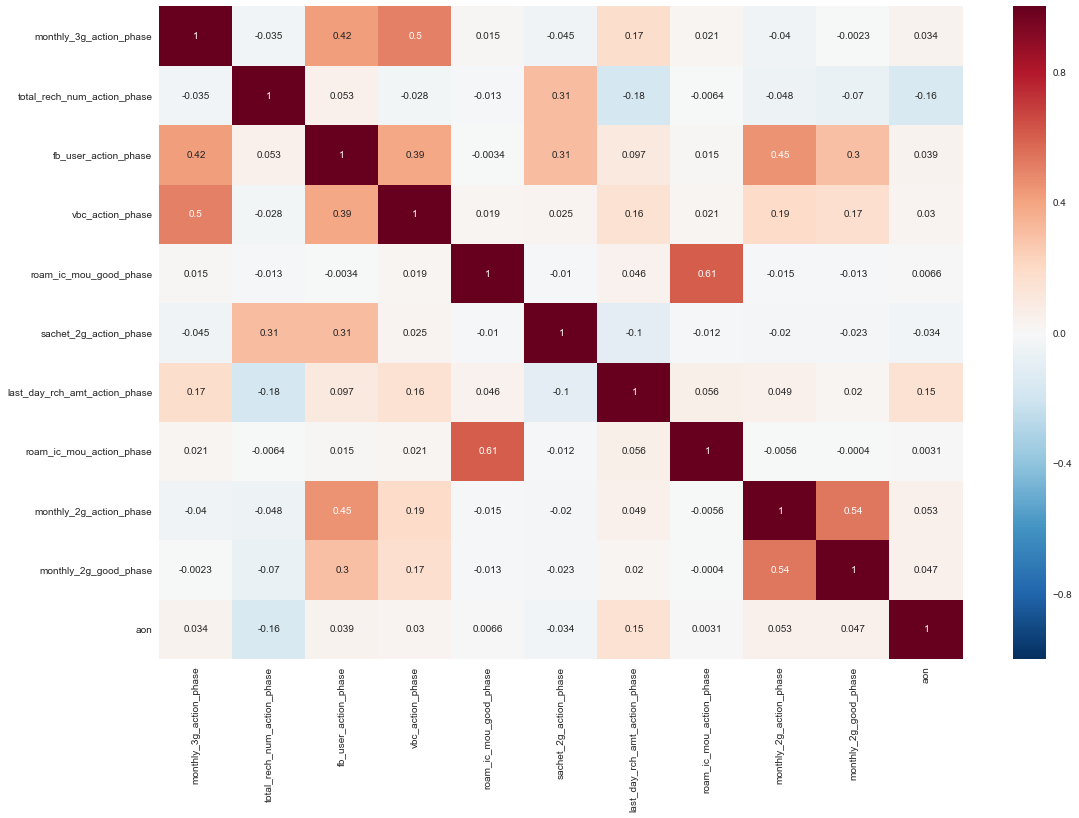

In [181]:
# plot the heat map with the selected cols
plt.figure(figsize=(18,12))
sns.heatmap(X_train[selected_cols].corr(),annot=True)

In [182]:
logreg_selected_cols = selected_cols

print("Logistic Regression : Important Predictor variables\n")
print(cols)
print("")
logreg = LogisticRegression(class_weight='balanced')
logreg.fit(X_train[logreg_selected_cols],y_train)

y_pred_logreg = logreg.predict(X_train[logreg_selected_cols])

print(classification_report(y_train, y_pred_logreg,target_names=['non-churn','churn']))

print("accuracy : ",accuracy_score(y_train,y_pred_logreg))

print(confusion_matrix(y_train,y_pred_logreg))

tn, fp, fn, tp = confusion_matrix(y_train,y_pred_logreg).ravel()
print("tn:",tn)
print("fp:",fp)
print("fn:",fn)
print("tp:",tp)
print("")
print("AUC :", roc_auc_score(y_train,y_pred_logreg))


Logistic Regression : Important Predictor variables

['monthly_3g_action_phase', 'total_rech_num_action_phase', 'fb_user_action_phase', 'vbc_action_phase', 'roam_ic_mou_good_phase', 'sachet_2g_action_phase', 'last_day_rch_amt_action_phase', 'roam_ic_mou_action_phase', 'monthly_2g_action_phase', 'monthly_2g_good_phase', 'aon']

              precision    recall  f1-score   support

   non-churn       0.98      0.73      0.84     19182
       churn       0.22      0.81      0.35      1815

   micro avg       0.74      0.74      0.74     20997
   macro avg       0.60      0.77      0.59     20997
weighted avg       0.91      0.74      0.79     20997

accuracy :  0.7387722055531742
[[14043  5139]
 [  346  1469]]
tn: 14043
fp: 5139
fn: 346
tp: 1469

AUC : 0.770729488992349


<b> Observations : </b>
    1. Important predicted variables as selected by logistic regression are as below
    
        ['monthly_3g_action_phase', 'total_rech_num_action_phase', 'fb_user_action_phase', 'vbc_action_phase', 'roam_ic_mou_good_phase', 'sachet_2g_action_phase', 'last_day_rch_amt_action_phase', 'roam_ic_mou_action_phase', 'monthly_2g_action_phase', 'monthly_2g_good_phase', 'aon']

## 4.2 Lasso Regression - to identify important predictor attributes

In [183]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train,y_train)

lasso_selected_cols = pd.DataFrame({'X_columns': X_train.columns, "coef": lasso.coef_})
lasso_selected_cols = lasso_selected_cols.sort_values(by='coef',ascending=False)
print("Columns after Lasso : \n", lasso_selected_cols[lasso_selected_cols.coef>0].X_columns.values)

Columns after Lasso : 
 ['roam_og_mou_good_phase' 'roam_ic_mou_good_phase'
 'roam_og_mou_action_phase' 'spl_og_mou_decrease_in_action'
 'arpu_3g_increase_in_action' 'isd_og_mou_action_phase'
 'total_og_mou_decrease_in_action' 'isd_ic_mou_action_phase'
 'onnet_mou_good_phase' 'std_og_mou_decrease_in_action'
 'max_rech_amt_good_phase' 'arpu_2g_good_phase'
 'std_og_t2m_mou_good_phase' 'std_ic_t2t_mou_good_phase'
 'total_rech_amt_good_phase' 'loc_ic_t2m_mou_good_phase'
 'total_rech_amt_action_phase' 'vbc_good_phase']


In [184]:
# Coefficients of Lasso
lasso_selected_cols[lasso_selected_cols.coef>0]

,X_columns,coef
67,roam_og_mou_good_phase,0.000143
38,roam_ic_mou_good_phase,0.000127
68,roam_og_mou_action_phase,0.000074
72,spl_og_mou_decrease_in_action,0.000071
17,arpu_3g_increase_in_action,0.000037
74,isd_og_mou_action_phase,0.000034
60,total_og_mou_decrease_in_action,0.000031
43,isd_ic_mou_action_phase,0.000031
100,onnet_mou_good_phase,0.000029
66,std_og_mou_decrease_in_action,0.000027


<b> Observations : </b>
    1. Important predictor variables selected by Lasso is 
    
   ['roam_og_mou_good_phase' 'roam_ic_mou_good_phase'
 'roam_og_mou_action_phase' 'isd_og_mou_good_phase' 'arpu_3g_action_phase'
 'isd_og_mou_action_phase' 'std_og_mou_decrease_in_action'
 'total_og_mou_decrease_in_action' 'std_og_t2m_mou_good_phase'
 'max_rech_amt_good_phase' 'onnet_mou_good_phase'
 'std_ic_t2t_mou_good_phase' 'total_rech_amt_action_phase'
 'total_rech_amt_increase_in_action_phase' 'arpu_3g_increase_in_action']

## 4.3 Decision Tree - to identify important predictor attributes

In [185]:
# fitting a decision tree with max_depth=10
tree = DecisionTreeClassifier(class_weight={0:0.1,1:0.9}, max_depth=4,max_features=120,criterion='entropy')
tree.fit(X_train, y_train)

tree_selected_cols = pd.DataFrame({'X_columns': X_train.columns, "feature_importances": tree.feature_importances_})
tree_selected_cols = tree_selected_cols.sort_values(by='feature_importances',ascending=False)
print("Columns after Decision Tree : \n", tree_selected_cols[:10])

print("")
print(tree_selected_cols.X_columns[:10].values)

Columns after Decision Tree : 
                                    X_columns  feature_importances
32                 total_ic_mou_action_phase             0.616587
68                  roam_og_mou_action_phase             0.123773
24             last_day_rch_amt_action_phase             0.083892
6                         day_of_last_rech_8             0.070367
19   total_rech_amt_increase_in_action_phase             0.026367
64                     std_og_mou_good_phase             0.025015
67                    roam_og_mou_good_phase             0.019760
30                    vol_3g_mb_action_phase             0.015180
83               loc_og_t2m_mou_action_phase             0.011881
104                  offnet_mou_action_phase             0.005527

['total_ic_mou_action_phase' 'roam_og_mou_action_phase'
 'last_day_rch_amt_action_phase' 'day_of_last_rech_8'
 'total_rech_amt_increase_in_action_phase' 'std_og_mou_good_phase'
 'roam_og_mou_good_phase' 'vol_3g_mb_action_phase'
 'loc_og_t2m_

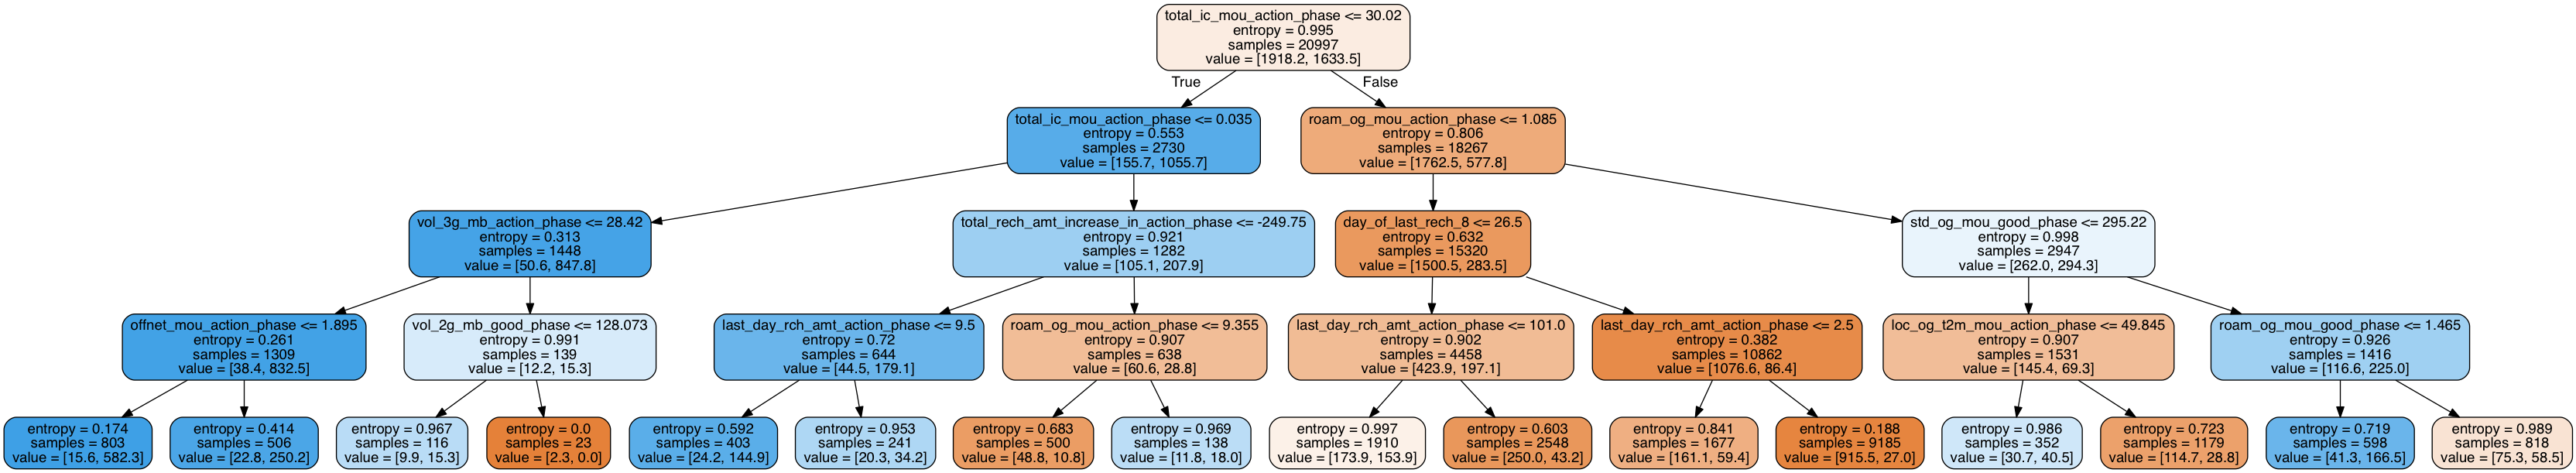

In [186]:
# plot the tree
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

dot_data = StringIO()  
export_graphviz(tree, out_file=dot_data,
                feature_names=X_train.columns, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

<b> Observations : </b>
    1. Important predictor variables selected by Decision Tree classifiers are more consistent
    
    ['total_ic_mou_action_phase', 'roam_og_mou_action_phase',
    'last_day_rch_amt_action_phase', 'day_of_last_rech_8',
    'loc_og_mou_action_phase', 'total_og_mou_decrease_in_action','roam_og_mou_good_phase',
    'fb_user_action_phase','loc_ic_t2f_mou_action_phase', 'onnet_mou_action_phase']

## Recommendations based on Important predictor variables

 From the above Decision tree the important predictor variables are 
    - total_ic_mou_action_phase             - 'Total incoming minutes of usage in action phase'. 
    - roam_og_mou_action_phase              - 'Roaming Outgoing calls in action phase'
    - last_day_rch_amt_action_phase         - 'Last recharge amount in action phase'
    - day_of_last_rech_8                    - 'Last recharge day of that month'
    - loc_og_mou_action_phase               - 'Local outgoing calls in action phase'
    - total_og_mou_decrease_in_action       - 'Decrease in total outgoing calls in action phase'
    - roam_og_mou_good_phase                - 'Roaming outgoing usage in good phase'
    - fb_user_action_phase                  - 'Subscription to FB Service in action phase'
    - loc_ic_t2f_mou_action_phase           - 'Local incoming from Same operator to fixed lines operators in action phase'
    - onnet_mou_action_phase                - 'All kinds of calls with same operator network'
    
We can determine the user is likely to churn by walking through the above decision tree.

<b> For example: if  total_ic_mou_action_phase is <= 0.185
                and  fb_user_action_phase <= 0.5
                and roam_og_mou_action_phase >= 458.5 then the user is likely to churn
                                                        else the user is non-churn </b> 
                                                        
Telecom company can connect with customers when roaming outgoing calls increases and total incoming calls decreases to understand if their usage is outside a particular telecom circle and suggests appropriate call plans to them

## 5.1 Build Logistic Regression model and Hyper tune the parameters

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.6s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_class_weight,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.042733,0.003029,0.912947,0.913085,1e-07,balanced,"{'C': 1e-07, 'class_weight': 'balanced'}",1,0.909091,0.914601,...,0.914601,0.913223,0.911846,0.911846,0.917355,0.911157,0.004343,0.000495,0.002809,0.001405
1,0.041666,0.002823,0.844078,0.843939,1e-07,None,"{'C': 1e-07, 'class_weight': None}",6,0.851240,0.843664,...,0.823691,0.845730,0.845730,0.845730,0.853994,0.842287,0.006472,0.000391,0.010683,0.001546
2,0.047222,0.002734,0.912947,0.913085,1e-06,balanced,"{'C': 1e-06, 'class_weight': 'balanced'}",1,0.909091,0.913912,...,0.914601,0.913223,0.911846,0.912534,0.917355,0.911157,0.005247,0.000485,0.002809,0.001185
3,0.047703,0.003695,0.840772,0.840909,1e-06,None,"{'C': 1e-06, 'class_weight': None}",7,0.851240,0.840220,...,0.818182,0.844353,0.842975,0.840909,0.848485,0.838843,0.003554,0.000837,0.011739,0.001848
4,0.057952,0.002907,0.911846,0.912810,1e-05,balanced,"{'C': 1e-05, 'class_weight': 'balanced'}",3,0.909091,0.913912,...,0.911846,0.912534,0.911846,0.913223,0.914601,0.910468,0.006853,0.000347,0.001742,0.001277


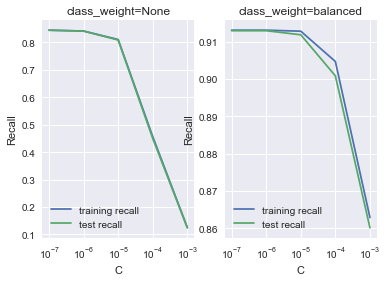

In [187]:
# let us define the hyper parameters for the Logistic regresion model.
# build the model with the scaled X values and PCA applied

params = {"class_weight": ['balanced',None],
          "C": [0.0000001,0.000001,0.00001,0.0001,0.001]}

folds = StratifiedKFold(n_splits=5,shuffle=True)

logreg = LogisticRegression()

logreg_grid = GridSearchCV(estimator=logreg,
                           param_grid=params,
                           scoring='recall',
                           cv=folds,
                           verbose=1,
                           return_train_score=True)

logreg_grid.fit(X_train_pca,y_train)

logreg_grid_cv_results = pd.DataFrame(logreg_grid.cv_results_)
display(logreg_grid_cv_results.head())


# plotting recall score with C
plt.figure()
plt.subplot(1,2,1)
plt.plot(logreg_grid_cv_results[logreg_grid_cv_results.param_class_weight.isnull()]["param_C"], 
         logreg_grid_cv_results[logreg_grid_cv_results.param_class_weight.isnull()]["mean_train_score"], 
         label="training recall")
plt.plot(logreg_grid_cv_results[logreg_grid_cv_results.param_class_weight.isnull()]["param_C"], 
         logreg_grid_cv_results[logreg_grid_cv_results.param_class_weight.isnull()]["mean_test_score"], 
         label="test recall")
plt.xlabel("C")
plt.ylabel("Recall")
plt.xscale('log')
plt.title('class_weight=None')
plt.legend()


plt.subplot(1,2,2)
plt.plot(logreg_grid_cv_results[logreg_grid_cv_results.param_class_weight=='balanced']["param_C"], 
         logreg_grid_cv_results[logreg_grid_cv_results.param_class_weight=='balanced']["mean_train_score"], 
         label="training recall")
plt.plot(logreg_grid_cv_results[logreg_grid_cv_results.param_class_weight=='balanced']["param_C"], 
         logreg_grid_cv_results[logreg_grid_cv_results.param_class_weight=='balanced']["mean_test_score"], 
         label="test recall")
plt.xlabel("C")
plt.ylabel("Recall")
plt.xscale('log')
plt.title('class_weight=balanced')
plt.legend()

In [188]:
print("the best parameters chosen by the grid search is ",logreg_grid.best_params_)

print("the best score chosen by the grid search is ",round(logreg_grid.best_score_,3))

the best parameters chosen by the grid search is  {'C': 1e-07, 'class_weight': 'balanced'}
the best score chosen by the grid search is  0.913


In [189]:
# build a logistic regression model with the chosen parameters
# we choose class_weight as 'balanced' and C value as 1e-06

logreg_best = LogisticRegression(class_weight='balanced',C=1e-05)

# cross validation with the choosen model
cross_val_score(logreg_best,X_train_pca, y_train,cv=folds,scoring='recall')

array([0.8953168 , 0.90082645, 0.93663912, 0.91735537, 0.92011019])

In [190]:
# define a function to evaluate the classifier metrics

def print_metrics(y_true,y_pred):
    
    print("*"*30)
    print("*** Classification Report ***")
    print("*"*30)
    print(classification_report(y_true,y_pred))

    print("*"*30)
    print("*** Confusion Matrix ***")
    print("*"*30)
    print(confusion_matrix(y_true,y_pred))
    print("")
    print("*"*30)
    print("Accuracy : ",accuracy_score(y_true,y_pred))
    print("")
    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    print("tn:",tn)
    print("fp:",fp)
    print("fn:",fn)
    print("tp:",tp)
    print("")
    print("AUC:",round(roc_auc_score(y_true,y_pred),2))
    print("*"*30)

In [191]:
# validate other metrics with train data
logreg_best.fit(X_train_pca, y_train)

y_pred_train_logreg_best = logreg_best.predict(X_train_pca)

print_metrics(y_train,y_pred_train_logreg_best)

******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.98      0.53      0.69     19182
           1       0.16      0.91      0.27      1815

   micro avg       0.57      0.57      0.57     20997
   macro avg       0.57      0.72      0.48     20997
weighted avg       0.91      0.57      0.65     20997

******************************
*** Confusion Matrix ***
******************************
[[10227  8955]
 [  160  1655]]

******************************
Accuracy :  0.5658903652902796

tn: 10227
fp: 8955
fn: 160
tp: 1655

AUC: 0.72
******************************


In [192]:
# validate other metrics with test data
logreg_best.fit(X_train_pca, y_train)

# apply scale to X_test
X_test_scale = scale.transform(X_test)

#transform the X_test with pca
X_test_pca = pca.transform(X_test_scale)
print(X_test_pca.shape)

y_pred_test_logreg_best = logreg_best.predict(X_test_pca)

print_metrics(y_test,y_pred_test_logreg_best)

(8999, 24)
******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.99      0.53      0.69      8221
           1       0.16      0.92      0.27       778

   micro avg       0.57      0.57      0.57      8999
   macro avg       0.57      0.73      0.48      8999
weighted avg       0.91      0.57      0.66      8999

******************************
*** Confusion Matrix ***
******************************
[[4384 3837]
 [  61  717]]

******************************
Accuracy :  0.5668407600844538

tn: 4384
fp: 3837
fn: 61
tp: 717

AUC: 0.73
******************************


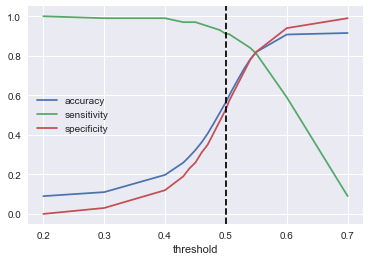

In [193]:
# tune the cut off threshold of logistic regression with train data

logreg_best.fit(X_train_pca, y_train)

# predict the probabilities of churn and non-churn
y_pred_train_logreg_best_thres_pred = logreg_best.predict_proba(X_train_pca)

# range of threshold values
threshold_vals = [0.2,0.3,0.4,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.505,0.51,0.52,0.53,0.54,0.55,0.6,0.7]

sensitivity_vals = []
specificity_vals = []
accuracy_vals=[]
for thres in threshold_vals:
    y_pred_thres = np.where(y_pred_train_logreg_best_thres_pred[:,1] > thres, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_train,y_pred_thres).ravel()
    sensitivity_vals.append(round(tp/(tp+fn),2))
    specificity_vals.append(round(tn/(tn+fp),2))
    accuracy_vals.append(accuracy_score(y_train, y_pred_thres))

    
sensi_specifi_df = pd.DataFrame({"threshold":threshold_vals,"sensitivity": sensitivity_vals,
                               "specificity":specificity_vals, "accuracy":accuracy_vals})

# plot the Sensitivity, recall, Accuracy for each threshold values

sensi_specifi_df.plot.line(x='threshold', y=['accuracy','sensitivity','specificity'])
plt.axvline(x=0.5,color='k', linestyle='--')


In [194]:
# Recall is 0.93 at threshold value 0.5, Precision is 0.1 which is also the maximum. 

# if we set the threshold to 0.53, there is a good trade off between sensitivity and specificity. 
# But we want more recall score. Hence keeping the threshold to 0.5 

sensi_specifi_df[sensi_specifi_df.threshold==0.5]

,accuracy,sensitivity,specificity,threshold
10,0.56589,0.91,0.53,0.5


In [195]:
#Logistic Regression with threshold=0.5
logreg_best.fit(X_train_pca, y_train)

y_pred_train_logreg_best = logreg_best.predict_proba(X_train_pca)

thres = 0.5
y_pred_thres = np.where(y_pred_train_logreg_best[:,1] > thres, 1, 0)
print_metrics(y_train,y_pred_thres)


tn, fp, fn, tp = confusion_matrix(y_train,y_pred_thres).ravel()



******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.98      0.53      0.69     19182
           1       0.16      0.91      0.27      1815

   micro avg       0.57      0.57      0.57     20997
   macro avg       0.57      0.72      0.48     20997
weighted avg       0.91      0.57      0.65     20997

******************************
*** Confusion Matrix ***
******************************
[[10227  8955]
 [  160  1655]]

******************************
Accuracy :  0.5658903652902796

tn: 10227
fp: 8955
fn: 160
tp: 1655

AUC: 0.72
******************************


In [196]:
reporter_col=['Model', 'tp', 'tn','fp','fn','Accuracy','Sensitivity','AUC']
# #Creating a dataframe for logistic regression summary
logistic_train_report = pd.DataFrame([['Logistic Regression - train', tp, tn,fp,fn, accuracy_score(y_train, y_pred_thres),recall_score(y_train, y_pred_thres),roc_auc_score(y_train, y_pred_thres)]], columns=reporter_col)
logistic_train_report

,Model,tp,tn,fp,fn,Accuracy,Sensitivity,AUC
0,Logistic Regression - train,1655,10227,8955,160,0.56589,0.911846,0.722501


In [197]:
# apply scale to X_test
X_test_scale = scale.transform(X_test)

#transform the X_test with pca
X_test_pca = pca.transform(X_test_scale)
print(X_test_pca.shape)

y_pred_test_logreg_best = logreg_best.predict(X_test_pca)

print_metrics(y_test,y_pred_test_logreg_best)

tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test_logreg_best).ravel()

(8999, 24)
******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.99      0.53      0.69      8221
           1       0.16      0.92      0.27       778

   micro avg       0.57      0.57      0.57      8999
   macro avg       0.57      0.73      0.48      8999
weighted avg       0.91      0.57      0.66      8999

******************************
*** Confusion Matrix ***
******************************
[[4384 3837]
 [  61  717]]

******************************
Accuracy :  0.5668407600844538

tn: 4384
fp: 3837
fn: 61
tp: 717

AUC: 0.73
******************************


In [198]:
# #Creating a dataframe for logistic regression summary
logistic_test_report = pd.DataFrame([['Logistic Regression - test', tp, tn,fp,fn, accuracy_score(y_test,y_pred_test_logreg_best),recall_score(y_test,y_pred_test_logreg_best),roc_auc_score(y_test,y_pred_test_logreg_best)]], columns=reporter_col)
logistic_test_report

,Model,tp,tn,fp,fn,Accuracy,Sensitivity,AUC
0,Logistic Regression - test,717,4384,3837,61,0.566841,0.921594,0.727431


<b> Observations: </b>
    1. Logistic Regression model with parameters {'class_weight': 'balanced', 'C': 1e-06} give a recall score of 0.93 on train data and 0.92 on the test data. 
    2. With a cutoff threshold 0.5, we get Recall score 0.93 on training data and 0.92 on test data. 
    3. The metrics with the logistic regression model with test data are as follows
        tn: 3905
        fp: 4321
        fn: 42
        tp: 736
        
        AUC: 0.7

## 5.2 Build Random Forest model and Hyper tune the parameters

In [199]:
# build a simple random forest classifier with default parameters and evaluate the model on train data

# class_weight parameter = 'balanced'
rf_balanced = RandomForestClassifier(class_weight='balanced')
display(rf_balanced)

rf_balanced.fit(X_train, y_train)

y_pred_train_rf_balanced = rf_balanced.predict(X_train)

print_metrics(y_train,y_pred_train_rf_balanced)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19182
           1       1.00      0.93      0.96      1815

   micro avg       0.99      0.99      0.99     20997
   macro avg       1.00      0.96      0.98     20997
weighted avg       0.99      0.99      0.99     20997

******************************
*** Confusion Matrix ***
******************************
[[19179     3]
 [  135  1680]]

******************************
Accuracy :  0.9934276325189313

tn: 19179
fp: 3
fn: 135
tp: 1680

AUC: 0.96
******************************


### Hyper tuning parameters considered for Random Forest classification
Random forest classifier has to be hyper tuned for the following parameters. Since validating the results of all parameters using grid search will be complicated, we will tune these parameters one at a time

* max_depth
* n_estimators
* max_features
* min_samples_leaf
* min_samples_split
* criterion
* class_weight (since the classes are imbalanced)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   30.2s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.196876,0.007252,0.700275,0.706887,gini,2,"{'criterion': 'gini', 'max_depth': 2}",3,0.672176,0.685262,...,0.680441,0.714187,0.743802,0.690771,0.685950,0.716942,0.008757,0.000497,0.026958,0.016108
1,0.539020,0.009467,0.744352,0.864463,gini,7,"{'criterion': 'gini', 'max_depth': 7}",2,0.743802,0.876033,...,0.738292,0.861570,0.782369,0.856749,0.724518,0.873967,0.010036,0.000178,0.020047,0.008963
2,0.815109,0.011594,0.629202,0.932920,gini,12,"{'criterion': 'gini', 'max_depth': 12}",5,0.633609,0.935950,...,0.619835,0.938017,0.672176,0.931818,0.586777,0.931818,0.014060,0.000338,0.027470,0.003812
3,0.907059,0.011908,0.574656,0.935813,gini,17,"{'criterion': 'gini', 'max_depth': 17}",7,0.581267,0.941460,...,0.550964,0.933196,0.619835,0.938705,0.550964,0.925620,0.015515,0.000668,0.025403,0.005818
4,0.244535,0.008006,0.687053,0.695317,entropy,2,"{'criterion': 'entropy', 'max_depth': 2}",4,0.688705,0.693526,...,0.694215,0.726584,0.716253,0.676997,0.644628,0.688705,0.004275,0.000213,0.023348,0.016618


the best parameters chosen by the grid search is  {'criterion': 'entropy', 'max_depth': 7}
the best score chosen by the grid search is  0.748


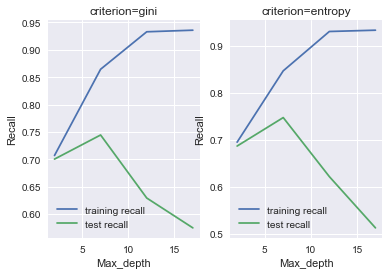

In [206]:
# Random Forest model parameters tuning for max_depth
# build the model with train data

params = {'max_depth': range(2, 20, 5),
          'criterion': ['gini','entropy']}

folds = StratifiedKFold(n_splits=5,shuffle=True)

rf = RandomForestClassifier(class_weight='balanced')

rf_grid = GridSearchCV(estimator=rf,
                           param_grid=params,
                           scoring='recall',
                           cv=folds,
                           verbose=1,
                           return_train_score=True)

rf_grid.fit(X_train,y_train)

rf_grid_cv_results = pd.DataFrame(rf_grid.cv_results_)
display(rf_grid_cv_results.head())


# plotting recall score with Max_depth
plt.figure()
plt.subplot(1,2,1)
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["param_max_depth"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["mean_train_score"], 
         label="training recall")
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["param_max_depth"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["mean_test_score"], 
         label="test recall")
plt.title('criterion=gini')
plt.xlabel("Max_depth")
plt.ylabel("Recall")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["param_max_depth"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["mean_train_score"], 
         label="training recall")
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["param_max_depth"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["mean_test_score"], 
         label="test recall")
plt.title('criterion=entropy')
plt.xlabel("Max_depth")
plt.ylabel("Recall")
plt.legend()

print("the best parameters chosen by the grid search is ",rf_grid.best_params_)

print("the best score chosen by the grid search is ",round(rf_grid.best_score_,3))

In [203]:
# Random Forest model parameters tuning for n_estimators
# build the model with train data

# THIS STEP TAKES MORE TIME - N_ESTIMATORS WAS OBSERVED AS 500

#params = {'n_estimators': range(100, 1200, 400),
#           'criterion': ['gini','entropy']}

#folds = StratifiedKFold(n_splits=5,shuffle=True)

#rf = RandomForestClassifier(max_depth=12)

#rf_grid = GridSearchCV(estimator=rf,
#                       param_grid=params,
#                       scoring='recall',
#                       cv=folds,
#                       verbose=1,
#                       return_train_score=True)

#rf_grid.fit(X_train,y_train)

#rf_grid_cv_results = pd.DataFrame(rf_grid.cv_results_)
#display(rf_grid_cv_results.head())


# # plotting recall score with n_estimators
#plt.figure()
#plt.subplot(1,2,1)
#plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["param_n_estimators"], 
#          rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["mean_train_score"], 
#          label="training recall")
#plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["param_n_estimators"], 
#         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["mean_test_score"], 

#label="test recall")
#plt.title('criterion=gini')
#plt.xlabel("n_estimators")
#plt.ylabel("Recall")
#plt.legend()

#plt.subplot(1,2,2)
#plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["param_n_estimators"], 
#          rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["mean_train_score"], 
#          label="training recall")
#plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["param_n_estimators"], 
#          rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["mean_test_score"], 
#          label="test recall")
#plt.title('criterion=entropy')
#plt.xlabel("n_estimators")
#plt.ylabel("Recall")
#plt.legend()
#print("the best parameters chosen by the grid search is ",rf_grid.best_params_)

#print("the best score chosen by the grid search is ",round(rf_grid.best_score_,3))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.3min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_features,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.212650,0.011561,0.407162,0.912397,gini,2,"{'criterion': 'gini', 'max_features': 2}",16,0.407713,0.920799,...,0.429752,0.905647,0.399449,0.907713,0.396694,0.912534,0.003095,0.000305,0.011868,0.005412
1,0.327632,0.011448,0.418732,0.908678,gini,4,"{'criterion': 'gini', 'max_features': 4}",12,0.407713,0.897383,...,0.449036,0.914601,0.426997,0.904270,0.396694,0.915289,0.016767,0.000611,0.018022,0.006868
2,0.515407,0.011806,0.420385,0.915840,gini,6,"{'criterion': 'gini', 'max_features': 6}",10,0.424242,0.922865,...,0.462810,0.920110,0.438017,0.907713,0.374656,0.910468,0.025055,0.000362,0.030156,0.005785
3,0.749031,0.013483,0.419284,0.916253,gini,8,"{'criterion': 'gini', 'max_features': 8}",11,0.435262,0.919421,...,0.440771,0.926309,0.421488,0.907025,0.391185,0.913912,0.053732,0.001520,0.018140,0.006396
4,1.016005,0.014206,0.424792,0.926033,gini,10,"{'criterion': 'gini', 'max_features': 10}",8,0.402204,0.918044,...,0.438017,0.927686,0.451791,0.931818,0.407713,0.935950,0.059176,0.000314,0.018471,0.007564


the best parameters chosen by the grid search is  {'criterion': 'entropy', 'max_features': 15}
the best score chosen by the grid search is  0.453


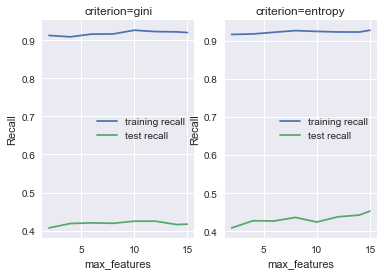

In [207]:
# Random Forest model parameters tuning for max_features
# build the model with the X_train

params = {'max_features': [2, 4, 6, 8, 10, 12, 14, 15],
          'criterion': ['gini','entropy']}

folds = StratifiedKFold(n_splits=5,shuffle=True)

rf = RandomForestClassifier(class_weight='balanced')

rf_grid = GridSearchCV(estimator=rf,
                           param_grid=params,
                           scoring='recall',
                           cv=folds,
                           verbose=1,
                           return_train_score=True)

rf_grid.fit(X_train,y_train)

rf_grid_cv_results = pd.DataFrame(rf_grid.cv_results_)
display(rf_grid_cv_results.head())


# plotting recall score with max_features
plt.figure()
plt.subplot(1,2,1)
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["param_max_features"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["mean_train_score"], 
         label="training recall")
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["param_max_features"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["mean_test_score"], 
         label="test recall")
plt.title('criterion=gini')
plt.xlabel("max_features")
plt.ylabel("Recall")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["param_max_features"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["mean_train_score"], 
         label="training recall")
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["param_max_features"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["mean_test_score"], 
         label="test recall")
plt.title('criterion=entropy')
plt.xlabel("max_features")
plt.ylabel("Recall")
plt.legend()

print("the best parameters chosen by the grid search is ",rf_grid.best_params_)

print("the best score chosen by the grid search is ",round(rf_grid.best_score_,3))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   44.0s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_min_samples_leaf,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.864111,0.012016,0.695314,0.921763,gini,10,"{'criterion': 'gini', 'min_samples_leaf': 10}",8,0.661157,0.918733,...,0.721763,0.916667,0.735537,0.922176,0.691460,0.926997,0.034957,0.000454,0.029393,0.003711
1,0.791813,0.012506,0.793386,0.861019,gini,60,"{'criterion': 'gini', 'min_samples_leaf': 60}",6,0.754821,0.858127,...,0.793388,0.853306,0.834711,0.840909,0.812672,0.876722,0.041127,0.000352,0.028470,0.013742
2,0.728322,0.013079,0.799996,0.848760,gini,110,"{'criterion': 'gini', 'min_samples_leaf': 110}",5,0.754821,0.847796,...,0.812672,0.851240,0.870523,0.844353,0.796143,0.856061,0.013558,0.001445,0.040883,0.004455
3,0.679526,0.012249,0.802201,0.837879,gini,160,"{'criterion': 'gini', 'min_samples_leaf': 160}",3,0.771350,0.848485,...,0.798898,0.816804,0.859504,0.840220,0.801653,0.838843,0.013495,0.001413,0.030844,0.011085
4,1.192065,0.013642,0.703578,0.932094,entropy,10,"{'criterion': 'entropy', 'min_samples_leaf': 10}",7,0.661157,0.931818,...,0.719008,0.942149,0.763085,0.933196,0.696970,0.928375,0.066307,0.001071,0.035476,0.005788


the best parameters chosen by the grid search is  {'criterion': 'entropy', 'min_samples_leaf': 160}
the best score chosen by the grid search is  0.809


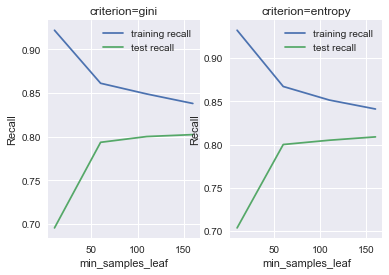

In [208]:
# Random Forest model parameters tuning for min_samples_leaf
# build the model with the train data

params = {'min_samples_leaf': range(10, 200, 50),
          'criterion': ['gini','entropy']}

folds = StratifiedKFold(n_splits=5,shuffle=True)

rf = RandomForestClassifier(class_weight='balanced')

rf_grid = GridSearchCV(estimator=rf,
                           param_grid=params,
                           scoring='recall',
                           cv=folds,
                           verbose=1,
                           return_train_score=True)

rf_grid.fit(X_train,y_train)

rf_grid_cv_results = pd.DataFrame(rf_grid.cv_results_)
display(rf_grid_cv_results.head())


# plotting recall score with min_samples_leaf
plt.figure()
plt.subplot(1,2,1)
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["param_min_samples_leaf"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["mean_train_score"], 
         label="training recall")
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["param_min_samples_leaf"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["mean_test_score"], 
         label="test recall")
plt.title('criterion=gini')
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["param_min_samples_leaf"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["mean_train_score"], 
         label="training recall")
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["param_min_samples_leaf"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["mean_test_score"], 
         label="test recall")
plt.title('criterion=entropy')
plt.xlabel("min_samples_leaf")
plt.ylabel("Recall")
plt.legend()

print("the best parameters chosen by the grid search is ",rf_grid.best_params_)

print("the best score chosen by the grid search is ",round(rf_grid.best_score_,3))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   58.4s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_min_samples_split,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.817641,0.010159,0.530578,0.932782,gini,10,"{'criterion': 'gini', 'min_samples_split': 10}",12,0.509642,0.935262,...,0.556474,0.940083,0.548209,0.923554,0.501377,0.938017,0.023655,0.000220,0.021522,0.006411
1,0.818663,0.010893,0.696972,0.910606,gini,60,"{'criterion': 'gini', 'min_samples_split': 60}",10,0.721763,0.904959,...,0.691460,0.911846,0.694215,0.906336,0.655647,0.918733,0.045830,0.001245,0.024392,0.004858
2,0.854982,0.011026,0.752617,0.890220,gini,110,"{'criterion': 'gini', 'min_samples_split': 110}",8,0.746556,0.886364,...,0.771350,0.900826,0.763085,0.894628,0.716253,0.889118,0.029114,0.000094,0.019971,0.007058
3,0.897992,0.010901,0.779615,0.877824,gini,160,"{'criterion': 'gini', 'min_samples_split': 160}",6,0.768595,0.879477,...,0.760331,0.877410,0.815427,0.882231,0.757576,0.880165,0.044210,0.000338,0.022515,0.004281
4,0.917720,0.011782,0.789533,0.875207,gini,210,"{'criterion': 'gini', 'min_samples_split': 210}",3,0.804408,0.877410,...,0.771350,0.876722,0.793388,0.865702,0.779614,0.876722,0.060790,0.000324,0.012271,0.004858


the best parameters chosen by the grid search is  {'criterion': 'entropy', 'min_samples_split': 260}
the best score chosen by the grid search is  0.803


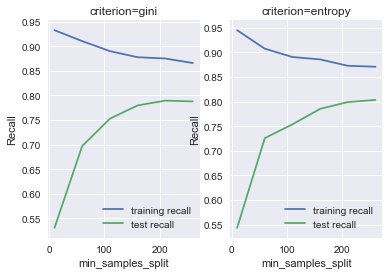

In [209]:
# Random Forest model parameters tuning for min_samples_split
# build the model with the X train data

params = {'min_samples_split': range(10, 300, 50),
          'criterion': ['gini','entropy']}

folds = StratifiedKFold(n_splits=5,shuffle=True)

rf = RandomForestClassifier(class_weight='balanced')

rf_grid = GridSearchCV(estimator=rf,
                           param_grid=params,
                           scoring='recall',
                           cv=folds,
                           verbose=1,
                           return_train_score=True)

rf_grid.fit(X_train,y_train)

rf_grid_cv_results = pd.DataFrame(rf_grid.cv_results_)
display(rf_grid_cv_results.head())


# plotting recall score with min_samples_split
plt.figure()
plt.subplot(1,2,1)
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["param_min_samples_split"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["mean_train_score"], 
         label="training recall")
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["param_min_samples_split"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='gini']["mean_test_score"], 
         label="test recall")
plt.title('criterion=gini')
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["param_min_samples_split"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["mean_train_score"], 
         label="training recall")
plt.plot(rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["param_min_samples_split"], 
         rf_grid_cv_results[rf_grid_cv_results.param_criterion=='entropy']["mean_test_score"], 
         label="test recall")
plt.title('criterion=entropy')
plt.xlabel("min_samples_split")
plt.ylabel("Recall")
plt.legend()

print("the best parameters chosen by the grid search is ",rf_grid.best_params_)

print("the best score chosen by the grid search is ",round(rf_grid.best_score_,3))

###### From the above parameter tuning one at a time, we got the best params as 

* max_depth = 12
* n_estimators = 100  
* max_features = 15
* min_samples_leaf = 160
* min_samples_split = 200
* criterion = 'entropy'
* class_weight

In [210]:
# Random Forest model parameters tuning for min_samples_split
# build the model with the X train

params = {'max_depth': [10,12,14],
          'n_estimators': [100],
          'max_features': [15,20],
          'min_samples_leaf': [160],
          'min_samples_split': [200],
          'class_weight': ['balanced'],
          'criterion': ['entropy']
         }

folds = StratifiedKFold(n_splits=5,shuffle=True)

rf = RandomForestClassifier()

rf_grid = GridSearchCV(estimator=rf,
                           param_grid=params,
                           scoring='recall',
                           cv=folds,
                           verbose=1,
                           return_train_score=True)

rf_grid.fit(X_train,y_train)

# rf_grid_cv_results = pd.DataFrame(rf_grid.cv_results_)
# display(rf_grid_cv_results.head())
# rf_grid.cv_results_.to_csv()

print("The best parameters chosen by the grid search is ",rf_grid.best_params_)
print("")
print("The best score chosen by the grid search is ",round(rf_grid.best_score_,3))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  5.3min finished


The best parameters chosen by the grid search is  {'max_depth': 10, 'n_estimators': 100, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 20, 'min_samples_split': 200, 'min_samples_leaf': 160}

The best score chosen by the grid search is  0.826


In [214]:
# build a random forest model with the chosen parameters

rf_best = RandomForestClassifier(class_weight='balanced',
                                 n_estimators = 100,
                                 max_depth = 12,
                                 criterion='entropy',
                                 min_samples_leaf=160,
                                 max_features = 20,
                                 min_samples_split=200,oob_score=True)

# cross validation with the choosen model
print(cross_val_score(rf_best,X_train, y_train,cv=folds,scoring='recall'))


[0.82369146 0.83195592 0.81267218 0.82093664 0.82093664]


In [216]:
# validate other metrics with train data
rf_best.fit(X_train, y_train)

y_pred_train_rf_best = rf_best.predict(X_train)

print_metrics(y_train,y_pred_train_rf_best)

tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train_rf_best).ravel()

print("The OOB Score of Random Forest model : ",rf_best.oob_score_)

******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     19182
           1       0.44      0.87      0.58      1815

   micro avg       0.89      0.89      0.89     20997
   macro avg       0.71      0.88      0.76     20997
weighted avg       0.94      0.89      0.91     20997

******************************
*** Confusion Matrix ***
******************************
[[17188  1994]
 [  243  1572]]

******************************
Accuracy :  0.8934609706148497

tn: 17188
fp: 1994
fn: 243
tp: 1572

AUC: 0.88
******************************
The OOB Score of Random Forest model :  0.8865552221745964


In [217]:
# #Creating a dataframe for Random Forest summary
randomForest_train_report = pd.DataFrame([['Random Forest - train', tp, tn,fp,fn, accuracy_score(y_train,y_pred_train_rf_best),recall_score(y_train,y_pred_train_rf_best),roc_auc_score(y_train,y_pred_train_rf_best)]], columns=reporter_col)
randomForest_train_report

,Model,tp,tn,fp,fn,Accuracy,Sensitivity,AUC
0,Random Forest - train,1572,17188,1994,243,0.893461,0.866116,0.881082


In [262]:
# validate other metrics with test data
rf_best.fit(X_train, y_train)

# apply scale to X_test
#X_test_scale = scale.transform(X_test)

#transform the X_test with pca
#X_test_pca = pca.transform(X_test_scale)
#print(X_test_pca.shape)

y_pred_test_rf_best = rf_best.predict(X_test)

print_metrics(y_test,y_pred_test_rf_best)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test_rf_best).ravel()


******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.98      0.89      0.93      8221
           1       0.42      0.83      0.55       778

   micro avg       0.88      0.88      0.88      8999
   macro avg       0.70      0.86      0.74      8999
weighted avg       0.93      0.88      0.90      8999

******************************
*** Confusion Matrix ***
******************************
[[7312  909]
 [ 131  647]]

******************************
Accuracy :  0.8844316035115013

tn: 7312
fp: 909
fn: 131
tp: 647

AUC: 0.86
******************************


In [263]:
# #Creating a dataframe for Random Forest summary
randomForest_test_report = pd.DataFrame([['Random Forest - test', tp, tn,fp,fn, 
                                          accuracy_score(y_test,y_pred_test_rf_best),
                                          recall_score(y_test,y_pred_test_rf_best),
                                          roc_auc_score(y_test,y_pred_test_rf_best)]], columns=reporter_col)
randomForest_test_report

,Model,tp,tn,fp,fn,Accuracy,Sensitivity,AUC
0,Random Forest - test,647,7312,909,131,0.884432,0.83162,0.860525


<b> Observations: </b>
    1. Random Forest model with below parameters gives a recall score of 0.89 on train data and 0.79 on the test data.
    
    {'class_weight': 'balanced', 'n_estimators': 100, 'max_depth': 14, 'criterion': 'gini', 'min_samples_leaf': 50, 'max_features': 10, 'min_samples_split': 70}  
    
    2. The metrics with the random forest model with test data are as follows
        tn: 7660
        fp: 561
        fn: 167
        tp: 611
        
        AUC: 0.86

# 5.3 Gaussian Naive Bayes Model 

In [220]:
#Build a Gaussian Naive Bayes model with default values since the pca features are continuous and normally distributed.
gnb_default=GaussianNB()

print(gnb_default)

gnb_default.fit(X_train_pca,y_train)

y_pred_train_gnb_default =gnb_default.predict(X_train_pca)

print_metrics(y_train,y_pred_train_gnb_default)

GaussianNB(priors=None, var_smoothing=1e-09)
******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     19182
           1       0.31      0.20      0.24      1815

   micro avg       0.89      0.89      0.89     20997
   macro avg       0.62      0.58      0.59     20997
weighted avg       0.87      0.89      0.88     20997

******************************
*** Confusion Matrix ***
******************************
[[18385   797]
 [ 1451   364]]

******************************
Accuracy :  0.8929370862504167

tn: 18385
fp: 797
fn: 1451
tp: 364

AUC: 0.58
******************************


In [221]:
#Build a Gaussian Naive Bayes model with priors=[0.913,0.087]. Define the class priori's : P(Churn)=(1815/21007)=0.087 , P(Non_Churn)=(19192/21007)=0.913
gnb_default=GaussianNB(priors=[0.913,0.087])

print(gnb_default)

gnb_default.fit(X_train_pca,y_train)

y_pred_train_gnb_default =gnb_default.predict(X_train_pca)

print_metrics(y_train,y_pred_train_gnb_default)

GaussianNB(priors=[0.913, 0.087], var_smoothing=1e-09)
******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     19182
           1       0.31      0.20      0.25      1815

   micro avg       0.89      0.89      0.89     20997
   macro avg       0.62      0.58      0.59     20997
weighted avg       0.87      0.89      0.88     20997

******************************
*** Confusion Matrix ***
******************************
[[18383   799]
 [ 1450   365]]

******************************
Accuracy :  0.8928894603991047

tn: 18383
fp: 799
fn: 1450
tp: 365

AUC: 0.58
******************************


In [222]:
# There is no change in the prior's are none and given as [0.913,0.087]
# Build a model with balanced class. Class imbalance might produce a predictive bias so compensate this by a)exasperating the level
# of class imbalance and then b)use one of the two methods for adjusting the class imbalance i)increase the number of sampled points 
# in minority class (decreasing it from 9% to 5% churned = 1050) ii)decrease the number of sampled points in majority class
# In this project, SMOTE has been implemented i.e increasing the number of sampled points

from collections import Counter
print('Distribution before imbalancing: {}'.format(Counter(y_train)))
from imblearn.datasets import make_imbalance
X_resampled, y_resampled = make_imbalance(X_train_pca,y_train,sampling_strategy={0.0: 19182, 1.0: 1050}, random_state = 249)
print('Distribution after imbalancing: {}'.format(Counter(y_resampled)))

#oversampling is done using SMOTE. This ensures that number of sample points in the minority class that is churned is equal to 
#majority class
from imblearn.over_sampling import SMOTE
smote = SMOTE(kind = "regular")
X_sm, y_sm = smote.fit_sample(X_resampled, y_resampled)


# check the churn values in y 
print('Distribution after applying SMOTE: {}'.format(Counter(y_sm)))


Distribution before imbalancing: Counter({0: 19182, 1: 1815})
Distribution after imbalancing: Counter({0: 19182, 1: 1050})
Distribution after applying SMOTE: Counter({0: 19182, 1: 19182})


In [223]:
#Build a model after sampling with the train data
gnb_sampled=GaussianNB()

print(gnb_sampled)

gnb_sampled.fit(X_sm,y_sm)

y_pred_train_gnb_sampled =gnb_sampled.predict(X_sm)

print_metrics(y_sm,y_pred_train_gnb_sampled)

GaussianNB(priors=None, var_smoothing=1e-09)
******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.80      0.51      0.62     19182
           1       0.64      0.88      0.74     19182

   micro avg       0.69      0.69      0.69     38364
   macro avg       0.72      0.69      0.68     38364
weighted avg       0.72      0.69      0.68     38364

******************************
*** Confusion Matrix ***
******************************
[[ 9722  9460]
 [ 2378 16804]]

******************************
Accuracy :  0.6914294651235533

tn: 9722
fp: 9460
fn: 2378
tp: 16804

AUC: 0.69
******************************


In [224]:
#Build a model after sampling with the train data
gnb_sampled=GaussianNB(priors=[0.5,0.5])

print(gnb_sampled)

gnb_sampled.fit(X_sm,y_sm)

y_pred_train_gnb_sampled =gnb_sampled.predict(X_sm)

print_metrics(y_sm,y_pred_train_gnb_sampled)

GaussianNB(priors=[0.5, 0.5], var_smoothing=1e-09)
******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.80      0.51      0.62     19182
           1       0.64      0.88      0.74     19182

   micro avg       0.69      0.69      0.69     38364
   macro avg       0.72      0.69      0.68     38364
weighted avg       0.72      0.69      0.68     38364

******************************
*** Confusion Matrix ***
******************************
[[ 9722  9460]
 [ 2378 16804]]

******************************
Accuracy :  0.6914294651235533

tn: 9722
fp: 9460
fn: 2378
tp: 16804

AUC: 0.69
******************************


In [225]:
# let us define the hyper parameters for the Gaussian Naive Bayes model without sampling.
# build the model with the scaled X values and PCA applied

params = {"var_smoothing": [1e-10,1e-09,1e-07,1e-05,1e-03,1e-01,1]}

folds = StratifiedKFold(n_splits=5,shuffle=True)

gnb_clf=GaussianNB()

gnb_grid = GridSearchCV(estimator=gnb_clf,
                           param_grid=params,
                           scoring='recall',
                           cv=folds,
                           verbose=1,
                           return_train_score=True)

gnb_grid.fit(X_train_pca,y_train)

gnb_grid_cv_results = pd.DataFrame(gnb_grid.cv_results_)
display(gnb_grid_cv_results.head())


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.6s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_var_smoothing,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.007196,0.002568,0.227002,0.234848,1e-10,{'var_smoothing': 1e-10},1,0.168044,0.185262,0.388430,...,0.179063,0.189394,0.220386,0.182507,0.179063,0.203168,0.000578,0.000371,0.082679,0.089813
1,0.006726,0.002399,0.227002,0.234848,1e-09,{'var_smoothing': 1e-09},1,0.168044,0.185262,0.388430,...,0.179063,0.189394,0.220386,0.182507,0.179063,0.203168,0.000302,0.000135,0.082679,0.089813
2,0.007249,0.002506,0.227002,0.234848,1e-07,{'var_smoothing': 1e-07},1,0.168044,0.185262,0.388430,...,0.179063,0.189394,0.220386,0.182507,0.179063,0.203168,0.001290,0.000273,0.082679,0.089813
3,0.006628,0.002363,0.227002,0.234848,1e-05,{'var_smoothing': 1e-05},1,0.168044,0.185262,0.388430,...,0.179063,0.189394,0.220386,0.182507,0.179063,0.203168,0.000119,0.000035,0.082679,0.089813
4,0.006502,0.002357,0.225900,0.233609,0.001,{'var_smoothing': 0.001},5,0.165289,0.183884,0.385675,...,0.179063,0.187328,0.220386,0.182507,0.179063,0.203168,0.000231,0.000045,0.082004,0.089080


In [226]:
# let us define the hyper parameters for the Gaussian Naive Bayes model with sampling
# build the model with the scaled X values and PCA applied

params = {"var_smoothing": [1e-10,1e-09,1e-07,1e-05,1e-03,1e-01,1]}

folds = StratifiedKFold(n_splits=5,shuffle=True)

gnb_clf=GaussianNB()

gnb_grid_sampled = GridSearchCV(estimator=gnb_clf,
                           param_grid=params,
                           scoring='recall',
                           cv=folds,
                           verbose=1,
                           return_train_score=True)

gnb_grid_sampled.fit(X_sm,y_sm)

gnb_grid_sampled_cv_results = pd.DataFrame(gnb_grid_sampled.cv_results_)
display(gnb_grid_sampled_cv_results.head())

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.2s finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_var_smoothing,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.012725,0.005096,0.875352,0.876486,1e-10,{'var_smoothing': 1e-10},4,0.869950,0.877094,0.883242,...,0.860010,0.879187,0.875652,0.875147,0.887904,0.875929,0.002292,0.000453,0.009843,0.001534
1,0.011819,0.005023,0.875352,0.876486,1e-09,{'var_smoothing': 1e-09},4,0.869950,0.877094,0.883242,...,0.860010,0.879187,0.875652,0.875147,0.887904,0.875929,0.001301,0.000469,0.009843,0.001534
2,0.010879,0.004691,0.875352,0.876486,1e-07,{'var_smoothing': 1e-07},4,0.869950,0.877094,0.883242,...,0.860010,0.879187,0.875652,0.875147,0.887904,0.875929,0.000179,0.000153,0.009843,0.001534
3,0.011467,0.004883,0.875352,0.876486,1e-05,{'var_smoothing': 1e-05},4,0.869950,0.877094,0.883242,...,0.860010,0.879187,0.875652,0.875147,0.887904,0.875929,0.000344,0.000149,0.009843,0.001534
4,0.011733,0.005266,0.876134,0.877124,0.001,{'var_smoothing': 0.001},3,0.870993,0.877615,0.883763,...,0.860792,0.879578,0.876434,0.876059,0.888686,0.876841,0.000558,0.000128,0.009774,0.001416


the best parameters chosen by the grid search is  {'var_smoothing': 1}
the best score chosen by the grid search is  0.946


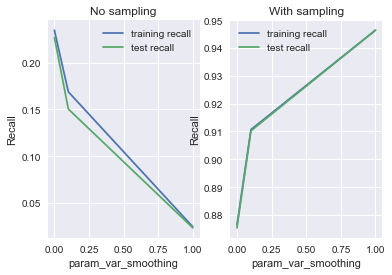

In [227]:
# plotting recall score with 
plt.figure()
plt.subplot(1,2,1)
plt.plot(gnb_grid_cv_results["param_var_smoothing"], 
          gnb_grid_cv_results["mean_train_score"], 
          label="training recall")
plt.plot(gnb_grid_cv_results["param_var_smoothing"], 
          gnb_grid_cv_results["mean_test_score"], 
          label="test recall")
plt.title('No sampling')
plt.xlabel("param_var_smoothing")
plt.ylabel("Recall")
plt.legend()

plt.subplot(1,2,2)
plt.plot(gnb_grid_sampled_cv_results["param_var_smoothing"], 
          gnb_grid_sampled_cv_results["mean_train_score"], 
          label="training recall")
plt.plot(gnb_grid_sampled_cv_results["param_var_smoothing"], 
          gnb_grid_sampled_cv_results["mean_test_score"], 
          label="test recall")
plt.title('With sampling')
plt.xlabel("param_var_smoothing")
plt.ylabel("Recall")
plt.legend()
print("the best parameters chosen by the grid search is ",gnb_grid_sampled.best_params_)

print("the best score chosen by the grid search is ",round(gnb_grid_sampled.best_score_,3))

In [228]:
# build a Gaussian Naive Bayes with the chosen parameters
# we choose sampled data and var_smoothing is 1

gnb_best = GaussianNB(var_smoothing = 1)

# cross validation with the choosen model
cross_val_score(gnb_best,X_sm, y_sm,cv=folds,scoring='recall')

array([0.95178525, 0.94396664, 0.93639208, 0.9447341 , 0.95385819])

In [229]:
# validate other metrics with train data
gnb_best.fit(X_sm, y_sm)

y_pred_train_gnb_best = gnb_best.predict(X_sm)

print_metrics(y_sm,y_pred_train_gnb_best)

******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.88      0.39      0.54     19182
           1       0.61      0.95      0.74     19182

   micro avg       0.67      0.67      0.67     38364
   macro avg       0.74      0.67      0.64     38364
weighted avg       0.74      0.67      0.64     38364

******************************
*** Confusion Matrix ***
******************************
[[ 7397 11785]
 [ 1028 18154]]

******************************
Accuracy :  0.666015014075696

tn: 7397
fp: 11785
fn: 1028
tp: 18154

AUC: 0.67
******************************


In [230]:
# validate other metrics with test data
gnb_best.fit(X_sm, y_sm)

# apply scale to X_test
X_test_scale = scale.transform(X_test)

#transform the X_test with pca
X_test_pca = pca.transform(X_test_scale)
print(X_test_pca.shape)

y_pred_test_gnb_best = gnb_best.predict(X_test_pca)

print_metrics(y_test,y_pred_test_gnb_best)

(8999, 24)
******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.98      0.39      0.56      8221
           1       0.12      0.92      0.22       778

   micro avg       0.43      0.43      0.43      8999
   macro avg       0.55      0.66      0.39      8999
weighted avg       0.91      0.43      0.53      8999

******************************
*** Confusion Matrix ***
******************************
[[3187 5034]
 [  60  718]]

******************************
Accuracy :  0.4339371041226803

tn: 3187
fp: 5034
fn: 60
tp: 718

AUC: 0.66
******************************


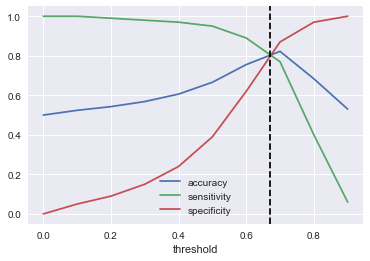

In [234]:
# tune the cut off threshold of gaussian naive bayes with train data

gnb_best.fit(X_sm, y_sm)

# predict the probabilities of churn and non-churn
y_pred_train_gaussreg_thres_pred = gnb_best.predict_proba(X_sm)

# range of threshold values
threshold_vals = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

sensitivity_vals = []
specificity_vals = []
accuracy_vals=[]
for thres in threshold_vals:
    y_pred_thres = np.where(y_pred_train_gaussreg_thres_pred[:,1] > thres, 1, 0)
    tn, fp, fn, tp = confusion_matrix(y_sm,y_pred_thres).ravel()
    sensitivity_vals.append(round(tp/(tp+fn),2))
    specificity_vals.append(round(tn/(tn+fp),2))
    accuracy_vals.append(accuracy_score(y_sm, y_pred_thres))

    
sensi_specifi_df = pd.DataFrame({"threshold":threshold_vals,"sensitivity": sensitivity_vals,
                               "specificity":specificity_vals, "accuracy":accuracy_vals})

# plot the Sensitivity, recall, Accuracy for each threshold values

sensi_specifi_df.plot.line(x='threshold', y=['accuracy','sensitivity','specificity'])
plt.axvline(x=0.67,color='k', linestyle='--')


In [235]:
#GNB with threshold=0.5
gnb_best.fit(X_sm, y_sm)

# predict the probabilities of churn and non-churn
y_pred_train_gaussreg_thres_pred = gnb_best.predict_proba(X_sm)

thres = 0.5
y_pred_thres = np.where(y_pred_train_gaussreg_thres_pred[:,1] > thres, 1, 0)
print_metrics(y_sm, y_pred_thres)


tn, fp, fn, tp = confusion_matrix(y_sm, y_pred_thres).ravel()



******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.88      0.39      0.54     19182
           1       0.61      0.95      0.74     19182

   micro avg       0.67      0.67      0.67     38364
   macro avg       0.74      0.67      0.64     38364
weighted avg       0.74      0.67      0.64     38364

******************************
*** Confusion Matrix ***
******************************
[[ 7397 11785]
 [ 1028 18154]]

******************************
Accuracy :  0.666015014075696

tn: 7397
fp: 11785
fn: 1028
tp: 18154

AUC: 0.67
******************************


In [236]:
# #Creating a dataframe for GNB summary
GNB_train_report = pd.DataFrame([['Gaussian Naive Bayes - train', tp, tn,fp,fn, accuracy_score(y_sm, y_pred_thres),recall_score(y_sm, y_pred_thres),roc_auc_score(y_sm, y_pred_thres)]], columns=reporter_col)
GNB_train_report

,Model,tp,tn,fp,fn,Accuracy,Sensitivity,AUC
0,Gaussian Naive Bayes - train,18154,7397,11785,1028,0.666015,0.946408,0.666015


In [237]:
# Recall is 0.65 at threshold value 0.5, Precision is 0.38 which is reasonable. 
sensi_specifi_df[sensi_specifi_df.threshold==0.5]

,accuracy,sensitivity,specificity,threshold
5,0.666015,0.95,0.39,0.5


In [238]:
# apply scale to X_test
X_test_scale = scale.transform(X_test)

#transform the X_test with pca
X_test_pca = pca.transform(X_test_scale)
print(X_test_pca.shape)

y_pred_test_gnb_best = gnb_best.predict_proba(X_test_pca)

thres = 0.5
y_pred_thres = np.where(y_pred_test_gnb_best[:,1] > thres, 1, 0)
print_metrics(y_test,y_pred_thres)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_thres).ravel()


(8999, 24)
******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.98      0.39      0.56      8221
           1       0.12      0.92      0.22       778

   micro avg       0.43      0.43      0.43      8999
   macro avg       0.55      0.66      0.39      8999
weighted avg       0.91      0.43      0.53      8999

******************************
*** Confusion Matrix ***
******************************
[[3187 5034]
 [  60  718]]

******************************
Accuracy :  0.4339371041226803

tn: 3187
fp: 5034
fn: 60
tp: 718

AUC: 0.66
******************************


In [239]:
# #Creating a dataframe for GNB summary
GNB_test_report = pd.DataFrame([['Gaussian Naive Bayes - test', tp, tn,fp,fn, accuracy_score(y_test, y_pred_thres),recall_score(y_test, y_pred_thres),roc_auc_score(y_test, y_pred_thres)]], columns=reporter_col)
GNB_test_report

,Model,tp,tn,fp,fn,Accuracy,Sensitivity,AUC
0,Gaussian Naive Bayes - test,718,3187,5034,60,0.433937,0.922879,0.655272


<b> Observations:To be checked </b> 
    1. Gaussian Naive Bayes Regression model with sampling gave a recall score of 0.97 on train data and 0.95 on the test data. 
    2. With a cutoff threshold 0.8, we get Recall score 0.83 on training data and 0.81 on test data. 
    3. The metrics with the Gaussian Naive Bayes model with test data are as follows
        tn: 6067
        fp: 2159
        fn: 151
        tp: 627
        
        AUC: 0.7

# 5.4 SVM model and hyper parameter tuning

In [240]:
#Build a linear SVC classifier with default parameters and evaluate the model on train data
svc_default = SVC(kernel='linear')
print(svc_default)
# fit
svc_default.fit(X_train_pca, y_train)
# predict
y_pred_default = svc_default.predict(X_train_pca)
print_metrics(y_train,y_pred_default)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     19182
           1       0.00      0.00      0.00      1815

   micro avg       0.91      0.91      0.91     20997
   macro avg       0.46      0.50      0.48     20997
weighted avg       0.83      0.91      0.87     20997

******************************
*** Confusion Matrix ***
******************************
[[19182     0]
 [ 1815     0]]

******************************
Accuracy :  0.9135590798685527

tn: 19182
fp: 0
fn: 1815
tp: 0

AUC: 0.5
******************************


In [241]:
#Build a linear SVC classifier by setting the parameter (class_weight='balanced') and evaluate the model on train data
svc_balanced = SVC(kernel='linear',class_weight='balanced',C=1)
print(svc_balanced)
# fit
svc_balanced.fit(X_train_pca, y_train)
# predict
y_pred_balanced = svc_balanced.predict(X_train_pca)
print_metrics(y_train,y_pred_balanced)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     19182
           1       0.32      0.82      0.45      1815

   micro avg       0.83      0.83      0.83     20997
   macro avg       0.65      0.82      0.68     20997
weighted avg       0.92      0.83      0.86     20997

******************************
*** Confusion Matrix ***
******************************
[[15953  3229]
 [  330  1485]]

******************************
Accuracy :  0.8304995951802638

tn: 15953
fp: 3229
fn: 330
tp: 1485

AUC: 0.82
******************************


Observation:
    Due to class imbalance, the default SVC classifier has misclassified all the churn variables. Once 'class weight'=balanced,
    is mentioned, the recall rate rate of the churn is 0.81.

In [242]:
# let us define the hyper parameters for the Logistic regresion model.
# build the model with the scaled X values and PCA applied

params = {"C": [0.00001,0.0001,0.001,0.01, 0.1,1]}

folds = StratifiedKFold(n_splits=5,shuffle=True)

svc_clf = SVC(kernel='linear',class_weight='balanced')

svc_grid = GridSearchCV(estimator=svc_clf,
                           param_grid=params,
                           scoring='recall',
                           cv=folds,
                           verbose=1,
                           return_train_score=True)

svc_grid.fit(X_train_pca,y_train)

svc_grid_cv_results = pd.DataFrame(svc_grid.cv_results_)
display(svc_grid_cv_results.head())



Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  7.8min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,8.999075,1.014661,0.835262,0.837603,1e-05,{'C': 1e-05},1,0.831956,0.842287,0.837466,...,0.856749,0.830579,0.823691,0.839532,0.826446,0.838154,0.203559,0.010199,0.011739,0.003881
1,5.929338,0.658778,0.811570,0.814050,0.0001,{'C': 0.0001},6,0.801653,0.814050,0.820937,...,0.837466,0.809917,0.798898,0.820937,0.798898,0.812672,0.073457,0.009409,0.015348,0.003696
2,6.111231,0.687296,0.813774,0.819146,0.001,{'C': 0.001},4,0.812672,0.822314,0.820937,...,0.837466,0.807163,0.793388,0.825758,0.804408,0.821625,0.362117,0.034177,0.014947,0.006381
3,8.180096,0.788539,0.813774,0.819697,0.01,{'C': 0.01},5,0.809917,0.824380,0.820937,...,0.831956,0.809229,0.798898,0.824380,0.807163,0.820937,0.851221,0.070867,0.011504,0.005568
4,11.764649,0.704565,0.814876,0.819835,0.1,{'C': 0.1},3,0.809917,0.825069,0.820937,...,0.831956,0.809917,0.807163,0.822314,0.804408,0.820937,1.155207,0.058838,0.010219,0.005183


In [243]:
# let us define the hyper parameters for the Logistic regresion model.
# build the model with the scaled X values and PCA applied

params = {"C": [0.00001,0.0001,0.001,0.01, 0.1,1]}

folds = StratifiedKFold(n_splits=5,shuffle=True)

svc_clf_default = SVC(kernel='linear',class_weight= None)

svc_grid_default = GridSearchCV(estimator=svc_clf_default,
                           param_grid=params,
                           scoring='recall',
                           cv=folds,
                           verbose=1,
                           return_train_score=True)

svc_grid_default.fit(X_train_pca,y_train)

svc_grid_default_cv_results = pd.DataFrame(svc_grid_default.cv_results_)
display(svc_grid_default_cv_results.head())


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.2min finished


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.440823,0.244333,0.0,0.0,1e-05,{'C': 1e-05},1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.067433,0.008835,0.0,0.0
1,1.396403,0.236023,0.0,0.0,0.0001,{'C': 0.0001},1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.032139,0.003975,0.0,0.0
2,1.471520,0.252314,0.0,0.0,0.001,{'C': 0.001},1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.018857,0.022375,0.0,0.0
3,1.561094,0.251822,0.0,0.0,0.01,{'C': 0.01},1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.088874,0.009788,0.0,0.0
4,2.663417,0.280361,0.0,0.0,0.1,{'C': 0.1},1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.122433,0.018622,0.0,0.0


the best parameters chosen by the grid search is  {'C': 1e-05}
the best score chosen by the grid search is  0.835


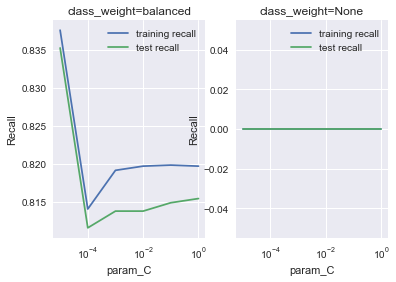

In [244]:
# plotting recall score with 
plt.figure()
plt.subplot(1,2,1)
plt.plot(svc_grid_cv_results["param_C"], 
          svc_grid_cv_results["mean_train_score"], 
          label="training recall")
plt.plot(svc_grid_cv_results["param_C"], 
          svc_grid_cv_results["mean_test_score"], 
          label="test recall")
plt.title('class_weight=balanced')
plt.xlabel("param_C")
plt.xscale('log')
plt.ylabel("Recall")
plt.legend()

plt.subplot(1,2,2)
plt.plot(svc_grid_default_cv_results["param_C"], 
          svc_grid_default_cv_results["mean_train_score"], 
          label="training recall"
        )
plt.plot(svc_grid_default_cv_results["param_C"], 
          svc_grid_default_cv_results["mean_test_score"], 
          label="test recall")
plt.title('class_weight=None')
plt.xlabel("param_C")
plt.ylabel("Recall")
plt.xscale('log')
plt.legend()
print("the best parameters chosen by the grid search is ",svc_grid.best_params_)

print("the best score chosen by the grid search is ",round(svc_grid.best_score_,3))

In [245]:
# build a SVC with the chosen parameters
# class_weight='balanced',C=1e-05

svc_best = SVC(kernel='linear',class_weight='balanced',C=1e-05)

# cross validation with the choosen model
cross_val_score(svc_best,X_train_pca,y_train,cv=folds,scoring='recall')

array([0.84848485, 0.82369146, 0.83746556, 0.83195592, 0.84573003])

In [259]:
# validate other metrics with train data
svc_best.fit(X_train_pca,y_train)

y_pred_train_svc_best = svc_best.predict(X_train_pca)

print_metrics(y_train,y_pred_train_svc_best)
tn, fp, fn, tp = confusion_matrix(y_train,y_pred_train_svc_best).ravel()

******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     19182
           1       0.27      0.83      0.41      1815

   micro avg       0.79      0.79      0.79     20997
   macro avg       0.63      0.81      0.64     20997
weighted avg       0.92      0.79      0.83     20997

******************************
*** Confusion Matrix ***
******************************
[[15161  4021]
 [  307  1508]]

******************************
Accuracy :  0.7938753155212649

tn: 15161
fp: 4021
fn: 307
tp: 1508

AUC: 0.81
******************************


In [260]:
# #Creating a dataframe for logistic regression summary
svm_train_report = pd.DataFrame([['SVM - train', tp, tn,fp,fn, 
                                  accuracy_score(y_train,y_pred_train_svc_best),
                                  recall_score(y_train,y_pred_train_svc_best),
                                  roc_auc_score(y_train,y_pred_train_svc_best)]], columns=reporter_col)
svm_train_report

,Model,tp,tn,fp,fn,Accuracy,Sensitivity,AUC
0,SVM - train,1508,15161,4021,307,0.793875,0.830854,0.810615


In [255]:
#### validate other metrics with test data
svc_best.fit(X_train_pca,y_train)

# apply scale to X_test
X_test_scale = scale.transform(X_test)

#transform the X_test with pca
X_test_pca = pca.transform(X_test_scale)
print(X_test_pca.shape)

y_pred_test_svc_best = svc_best.predict(X_test_pca)

print_metrics(y_test,y_pred_test_svc_best)

tn, fp, fn, tp = confusion_matrix(y_test,y_pred_test_svc_best).ravel()

(8999, 24)
******************************
*** Classification Report ***
******************************
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      8221
           1       0.26      0.83      0.40       778

   micro avg       0.78      0.78      0.78      8999
   macro avg       0.62      0.80      0.63      8999
weighted avg       0.92      0.78      0.83      8999

******************************
*** Confusion Matrix ***
******************************
[[6413 1808]
 [ 136  642]]

******************************
Accuracy :  0.783975997333037

tn: 6413
fp: 1808
fn: 136
tp: 642

AUC: 0.8
******************************


<b>Observations:</b>
1. SVC model with balanced class weight gave a recall score of 0.90 on train data and 0.90 on the test data. 
2. SVC model without balanced class weight gave a recall score of 0.00 on train data and 0.00 on the test data. 
3. The metrics with the SVC model with test data are as follows

    tn: 6413
    fp: 1808
    fn: 136
    tp: 642
    
    AUC: 0.8

In [256]:
# #Creating a dataframe for logistic regression summary
svm_test_report = pd.DataFrame([['SVM - test', tp, tn,fp,fn, 
                                 accuracy_score(y_test,y_pred_test_svc_best),
                                 recall_score(y_test,y_pred_test_svc_best),
                                 roc_auc_score(y_test,y_pred_test_svc_best)]], columns=reporter_col)
svm_test_report

,Model,tp,tn,fp,fn,Accuracy,Sensitivity,AUC
0,SVM - test,642,6413,1808,136,0.783976,0.825193,0.802634


# Inferences:

Our goal is to identify all the churns as many as possible. 

Hence Recall was the scoring criteria considered for tuning the hyper parameters for all the models

The assumption here is the cost of missing to identify a churn is very high compared a nominal number of non-churns identified as churn. So we have to tradeoff between False Negatives and False Positives. We do not want any False Negatives, at the same time we cannot have high number of False Positives (where cost of retaining a customer is also high)

In [264]:
# Report Summary
reporter = pd.DataFrame(columns=reporter_col)
reporter=reporter.append(logistic_train_report)
reporter=reporter.append(logistic_test_report)
reporter=reporter.append(GNB_train_report)
reporter=reporter.append(GNB_test_report)
reporter=reporter.append(randomForest_train_report)
reporter=reporter.append(randomForest_test_report)
reporter=reporter.append(svm_train_report)
reporter=reporter.append(svm_test_report)

reporter

,Model,tp,tn,fp,fn,Accuracy,Sensitivity,AUC
0,Logistic Regression - train,1655,10227,8955,160,0.565890,0.911846,0.722501
0,Logistic Regression - test,717,4384,3837,61,0.566841,0.921594,0.727431
0,Gaussian Naive Bayes - train,18154,7397,11785,1028,0.666015,0.946408,0.666015
0,Gaussian Naive Bayes - test,718,3187,5034,60,0.433937,0.922879,0.655272
0,Random Forest - train,1572,17188,1994,243,0.893461,0.866116,0.881082
0,Random Forest - test,647,7312,909,131,0.884432,0.831620,0.860525
0,SVM - train,1508,15161,4021,307,0.793875,0.830854,0.810615
0,SVM - test,642,6413,1808,136,0.783976,0.825193,0.802634


## Naive Bayes:

In this assignment experiment, Naive bayes has a very good recall score of 0.94 for train data and 0.92 for test data. 

The AUC  score is just above 0.5 and has many false positives

## SVC:

Sensitivity value of SVC is low comparing other models, so we are not selecting this model.

## Logistic Regression: 

 - Logistic regression has a very good score of 0.92 for both train and test. 
 - While the False Negatives are less compared to other models, the false positives are higher. Almost 40% of non-churns are identified as churns. 
 - The telecom company has to invest in all the customers identified as churns from this model. That means, it has to invest on the 40% of non-churns identified as churns. 
 - Also to save 717 churn customers (TP) it has to unnecessarily invest on additional 3837 non-churn customers (FP) at the same time loosing out 61 churn customers (FN)

## Random Forest [Choosen as the best model for the problem]

 - Random Forest gives a recall score of 0.86 with train and 0.83 with test. 
 - It has the highest AUC among all the models tried. 
 - Our goal is to reduce FN and this model has identified 131 churns as non-churns. At the same time, it has identified 909 non-churns as churns. 
 - If the telecom company uses this model, it can spend on 647 churn customers (TP). Additionally 909 non-churn customers (FP) at the same time loosing out 131 churn customers (FN)
 - While the TP and FN are relatively same with Logistic regression, FP are 4 times lesser in Random Forest. 
 
 `So we are selecting this model for this problem statement`